In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
# tf.compat.v1.enable_eager_execution()

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

import math
from matplotlib import pyplot as plt
import gc

from celluloid import Camera


In [2]:
L = 80
T = 5

rho = 8.92
Cp = 0.092
k = 0.95

c_square = k/(rho*Cp)

lambda_sqaure = (c_square*math.pi**2)/L**2


In [3]:
# Sampler for sampling the points

def point_sampler(batch_size):

    # Sample the initial points uniformly in time and spatial domain

    # x = tf.random.uniform(shape=[batch_size,1],minval=0,maxval=L)
    x = tf.random.truncated_normal(shape=[batch_size,1], mean=40, stddev=20, dtype=tf.dtypes.float32, seed=None, name=None)
    # x = tf.convert_to_tensor(get_truncated_normal(mean=40,sd=10,low=0,upp=L).rvs([batch_size,1]))
    # x = tf.cast(x, tf.float32)
    # print(x.shape)
    # x = np.random.uniform(low=0, high=L, size=[batch_size,1])
    # t = np.random.uniform(low=0, high=T, size=[batch_size,1])

    t = tf.random.uniform(shape=[batch_size,1],minval=0,maxval=T)
    # t = tf.convert_to_tensor(get_truncated_normal(mean=2.5,sd=0.5,low=0,upp=T).rvs([batch_size,1]))
    # t = tf.cast(t, tf.float32)
   #  print(t.shape)
    x = tf.Variable(x, trainable=True)
    t = tf.Variable(t, trainable=True)



    x_t_leftBound = tf.Variable(tf.zeros(shape=[batch_size,1]))

    x_t_rightBound = tf.Variable(tf.zeros(shape=[batch_size,1])+L)


    # print(f'The shape of x and t array is {x_t.shape}')
    # print(f'The shape of x and t array for initial condition is{x_t_initial.shape}')
    # print(f'The shape of x and t array for right boundary condition{x_t_rightBound.shape}')
    # print(f'The shape of x and t array for left boundary condition{x_t_leftBound.shape}')

    return x,t,x_t_rightBound, x_t_leftBound


In [4]:
# model creator

def create_model(nn_architecture):

    input1 = keras.Input(shape=nn_architecture[0], name="input_layer1")

    input2 = keras.Input(shape=nn_architecture[0], name="input_layer2")

    inputs = keras.layers.concatenate([input1, input2])

    x = keras.layers.Dense(nn_architecture[1], activation=tf.keras.activations.tanh, name="dense_layer_1")(inputs)

    for i, nunits in enumerate(nn_architecture[2:-1]):

        x = keras.layers.Dense(nunits, activation=tf.keras.activations.tanh, name=f"dense_layer_{i+2}")(x)

    outputs = keras.layers.Dense(nn_architecture[-1], name="output_layer")(x)

    model = keras.Model(inputs=[input1,input2], outputs=outputs)

    model.summary()

    return model

In [5]:
# Loss Calculator

def calculate_loss(model, batchsize):

    x, t, x_t_rightBound, x_t_leftBound = point_sampler(batch_size=batchsize)

    t_init = tf.zeros_like(t)

    y = model([x, t])
    print(y.shape)

    with tf.GradientTape() as tape1:


        with tf.GradientTape(persistent=True) as tape2:

            y = model([x,t])

        dt = tape2.gradient(y,t)

        dx = tape2.gradient(y,x)

    dxx = tf.linalg.tensor_diag_part(tape1.jacobian(dx, x))

    print(dt.shape, dx.shape, dxx.shape)




    heat_equatn_loss = tf.square(dt-c_square*dxx)

    ic_loss = tf.square((tf.math.sin(tf.divide(math.pi*x,L)) - model([x,t_init])))

    left_bc_loss = tf.square(model([x_t_leftBound,t]) - tf.zeros_like(x_t_leftBound))

    right_bc_loss = tf.square(model([x_t_rightBound,t]) - tf.zeros_like(x_t_rightBound))



    return tf.reduce_mean(heat_equatn_loss+ic_loss+left_bc_loss+right_bc_loss), tf.reduce_mean(heat_equatn_loss), tf.reduce_mean(ic_loss), tf.reduce_mean(left_bc_loss + right_bc_loss )




In [6]:
def training(model, lr, epochs, batchsize):

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    loss = []
    h_loss_lst = []
    ic_loss_lst = []
    bc_loss_lst = []

    epochs_list = [i for i in range(epochs)]

    for epoch in range(epochs):

        print(f"\nStart of epoch {epoch}")

        with tf.GradientTape() as tape:

            loss_value, h_loss,ic_loss, bc_loss = calculate_loss(model=model,batchsize=batchsize)


        grads = tape.gradient(loss_value, model.trainable_weights)

        optimizer.apply_gradients(zip(grads, model.trainable_weights))


        print(f'Epoch No {epoch} completed\n')

        loss.append(loss_value.numpy())
        h_loss_lst.append(h_loss.numpy())
        ic_loss_lst.append(ic_loss.numpy())
        bc_loss_lst.append(bc_loss.numpy())

    plt.figure(1,figsize=(15,15))

    plt.subplot(2,2,1)
    plt.plot(epochs_list,loss,'-r')
    plt.xlabel('Epochs')
    plt.ylabel('Total Loss')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_list, h_loss_lst, '-r')
    plt.xlabel('Epochs')
    plt.ylabel('Heat Equation Loss')

    plt.subplot(2, 2, 3)
    plt.plot(epochs_list, ic_loss_lst, '-r')
    plt.xlabel('Epochs')
    plt.ylabel('Initial Condition Loss')

    plt.subplot(2, 2, 4)
    plt.plot(epochs_list, bc_loss_lst, '-r')
    plt.xlabel('Epochs')
    plt.ylabel('Boundary Condition Loss')

#     plt.savefig('All_Losses_normal.png')

    plt.show()

In [29]:
def prediction(model):

    x = np.linspace(0, L, 100).reshape(-1,1)

    final_temp_ana = []
    t = np.linspace(0, 15, 15)

    u_x_t = lambda x, t: np.sin((x * np.pi) / L) * np.exp(-lambda_sqaure * t)

    fig, ax = plt.subplots()
    fig.patch.set_facecolor('xkcd:white')
    camera = Camera(fig)

    ax.set_xlabel('Length (m)')
    ax.set_ylabel('Tempreature ($^0$C)')

    for i,_t in enumerate(t):

        t_nn = np.ones_like(x) * i

        final_temp = model([x, t_nn])

        final_temp_ana.append(u_x_t(x, _t))

        print(final_temp.shape)

        ax.plot(x, final_temp, '-b', x.flatten(), np.array(final_temp_ana)[i,:],'-r')

        ax.text(0.5, 1.01, "Time = {} secs ".format(int(i)), transform=ax.transAxes)

        ax.legend(['Analytical', 'Deep Galerkin Method'])

        camera.snap()
    #         plt.savefig('Results.png')

    anim = camera.animate()

    anim.save('solution_DGM_vs_Analytical_normal.gif', dpi=100)

In [27]:
model = create_model([1,20,20,20,1])

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer1 (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_layer2 (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 2)            0           input_layer1[0][0]               
                                                                 input_layer2[0][0]               
__________________________________________________________________________________________________
dense_layer_1 (Dense)           (None, 20)           60          concatenate_8[0][0]  

In [30]:
model_new =  create_model([1,20,20,20,1])

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer1 (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_layer2 (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 2)            0           input_layer1[0][0]               
                                                                 input_layer2[0][0]               
__________________________________________________________________________________________________
dense_layer_1 (Dense)           (None, 20)           60          concatenate_10[0][0] 


Start of epoch 0
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 0 completed


Start of epoch 1
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1 completed


Start of epoch 2
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2 completed


Start of epoch 3
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3 completed


Start of epoch 4
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4 completed


Start of epoch 5
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 5 completed


Start of epoch 6
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 6 completed


Start of epoch 7
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 7 completed


Start of epoch 8
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 8 completed


Start of epoch 9
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 9 completed


Start of epoch 10
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 10 completed


Start of epoch 11
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 11 completed


Start of epoch 12
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 12 completed


Start

(500, 1) (500, 1) (500, 1)
Epoch No 13 completed


Start of epoch 14
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 14 completed


Start of epoch 15
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 15 completed


Start of epoch 16
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 16 completed


Start of epoch 17
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 17 completed


Start of epoch 18
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 18 completed


Start of epoch 19
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 19 completed


Start of epoch 20
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 20 completed


Start of epoch 21
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 21 completed


Start of epoch 22
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 22 completed


Start of epoch 23
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 23 completed


Start of epoch 24
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 24 completed


Start of epoch 25
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 25 completed


Start of epoch 26
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 26 completed


Start of epoch 27
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 27 completed


Start of epoch 28
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 28 completed


Start of epoch 29
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 29 completed


Start of epoch 30
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 30 completed


Start of epoch 31
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 31 completed


Start of epoch 32
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 32 completed


Start of epoch 33
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 33 completed


Start of epoch 34
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 34 completed


Start of epoch 35
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 35 completed


Start of epoch 36
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 36 completed


Start of epoch 37
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 37 completed


Start of epoch 38
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 38 completed


Start of epoch 39
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 39 completed


Start of epoch 40
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 40 completed


Start of epoch 41
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 41 completed


Start of epoch 42
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 42 completed


Start of epoch 43
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 43 completed


Start of epoch 44
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 44 completed


Start of epoch 45
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 45 completed


Start of epoch 46
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 46 completed


Start of epoch 47
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 47 completed


Start of epoch 48
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 48 completed


Start of epoch 49
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 49 completed


Start of epoch 50
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 50 completed


Start of epoch 51
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 51 completed


Start of epoch 52
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 52 completed


Start of epoch 53
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 53 completed


Start of epoch 54
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 54 completed


Start of epoch 55
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 55 completed


Start of epoch 56
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 56 completed


Start of epoch 57
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 57 completed


Start of epoch 58
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 58 completed


Start of epoch 59
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 59 completed


Start of epoch 60
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 60 completed


Start of epoch 61
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 61 completed


Start of epoch 62
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 62 completed


Start of epoch 63
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 63 completed


Start of epoch 64
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 64 completed


Start of epoch 65
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 65 completed


Start of epoch 66
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 66 completed


Start of epoch 67
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 67 completed


Start of epoch 68
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 68 completed


Start of epoch 69
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 69 completed


Start of epoch 70
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 70 completed


Start of epoch 71
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 71 completed


Start of epoch 72
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 72 completed


Start of epoch 73
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 73 completed


Start of epoch 74
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 74 completed


Start of epoch 75
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 75 completed


Start of epoch 76
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 76 completed


Start of epoch 77
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 77 completed


Start of epoch 78
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 78 completed


Start of epoch 79
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 79 completed


Start of epoch 80
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 80 completed


Start of epoch 81
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 81 completed


Start of epoch 82
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 82 completed


Start of epoch 83
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 83 completed


Start of epoch 84
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 84 completed


Start of epoch 85
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 85 completed


Start of epoch 86
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 86 completed


Start of epoch 87
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 87 completed


Start of epoch 88
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 88 completed


Start of epoch 89
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 89 completed


Start of epoch 90
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 90 completed


Start of epoch 91
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 91 completed


Start of epoch 92
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 92 completed


Start of epoch 93
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 93 completed


Start of epoch 94
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 94 completed


Start of epoch 95
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 95 completed


Start of epoch 96
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 96 completed


Start of epoch 97
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 97 completed


Start of epoch 98
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 98 completed


Start of epoch 99
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 99 completed


Start of epoch 100
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 100 completed


Start of epoch 101
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 101 completed


Start of epoch 102
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 102 completed


Start of epoch 103
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 103 completed


Start of epoch 104
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 104 completed


Start of epoch 105
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 105 completed


Start of epoch 106
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 106 completed


Start of epoch 107
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 107 completed


Start of epoch 108
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 108 completed


Start of epoch 109
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 109 completed


Start of epoch 110
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 110 completed


Start of epoch 111
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 111 completed


Start of epoch 112
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 112 completed


Start of epoch 113
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 113 completed


Start of epoch 114
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 114 completed


Start of epoch 115
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 115 completed


Start of epoch 116
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 116 completed


Start of epoch 117
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 117 completed


Start of epoch 118
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 118 completed


Start of epoch 119
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 119 completed


Start of epoch 120
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 120 completed


Start of epoch 121
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 121 completed


Start of epoch 122
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 122 completed


Start of epoch 123
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 123 completed


Start of epoch 124
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 124 completed


Start of epoch 125
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 125 completed


Start of epoch 126
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 126 completed


Start of epoch 127
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 127 completed


Start of epoch 128
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 128 completed


Start of epoch 129
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 129 completed


Start of epoch 130
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 130 completed


Start of epoch 131
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 131 completed


Start of epoch 132
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 132 completed


Start of epoch 133
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 133 completed


Start of epoch 134
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 134 completed


Start of epoch 135
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 135 completed


Start of epoch 136
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 136 completed


Start of epoch 137
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 137 completed


Start of epoch 138
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 138 completed


Start of epoch 139
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 139 completed


Start of epoch 140
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 140 completed


Start of epoch 141
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 141 completed


Start of epoch 142
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 142 completed


Start of epoch 143
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 143 completed


Start of epoch 144
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 144 completed


Start of epoch 145
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 145 completed


Start of epoch 146
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 146 completed


Start of epoch 147
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 147 completed


Start of epoch 148
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 148 completed


Start of epoch 149
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 149 completed


Start of epoch 150
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 150 completed


Start of epoch 151
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 151 completed


Start of epoch 152
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 152 completed


Start of epoch 153
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 153 completed


Start of epoch 154
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 154 completed


Start of epoch 155
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 155 completed


Start of epoch 156
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 156 completed


Start of epoch 157
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 157 completed


Start of epoch 158
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 158 completed


Start of epoch 159
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 159 completed


Start of epoch 160
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 160 completed


Start of epoch 161
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 161 completed


Start of epoch 162
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 162 completed


Start of epoch 163
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 163 completed


Start of epoch 164
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 164 completed


Start of epoch 165
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 165 completed


Start of epoch 166
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 166 completed


Start of epoch 167
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 167 completed


Start of epoch 168
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 168 completed


Start of epoch 169
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 169 completed


Start of epoch 170
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 170 completed


Start of epoch 171
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 171 completed


Start of epoch 172
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 172 completed


Start of epoch 173
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 173 completed


Start of epoch 174
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 174 completed


Start of epoch 175
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 175 completed


Start of epoch 176
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 176 completed


Start of epoch 177
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 177 completed


Start of epoch 178
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 178 completed


Start of epoch 179
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 179 completed


Start of epoch 180
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 180 completed


Start of epoch 181
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 181 completed


Start of epoch 182
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 182 completed


Start of epoch 183
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 183 completed


Start of epoch 184
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 184 completed


Start of epoch 185
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 185 completed


Start of epoch 186
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 186 completed


Start of epoch 187
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 187 completed


Start of epoch 188
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 188 completed


Start of epoch 189
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 189 completed


Start of epoch 190
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 190 completed


Start of epoch 191
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 191 completed


Start of epoch 192
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 192 completed


Start of epoch 193
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 193 completed


Start of epoch 194
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 194 completed


Start of epoch 195
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 195 completed


Start of epoch 196
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 196 completed


Start of epoch 197
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 197 completed


Start of epoch 198
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 198 completed


Start of epoch 199
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 199 completed


Start of epoch 200
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 200 completed


Start of epoch 201
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 201 completed


Start of epoch 202
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 202 completed


Start of epoch 203
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 203 completed


Start of epoch 204
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 204 completed


Start of epoch 205
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 205 completed


Start of epoch 206
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 206 completed


Start of epoch 207
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 207 completed


Start of epoch 208
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 208 completed


Start of epoch 209
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 209 completed


Start of epoch 210
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 210 completed


Start of epoch 211
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 211 completed


Start of epoch 212
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 212 completed


Start of epoch 213
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 213 completed


Start of epoch 214
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 214 completed


Start of epoch 215
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 215 completed


Start of epoch 216
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 216 completed


Start of epoch 217
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 217 completed


Start of epoch 218
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 218 completed


Start of epoch 219
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 219 completed


Start of epoch 220
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 220 completed


Start of epoch 221
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 221 completed


Start of epoch 222
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 222 completed


Start of epoch 223
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 223 completed


Start of epoch 224
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 224 completed


Start of epoch 225
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 225 completed


Start of epoch 226
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 226 completed


Start of epoch 227
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 227 completed


Start of epoch 228
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 228 completed


Start of epoch 229
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 229 completed


Start of epoch 230
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 230 completed


Start of epoch 231
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 231 completed


Start of epoch 232
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 232 completed


Start of epoch 233
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 233 completed


Start of epoch 234
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 234 completed


Start of epoch 235
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 235 completed


Start of epoch 236
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 236 completed


Start of epoch 237
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 237 completed


Start of epoch 238
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 238 completed


Start of epoch 239
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 239 completed


Start of epoch 240
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 240 completed


Start of epoch 241
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 241 completed


Start of epoch 242
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 242 completed


Start of epoch 243
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 243 completed


Start of epoch 244
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 244 completed


Start of epoch 245
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 245 completed


Start of epoch 246
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 246 completed


Start of epoch 247
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 247 completed


Start of epoch 248
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 248 completed


Start of epoch 249
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 249 completed


Start of epoch 250
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 250 completed


Start of epoch 251
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 251 completed


Start of epoch 252
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 252 completed


Start of epoch 253
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 253 completed


Start of epoch 254
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 254 completed


Start of epoch 255
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 255 completed


Start of epoch 256
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 256 completed


Start of epoch 257
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 257 completed


Start of epoch 258
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 258 completed


Start of epoch 259
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 259 completed


Start of epoch 260
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 260 completed


Start of epoch 261
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 261 completed


Start of epoch 262
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 262 completed


Start of epoch 263
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 263 completed


Start of epoch 264
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 264 completed


Start of epoch 265
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 265 completed


Start of epoch 266
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 266 completed


Start of epoch 267
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 267 completed


Start of epoch 268
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 268 completed


Start of epoch 269
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 269 completed


Start of epoch 270
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 270 completed


Start of epoch 271
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 271 completed


Start of epoch 272
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 272 completed


Start of epoch 273
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 273 completed


Start of epoch 274
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 274 completed


Start of epoch 275
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 275 completed


Start of epoch 276
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 276 completed


Start of epoch 277
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 277 completed


Start of epoch 278
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 278 completed


Start of epoch 279
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 279 completed


Start of epoch 280
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 280 completed


Start of epoch 281
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 281 completed


Start of epoch 282
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 282 completed


Start of epoch 283
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 283 completed


Start of epoch 284
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 284 completed


Start of epoch 285
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 285 completed


Start of epoch 286
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 286 completed


Start of epoch 287
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 287 completed


Start of epoch 288
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 288 completed


Start of epoch 289
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 289 completed


Start of epoch 290
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 290 completed


Start of epoch 291
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 291 completed


Start of epoch 292
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 292 completed


Start of epoch 293
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 293 completed


Start of epoch 294
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 294 completed


Start of epoch 295
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 295 completed


Start of epoch 296
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 296 completed


Start of epoch 297
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 297 completed


Start of epoch 298
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 298 completed


Start of epoch 299
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 299 completed


Start of epoch 300
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 300 completed


Start of epoch 301
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 301 completed


Start of epoch 302
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 302 completed


Start of epoch 303
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 303 completed


Start of epoch 304
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 304 completed


Start of epoch 305
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 305 completed


Start of epoch 306
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 306 completed


Start of epoch 307
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 307 completed


Start of epoch 308
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 308 completed


Start of epoch 309
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 309 completed


Start of epoch 310
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 310 completed


Start of epoch 311
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 311 completed


Start of epoch 312
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 312 completed


Start of epoch 313
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 313 completed


Start of epoch 314
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 314 completed


Start of epoch 315
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 315 completed


Start of epoch 316
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 316 completed


Start of epoch 317
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 317 completed


Start of epoch 318
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 318 completed


Start of epoch 319
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 319 completed


Start of epoch 320
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 320 completed


Start of epoch 321
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 321 completed


Start of epoch 322
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 322 completed


Start of epoch 323
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 323 completed


Start of epoch 324
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 324 completed


Start of epoch 325
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 325 completed


Start of epoch 326
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 326 completed


Start of epoch 327
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 327 completed


Start of epoch 328
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 328 completed


Start of epoch 329
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 329 completed


Start of epoch 330
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 330 completed


Start of epoch 331
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 331 completed


Start of epoch 332
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 332 completed


Start of epoch 333
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 333 completed


Start of epoch 334
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 334 completed


Start of epoch 335
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 335 completed


Start of epoch 336
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 336 completed


Start of epoch 337
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 337 completed


Start of epoch 338
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 338 completed


Start of epoch 339
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 339 completed


Start of epoch 340
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 340 completed


Start of epoch 341
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 341 completed


Start of epoch 342
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 342 completed


Start of epoch 343
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 343 completed


Start of epoch 344
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 344 completed


Start of epoch 345
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 345 completed


Start of epoch 346
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 346 completed


Start of epoch 347
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 347 completed


Start of epoch 348
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 348 completed


Start of epoch 349
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 349 completed


Start of epoch 350
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 350 completed


Start of epoch 351
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 351 completed


Start of epoch 352
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 352 completed


Start of epoch 353
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 353 completed


Start of epoch 354
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 354 completed


Start of epoch 355
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 355 completed


Start of epoch 356
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 356 completed


Start of epoch 357
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 357 completed


Start of epoch 358
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 358 completed


Start of epoch 359
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 359 completed


Start of epoch 360
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 360 completed


Start of epoch 361
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 361 completed


Start of epoch 362
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 362 completed


Start of epoch 363
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 363 completed


Start of epoch 364
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 364 completed


Start of epoch 365
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 365 completed


Start of epoch 366
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 366 completed


Start of epoch 367
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 367 completed


Start of epoch 368
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 368 completed


Start of epoch 369
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 369 completed


Start of epoch 370
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 370 completed


Start of epoch 371
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 371 completed


Start of epoch 372
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 372 completed


Start of epoch 373
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 373 completed


Start of epoch 374
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 374 completed


Start of epoch 375
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 375 completed


Start of epoch 376
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 376 completed


Start of epoch 377
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 377 completed


Start of epoch 378
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 378 completed


Start of epoch 379
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 379 completed


Start of epoch 380
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 380 completed


Start of epoch 381
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 381 completed


Start of epoch 382
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 382 completed


Start of epoch 383
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 383 completed


Start of epoch 384
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 384 completed


Start of epoch 385
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 385 completed


Start of epoch 386
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 386 completed


Start of epoch 387
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 387 completed


Start of epoch 388
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 388 completed


Start of epoch 389
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 389 completed


Start of epoch 390
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 390 completed


Start of epoch 391
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 391 completed


Start of epoch 392
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 392 completed


Start of epoch 393
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 393 completed


Start of epoch 394
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 394 completed


Start of epoch 395
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 395 completed


Start of epoch 396
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 396 completed


Start of epoch 397
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 397 completed


Start of epoch 398
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 398 completed


Start of epoch 399
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 399 completed


Start of epoch 400
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 400 completed


Start of epoch 401
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 401 completed


Start of epoch 402
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 402 completed


Start of epoch 403
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 403 completed


Start of epoch 404
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 404 completed


Start of epoch 405
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 405 completed


Start of epoch 406
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 406 completed


Start of epoch 407
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 407 completed


Start of epoch 408
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 408 completed


Start of epoch 409
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 409 completed


Start of epoch 410
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 410 completed


Start of epoch 411
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 411 completed


Start of epoch 412
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 412 completed


Start of epoch 413
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 413 completed


Start of epoch 414
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 414 completed


Start of epoch 415
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 415 completed


Start of epoch 416
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 416 completed


Start of epoch 417
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 417 completed


Start of epoch 418
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 418 completed


Start of epoch 419
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 419 completed


Start of epoch 420
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 420 completed


Start of epoch 421
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 421 completed


Start of epoch 422
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 422 completed


Start of epoch 423
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 423 completed


Start of epoch 424
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 424 completed


Start of epoch 425
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 425 completed


Start of epoch 426
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 426 completed


Start of epoch 427
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 427 completed


Start of epoch 428
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 428 completed


Start of epoch 429
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 429 completed


Start of epoch 430
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 430 completed


Start of epoch 431
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 431 completed


Start of epoch 432
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 432 completed


Start of epoch 433
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 433 completed


Start of epoch 434
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 434 completed


Start of epoch 435
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 435 completed


Start of epoch 436
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 436 completed


Start of epoch 437
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 437 completed


Start of epoch 438
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 438 completed


Start of epoch 439
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 439 completed


Start of epoch 440
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 440 completed


Start of epoch 441
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 441 completed


Start of epoch 442
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 442 completed


Start of epoch 443
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 443 completed


Start of epoch 444
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 444 completed


Start of epoch 445
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 445 completed


Start of epoch 446
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 446 completed


Start of epoch 447
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 447 completed


Start of epoch 448
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 448 completed


Start of epoch 449
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 449 completed


Start of epoch 450
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 450 completed


Start of epoch 451
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 451 completed


Start of epoch 452
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 452 completed


Start of epoch 453
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 453 completed


Start of epoch 454
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 454 completed


Start of epoch 455
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 455 completed


Start of epoch 456
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 456 completed


Start of epoch 457
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 457 completed


Start of epoch 458
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 458 completed


Start of epoch 459
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 459 completed


Start of epoch 460
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 460 completed


Start of epoch 461
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 461 completed


Start of epoch 462
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 462 completed


Start of epoch 463
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 463 completed


Start of epoch 464
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 464 completed


Start of epoch 465
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 465 completed


Start of epoch 466
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 466 completed


Start of epoch 467
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 467 completed


Start of epoch 468
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 468 completed


Start of epoch 469
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 469 completed


Start of epoch 470
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 470 completed


Start of epoch 471
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 471 completed


Start of epoch 472
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 472 completed


Start of epoch 473
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 473 completed


Start of epoch 474
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 474 completed


Start of epoch 475
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 475 completed


Start of epoch 476
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 476 completed


Start of epoch 477
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 477 completed


Start of epoch 478
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 478 completed


Start of epoch 479
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 479 completed


Start of epoch 480
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 480 completed


Start of epoch 481
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 481 completed


Start of epoch 482
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 482 completed


Start of epoch 483
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 483 completed


Start of epoch 484
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 484 completed


Start of epoch 485
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 485 completed


Start of epoch 486
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 486 completed


Start of epoch 487
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 487 completed


Start of epoch 488
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 488 completed


Start of epoch 489
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 489 completed


Start of epoch 490
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 490 completed


Start of epoch 491
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 491 completed


Start of epoch 492
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 492 completed


Start of epoch 493
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 493 completed


Start of epoch 494
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 494 completed


Start of epoch 495
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 495 completed


Start of epoch 496
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 496 completed


Start of epoch 497
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 497 completed


Start of epoch 498
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 498 completed


Start of epoch 499
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 499 completed


Start of epoch 500
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 500 completed


Start of epoch 501
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 501 completed


Start of epoch 502
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 502 completed


Start of epoch 503
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 503 completed


Start of epoch 504
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 504 completed


Start of epoch 505
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 505 completed


Start of epoch 506
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 506 completed


Start of epoch 507
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 507 completed


Start of epoch 508
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 508 completed


Start of epoch 509
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 509 completed


Start of epoch 510
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 510 completed


Start of epoch 511
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 511 completed


Start of epoch 512
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 512 completed


Start of epoch 513
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 513 completed


Start of epoch 514
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 514 completed


Start of epoch 515
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 515 completed


Start of epoch 516
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 516 completed


Start of epoch 517
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 517 completed


Start of epoch 518
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 518 completed


Start of epoch 519
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 519 completed


Start of epoch 520
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 520 completed


Start of epoch 521
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 521 completed


Start of epoch 522
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 522 completed


Start of epoch 523
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 523 completed


Start of epoch 524
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 524 completed


Start of epoch 525
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 525 completed


Start of epoch 526
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 526 completed


Start of epoch 527
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 527 completed


Start of epoch 528
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 528 completed


Start of epoch 529
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 529 completed


Start of epoch 530
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 530 completed


Start of epoch 531
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 531 completed


Start of epoch 532
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 532 completed


Start of epoch 533
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 533 completed


Start of epoch 534
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 534 completed


Start of epoch 535
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 535 completed


Start of epoch 536
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 536 completed


Start of epoch 537
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 537 completed


Start of epoch 538
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 538 completed


Start of epoch 539
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 539 completed


Start of epoch 540
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 540 completed


Start of epoch 541
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 541 completed


Start of epoch 542
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 542 completed


Start of epoch 543
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 543 completed


Start of epoch 544
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 544 completed


Start of epoch 545
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 545 completed


Start of epoch 546
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 546 completed


Start of epoch 547
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 547 completed


Start of epoch 548
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 548 completed


Start of epoch 549
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 549 completed


Start of epoch 550
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 550 completed


Start of epoch 551
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 551 completed


Start of epoch 552
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 552 completed


Start of epoch 553
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 553 completed


Start of epoch 554
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 554 completed


Start of epoch 555
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 555 completed


Start of epoch 556
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 556 completed


Start of epoch 557
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 557 completed


Start of epoch 558
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 558 completed


Start of epoch 559
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 559 completed


Start of epoch 560
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 560 completed


Start of epoch 561
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 561 completed


Start of epoch 562
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 562 completed


Start of epoch 563
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 563 completed


Start of epoch 564
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 564 completed


Start of epoch 565
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 565 completed


Start of epoch 566
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 566 completed


Start of epoch 567
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 567 completed


Start of epoch 568
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 568 completed


Start of epoch 569
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 569 completed


Start of epoch 570
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 570 completed


Start of epoch 571
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 571 completed


Start of epoch 572
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 572 completed


Start of epoch 573
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 573 completed


Start of epoch 574
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 574 completed


Start of epoch 575
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 575 completed


Start of epoch 576
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 576 completed


Start of epoch 577
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 577 completed


Start of epoch 578
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 578 completed


Start of epoch 579
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 579 completed


Start of epoch 580
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 580 completed


Start of epoch 581
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 581 completed


Start of epoch 582
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 582 completed


Start of epoch 583
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 583 completed


Start of epoch 584
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 584 completed


Start of epoch 585
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 585 completed


Start of epoch 586
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 586 completed


Start of epoch 587
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 587 completed


Start of epoch 588
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 588 completed


Start of epoch 589
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 589 completed


Start of epoch 590
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 590 completed


Start of epoch 591
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 591 completed


Start of epoch 592
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 592 completed


Start of epoch 593
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 593 completed


Start of epoch 594
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 594 completed


Start of epoch 595
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 595 completed


Start of epoch 596
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 596 completed


Start of epoch 597
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 597 completed


Start of epoch 598
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 598 completed


Start of epoch 599
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 599 completed


Start of epoch 600
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 600 completed


Start of epoch 601
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 601 completed


Start of epoch 602
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 602 completed


Start of epoch 603
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 603 completed


Start of epoch 604
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 604 completed


Start of epoch 605
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 605 completed


Start of epoch 606
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 606 completed


Start of epoch 607
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 607 completed


Start of epoch 608
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 608 completed


Start of epoch 609
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 609 completed


Start of epoch 610
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 610 completed


Start of epoch 611
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 611 completed


Start of epoch 612
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 612 completed


Start of epoch 613
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 613 completed


Start of epoch 614
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 614 completed


Start of epoch 615
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 615 completed


Start of epoch 616
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 616 completed


Start of epoch 617
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 617 completed


Start of epoch 618
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 618 completed


Start of epoch 619
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 619 completed


Start of epoch 620
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 620 completed


Start of epoch 621
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 621 completed


Start of epoch 622
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 622 completed


Start of epoch 623
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 623 completed


Start of epoch 624
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 624 completed


Start of epoch 625
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 625 completed


Start of epoch 626
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 626 completed


Start of epoch 627
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 627 completed


Start of epoch 628
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 628 completed


Start of epoch 629
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 629 completed


Start of epoch 630
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 630 completed


Start of epoch 631
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 631 completed


Start of epoch 632
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 632 completed


Start of epoch 633
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 633 completed


Start of epoch 634
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 634 completed


Start of epoch 635
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 635 completed


Start of epoch 636
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 636 completed


Start of epoch 637
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 637 completed


Start of epoch 638
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 638 completed


Start of epoch 639
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 639 completed


Start of epoch 640
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 640 completed


Start of epoch 641
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 641 completed


Start of epoch 642
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 642 completed


Start of epoch 643
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 643 completed


Start of epoch 644
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 644 completed


Start of epoch 645
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 645 completed


Start of epoch 646
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 646 completed


Start of epoch 647
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 647 completed


Start of epoch 648
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 648 completed


Start of epoch 649
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 649 completed


Start of epoch 650
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 650 completed


Start of epoch 651
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 651 completed


Start of epoch 652
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 652 completed


Start of epoch 653
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 653 completed


Start of epoch 654
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 654 completed


Start of epoch 655
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 655 completed


Start of epoch 656
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 656 completed


Start of epoch 657
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 657 completed


Start of epoch 658
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 658 completed


Start of epoch 659
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 659 completed


Start of epoch 660
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 660 completed


Start of epoch 661
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 661 completed


Start of epoch 662
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 662 completed


Start of epoch 663
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 663 completed


Start of epoch 664
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 664 completed


Start of epoch 665
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 665 completed


Start of epoch 666
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 666 completed


Start of epoch 667
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 667 completed


Start of epoch 668
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 668 completed


Start of epoch 669
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 669 completed


Start of epoch 670
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 670 completed


Start of epoch 671
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 671 completed


Start of epoch 672
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 672 completed


Start of epoch 673
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 673 completed


Start of epoch 674
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 674 completed


Start of epoch 675
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 675 completed


Start of epoch 676
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 676 completed


Start of epoch 677
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 677 completed


Start of epoch 678
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 678 completed


Start of epoch 679
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 679 completed


Start of epoch 680
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 680 completed


Start of epoch 681
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 681 completed


Start of epoch 682
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 682 completed


Start of epoch 683
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 683 completed


Start of epoch 684
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 684 completed


Start of epoch 685
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 685 completed


Start of epoch 686
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 686 completed


Start of epoch 687
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 687 completed


Start of epoch 688
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 688 completed


Start of epoch 689
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 689 completed


Start of epoch 690
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 690 completed


Start of epoch 691
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 691 completed


Start of epoch 692
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 692 completed


Start of epoch 693
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 693 completed


Start of epoch 694
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 694 completed


Start of epoch 695
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 695 completed


Start of epoch 696
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 696 completed


Start of epoch 697
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 697 completed


Start of epoch 698
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 698 completed


Start of epoch 699
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 699 completed


Start of epoch 700
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 700 completed


Start of epoch 701
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 701 completed


Start of epoch 702
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 702 completed


Start of epoch 703
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 703 completed


Start of epoch 704
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 704 completed


Start of epoch 705
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 705 completed


Start of epoch 706
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 706 completed


Start of epoch 707
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 707 completed


Start of epoch 708
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 708 completed


Start of epoch 709
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 709 completed


Start of epoch 710
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 710 completed


Start of epoch 711
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 711 completed


Start of epoch 712
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 712 completed


Start of epoch 713
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 713 completed


Start of epoch 714
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 714 completed


Start of epoch 715
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 715 completed


Start of epoch 716
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 716 completed


Start of epoch 717
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 717 completed


Start of epoch 718
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 718 completed


Start of epoch 719
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 719 completed


Start of epoch 720
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 720 completed


Start of epoch 721
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 721 completed


Start of epoch 722
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 722 completed


Start of epoch 723
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 723 completed


Start of epoch 724
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 724 completed


Start of epoch 725
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 725 completed


Start of epoch 726
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 726 completed


Start of epoch 727
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 727 completed


Start of epoch 728
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 728 completed


Start of epoch 729
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 729 completed


Start of epoch 730
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 730 completed


Start of epoch 731
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 731 completed


Start of epoch 732
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 732 completed


Start of epoch 733
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 733 completed


Start of epoch 734
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 734 completed


Start of epoch 735
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 735 completed


Start of epoch 736
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 736 completed


Start of epoch 737
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 737 completed


Start of epoch 738
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 738 completed


Start of epoch 739
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 739 completed


Start of epoch 740
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 740 completed


Start of epoch 741
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 741 completed


Start of epoch 742
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 742 completed


Start of epoch 743
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 743 completed


Start of epoch 744
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 744 completed


Start of epoch 745
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 745 completed


Start of epoch 746
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 746 completed


Start of epoch 747
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 747 completed


Start of epoch 748
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 748 completed


Start of epoch 749
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 749 completed


Start of epoch 750
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 750 completed


Start of epoch 751
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 751 completed


Start of epoch 752
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 752 completed


Start of epoch 753
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 753 completed


Start of epoch 754
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 754 completed


Start of epoch 755
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 755 completed


Start of epoch 756
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 756 completed


Start of epoch 757
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 757 completed


Start of epoch 758
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 758 completed


Start of epoch 759
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 759 completed


Start of epoch 760
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 760 completed


Start of epoch 761
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 761 completed


Start of epoch 762
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 762 completed


Start of epoch 763
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 763 completed


Start of epoch 764
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 764 completed


Start of epoch 765
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 765 completed


Start of epoch 766
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 766 completed


Start of epoch 767
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 767 completed


Start of epoch 768
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 768 completed


Start of epoch 769
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 769 completed


Start of epoch 770
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 770 completed


Start of epoch 771
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 771 completed


Start of epoch 772
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 772 completed


Start of epoch 773
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 773 completed


Start of epoch 774
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 774 completed


Start of epoch 775
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 775 completed


Start of epoch 776
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 776 completed


Start of epoch 777
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 777 completed


Start of epoch 778
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 778 completed


Start of epoch 779
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 779 completed


Start of epoch 780
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 780 completed


Start of epoch 781
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 781 completed


Start of epoch 782
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 782 completed


Start of epoch 783
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 783 completed


Start of epoch 784
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 784 completed


Start of epoch 785
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 785 completed


Start of epoch 786
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 786 completed


Start of epoch 787
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 787 completed


Start of epoch 788
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 788 completed


Start of epoch 789
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 789 completed


Start of epoch 790
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 790 completed


Start of epoch 791
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 791 completed


Start of epoch 792
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 792 completed


Start of epoch 793
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 793 completed


Start of epoch 794
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 794 completed


Start of epoch 795
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 795 completed


Start of epoch 796
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 796 completed


Start of epoch 797
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 797 completed


Start of epoch 798
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 798 completed


Start of epoch 799
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 799 completed


Start of epoch 800
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 800 completed


Start of epoch 801
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 801 completed


Start of epoch 802
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 802 completed


Start of epoch 803
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 803 completed


Start of epoch 804
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 804 completed


Start of epoch 805
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 805 completed


Start of epoch 806
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 806 completed


Start of epoch 807
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 807 completed


Start of epoch 808
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 808 completed


Start of epoch 809
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 809 completed


Start of epoch 810
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 810 completed


Start of epoch 811
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 811 completed


Start of epoch 812
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 812 completed


Start of epoch 813
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 813 completed


Start of epoch 814
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 814 completed


Start of epoch 815
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 815 completed


Start of epoch 816
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 816 completed


Start of epoch 817
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 817 completed


Start of epoch 818
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 818 completed


Start of epoch 819
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 819 completed


Start of epoch 820
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 820 completed


Start of epoch 821
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 821 completed


Start of epoch 822
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 822 completed


Start of epoch 823
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 823 completed


Start of epoch 824
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 824 completed


Start of epoch 825
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 825 completed


Start of epoch 826
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 826 completed


Start of epoch 827
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 827 completed


Start of epoch 828
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 828 completed


Start of epoch 829
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 829 completed


Start of epoch 830
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 830 completed


Start of epoch 831
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 831 completed


Start of epoch 832
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 832 completed


Start of epoch 833
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 833 completed


Start of epoch 834
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 834 completed


Start of epoch 835
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 835 completed


Start of epoch 836
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 836 completed


Start of epoch 837
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 837 completed


Start of epoch 838
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 838 completed


Start of epoch 839
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 839 completed


Start of epoch 840
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 840 completed


Start of epoch 841
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 841 completed


Start of epoch 842
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 842 completed


Start of epoch 843
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 843 completed


Start of epoch 844
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 844 completed


Start of epoch 845
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 845 completed


Start of epoch 846
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 846 completed


Start of epoch 847
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 847 completed


Start of epoch 848
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 848 completed


Start of epoch 849
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 849 completed


Start of epoch 850
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 850 completed


Start of epoch 851
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 851 completed


Start of epoch 852
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 852 completed


Start of epoch 853
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 853 completed


Start of epoch 854
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 854 completed


Start of epoch 855
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 855 completed


Start of epoch 856
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 856 completed


Start of epoch 857
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 857 completed


Start of epoch 858
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 858 completed


Start of epoch 859
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 859 completed


Start of epoch 860
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 860 completed


Start of epoch 861
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 861 completed


Start of epoch 862
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 862 completed


Start of epoch 863
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 863 completed


Start of epoch 864
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 864 completed


Start of epoch 865
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 865 completed


Start of epoch 866
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 866 completed


Start of epoch 867
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 867 completed


Start of epoch 868
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 868 completed


Start of epoch 869
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 869 completed


Start of epoch 870
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 870 completed


Start of epoch 871
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 871 completed


Start of epoch 872
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 872 completed


Start of epoch 873
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 873 completed


Start of epoch 874
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 874 completed


Start of epoch 875
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 875 completed


Start of epoch 876
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 876 completed


Start of epoch 877
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 877 completed


Start of epoch 878
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 878 completed


Start of epoch 879
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 879 completed


Start of epoch 880
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 880 completed


Start of epoch 881
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 881 completed


Start of epoch 882
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 882 completed


Start of epoch 883
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 883 completed


Start of epoch 884
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 884 completed


Start of epoch 885
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 885 completed


Start of epoch 886
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 886 completed


Start of epoch 887
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 887 completed


Start of epoch 888
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 888 completed


Start of epoch 889
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 889 completed


Start of epoch 890
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 890 completed


Start of epoch 891
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 891 completed


Start of epoch 892
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 892 completed


Start of epoch 893
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 893 completed


Start of epoch 894
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 894 completed


Start of epoch 895
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 895 completed


Start of epoch 896
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 896 completed


Start of epoch 897
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 897 completed


Start of epoch 898
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 898 completed


Start of epoch 899
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 899 completed


Start of epoch 900
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 900 completed


Start of epoch 901
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 901 completed


Start of epoch 902
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 902 completed


Start of epoch 903
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 903 completed


Start of epoch 904
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 904 completed


Start of epoch 905
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 905 completed


Start of epoch 906
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 906 completed


Start of epoch 907
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 907 completed


Start of epoch 908
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 908 completed


Start of epoch 909
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 909 completed


Start of epoch 910
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 910 completed


Start of epoch 911
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 911 completed


Start of epoch 912
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 912 completed


Start of epoch 913
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 913 completed


Start of epoch 914
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 914 completed


Start of epoch 915
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 915 completed


Start of epoch 916
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 916 completed


Start of epoch 917
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 917 completed


Start of epoch 918
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 918 completed


Start of epoch 919
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 919 completed


Start of epoch 920
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 920 completed


Start of epoch 921
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 921 completed


Start of epoch 922
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 922 completed


Start of epoch 923
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 923 completed


Start of epoch 924
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 924 completed


Start of epoch 925
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 925 completed


Start of epoch 926
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 926 completed


Start of epoch 927
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 927 completed


Start of epoch 928
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 928 completed


Start of epoch 929
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 929 completed


Start of epoch 930
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 930 completed


Start of epoch 931
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 931 completed


Start of epoch 932
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 932 completed


Start of epoch 933
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 933 completed


Start of epoch 934
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 934 completed


Start of epoch 935
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 935 completed


Start of epoch 936
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 936 completed


Start of epoch 937
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 937 completed


Start of epoch 938
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 938 completed


Start of epoch 939
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 939 completed


Start of epoch 940
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 940 completed


Start of epoch 941
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 941 completed


Start of epoch 942
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 942 completed


Start of epoch 943
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 943 completed


Start of epoch 944
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 944 completed


Start of epoch 945
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 945 completed


Start of epoch 946
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 946 completed


Start of epoch 947
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 947 completed


Start of epoch 948
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 948 completed


Start of epoch 949
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 949 completed


Start of epoch 950
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 950 completed


Start of epoch 951
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 951 completed


Start of epoch 952
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 952 completed


Start of epoch 953
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 953 completed


Start of epoch 954
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 954 completed


Start of epoch 955
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 955 completed


Start of epoch 956
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 956 completed


Start of epoch 957
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 957 completed


Start of epoch 958
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 958 completed


Start of epoch 959
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 959 completed


Start of epoch 960
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 960 completed


Start of epoch 961
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 961 completed


Start of epoch 962
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 962 completed


Start of epoch 963
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 963 completed


Start of epoch 964
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 964 completed


Start of epoch 965
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 965 completed


Start of epoch 966
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 966 completed


Start of epoch 967
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 967 completed


Start of epoch 968
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 968 completed


Start of epoch 969
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 969 completed


Start of epoch 970
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 970 completed


Start of epoch 971
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 971 completed


Start of epoch 972
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 972 completed


Start of epoch 973
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 973 completed


Start of epoch 974
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 974 completed


Start of epoch 975
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 975 completed


Start of epoch 976
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 976 completed


Start of epoch 977
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 977 completed


Start of epoch 978
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 978 completed


Start of epoch 979
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 979 completed


Start of epoch 980
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 980 completed


Start of epoch 981
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 981 completed


Start of epoch 982
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 982 completed


Start of epoch 983
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 983 completed


Start of epoch 984
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 984 completed


Start of epoch 985
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 985 completed


Start of epoch 986
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 986 completed


Start of epoch 987
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 987 completed


Start of epoch 988
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 988 completed


Start of epoch 989
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 989 completed


Start of epoch 990
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 990 completed


Start of epoch 991
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 991 completed


Start of epoch 992
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 992 completed


Start of epoch 993
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 993 completed


Start of epoch 994
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 994 completed


Start of epoch 995
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 995 completed


Start of epoch 996
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 996 completed


Start of epoch 997
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 997 completed


Start of epoch 998
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 998 completed


Start of epoch 999
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 999 completed


Start of epoch 1000
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1000 completed


Start of epoch 1001
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1001 completed


Start of epoch 1002
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1002 completed


Start of epoch 1003
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1003 completed


Start of epoch 1004
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1004 completed


Start of epoch 1005
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1005 completed


Start of epoch 1006
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1006 completed


Start of epoch 1007
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1007 completed


Start of epoch 1008
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1008 completed


Start of epoch 1009
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1009 completed


Start of epoch 1010
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1010 completed


Start of epoch 1011
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1011 completed


Start of epoch 1012
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1012 completed


Start of epoch 1013
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1013 completed


Start of epoch 1014
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1014 completed


Start of epoch 1015
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1015 completed


Start of epoch 1016
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1016 completed


Start of epoch 1017
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1017 completed


Start of epoch 1018
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1018 completed


Start of epoch 1019
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1019 completed


Start of epoch 1020
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1020 completed


Start of epoch 1021
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1021 completed


Start of epoch 1022
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1022 completed


Start of epoch 1023
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1023 completed


Start of epoch 1024
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1024 completed


Start of epoch 1025
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1025 completed


Start of epoch 1026
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1026 completed


Start of epoch 1027
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1027 completed


Start of epoch 1028
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1028 completed


Start of epoch 1029
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1029 completed


Start of epoch 1030
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1030 completed


Start of epoch 1031
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1031 completed


Start of epoch 1032
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1032 completed


Start of epoch 1033
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1033 completed


Start of epoch 1034
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1034 completed


Start of epoch 1035
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1035 completed


Start of epoch 1036
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1036 completed


Start of epoch 1037
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1037 completed


Start of epoch 1038
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1038 completed


Start of epoch 1039
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1039 completed


Start of epoch 1040
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1040 completed


Start of epoch 1041
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1041 completed


Start of epoch 1042
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1042 completed


Start of epoch 1043
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1043 completed


Start of epoch 1044
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1044 completed


Start of epoch 1045
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1045 completed


Start of epoch 1046
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1046 completed


Start of epoch 1047
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1047 completed


Start of epoch 1048
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1048 completed


Start of epoch 1049
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1049 completed


Start of epoch 1050
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1050 completed


Start of epoch 1051
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1051 completed


Start of epoch 1052
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1052 completed


Start of epoch 1053
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1053 completed


Start of epoch 1054
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1054 completed


Start of epoch 1055
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1055 completed


Start of epoch 1056
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1056 completed


Start of epoch 1057
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1057 completed


Start of epoch 1058
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1058 completed


Start of epoch 1059
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1059 completed


Start of epoch 1060
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1060 completed


Start of epoch 1061
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1061 completed


Start of epoch 1062
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1062 completed


Start of epoch 1063
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1063 completed


Start of epoch 1064
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1064 completed


Start of epoch 1065
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1065 completed


Start of epoch 1066
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1066 completed


Start of epoch 1067
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1067 completed


Start of epoch 1068
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1068 completed


Start of epoch 1069
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1069 completed


Start of epoch 1070
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1070 completed


Start of epoch 1071
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1071 completed


Start of epoch 1072
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1072 completed


Start of epoch 1073
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1073 completed


Start of epoch 1074
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1074 completed


Start of epoch 1075
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1075 completed


Start of epoch 1076
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1076 completed


Start of epoch 1077
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1077 completed


Start of epoch 1078
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1078 completed


Start of epoch 1079
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1079 completed


Start of epoch 1080
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1080 completed


Start of epoch 1081
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1081 completed


Start of epoch 1082
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1082 completed


Start of epoch 1083
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1083 completed


Start of epoch 1084
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1084 completed


Start of epoch 1085
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1085 completed


Start of epoch 1086
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1086 completed


Start of epoch 1087
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1087 completed


Start of epoch 1088
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1088 completed


Start of epoch 1089
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1089 completed


Start of epoch 1090
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1090 completed


Start of epoch 1091
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1091 completed


Start of epoch 1092
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1092 completed


Start of epoch 1093
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1093 completed


Start of epoch 1094
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1094 completed


Start of epoch 1095
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1095 completed


Start of epoch 1096
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1096 completed


Start of epoch 1097
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1097 completed


Start of epoch 1098
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1098 completed


Start of epoch 1099
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1099 completed


Start of epoch 1100
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1100 completed


Start of epoch 1101
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1101 completed


Start of epoch 1102
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1102 completed


Start of epoch 1103
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1103 completed


Start of epoch 1104
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1104 completed


Start of epoch 1105
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1105 completed


Start of epoch 1106
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1106 completed


Start of epoch 1107
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1107 completed


Start of epoch 1108
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1108 completed


Start of epoch 1109
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1109 completed


Start of epoch 1110
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1110 completed


Start of epoch 1111
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1111 completed


Start of epoch 1112
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1112 completed


Start of epoch 1113
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1113 completed


Start of epoch 1114
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1114 completed


Start of epoch 1115
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1115 completed


Start of epoch 1116
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1116 completed


Start of epoch 1117
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1117 completed


Start of epoch 1118
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1118 completed


Start of epoch 1119
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1119 completed


Start of epoch 1120
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1120 completed


Start of epoch 1121
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1121 completed


Start of epoch 1122
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1122 completed


Start of epoch 1123
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1123 completed


Start of epoch 1124
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1124 completed


Start of epoch 1125
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1125 completed


Start of epoch 1126
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1126 completed


Start of epoch 1127
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1127 completed


Start of epoch 1128
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1128 completed


Start of epoch 1129
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1129 completed


Start of epoch 1130
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1130 completed


Start of epoch 1131
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1131 completed


Start of epoch 1132
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1132 completed


Start of epoch 1133
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1133 completed


Start of epoch 1134
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1134 completed


Start of epoch 1135
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1135 completed


Start of epoch 1136
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1136 completed


Start of epoch 1137
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1137 completed


Start of epoch 1138
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1138 completed


Start of epoch 1139
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1139 completed


Start of epoch 1140
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1140 completed


Start of epoch 1141
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1141 completed


Start of epoch 1142
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1142 completed


Start of epoch 1143
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1143 completed


Start of epoch 1144
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1144 completed


Start of epoch 1145
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1145 completed


Start of epoch 1146
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1146 completed


Start of epoch 1147
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1147 completed


Start of epoch 1148
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1148 completed


Start of epoch 1149
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1149 completed


Start of epoch 1150
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1150 completed


Start of epoch 1151
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1151 completed


Start of epoch 1152
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1152 completed


Start of epoch 1153
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1153 completed


Start of epoch 1154
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1154 completed


Start of epoch 1155
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1155 completed


Start of epoch 1156
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1156 completed


Start of epoch 1157
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1157 completed


Start of epoch 1158
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1158 completed


Start of epoch 1159
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1159 completed


Start of epoch 1160
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1160 completed


Start of epoch 1161
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1161 completed


Start of epoch 1162
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1162 completed


Start of epoch 1163
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1163 completed


Start of epoch 1164
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1164 completed


Start of epoch 1165
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1165 completed


Start of epoch 1166
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1166 completed


Start of epoch 1167
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1167 completed


Start of epoch 1168
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1168 completed


Start of epoch 1169
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1169 completed


Start of epoch 1170
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1170 completed


Start of epoch 1171
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1171 completed


Start of epoch 1172
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1172 completed


Start of epoch 1173
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1173 completed


Start of epoch 1174
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1174 completed


Start of epoch 1175
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1175 completed


Start of epoch 1176
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1176 completed


Start of epoch 1177
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1177 completed


Start of epoch 1178
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1178 completed


Start of epoch 1179
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1179 completed


Start of epoch 1180
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1180 completed


Start of epoch 1181
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1181 completed


Start of epoch 1182
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1182 completed


Start of epoch 1183
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1183 completed


Start of epoch 1184
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1184 completed


Start of epoch 1185
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1185 completed


Start of epoch 1186
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1186 completed


Start of epoch 1187
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1187 completed


Start of epoch 1188
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1188 completed


Start of epoch 1189
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1189 completed


Start of epoch 1190
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1190 completed


Start of epoch 1191
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1191 completed


Start of epoch 1192
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1192 completed


Start of epoch 1193
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1193 completed


Start of epoch 1194
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1194 completed


Start of epoch 1195
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1195 completed


Start of epoch 1196
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1196 completed


Start of epoch 1197
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1197 completed


Start of epoch 1198
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1198 completed


Start of epoch 1199
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1199 completed


Start of epoch 1200
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1200 completed


Start of epoch 1201
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1201 completed


Start of epoch 1202
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1202 completed


Start of epoch 1203
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1203 completed


Start of epoch 1204
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1204 completed


Start of epoch 1205
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1205 completed


Start of epoch 1206
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1206 completed


Start of epoch 1207
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1207 completed


Start of epoch 1208
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1208 completed


Start of epoch 1209
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1209 completed


Start of epoch 1210
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1210 completed


Start of epoch 1211
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1211 completed


Start of epoch 1212
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1212 completed


Start of epoch 1213
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1213 completed


Start of epoch 1214
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1214 completed


Start of epoch 1215
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1215 completed


Start of epoch 1216
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1216 completed


Start of epoch 1217
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1217 completed


Start of epoch 1218
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1218 completed


Start of epoch 1219
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1219 completed


Start of epoch 1220
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1220 completed


Start of epoch 1221
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1221 completed


Start of epoch 1222
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1222 completed


Start of epoch 1223
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1223 completed


Start of epoch 1224
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1224 completed


Start of epoch 1225
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1225 completed


Start of epoch 1226
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1226 completed


Start of epoch 1227
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1227 completed


Start of epoch 1228
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1228 completed


Start of epoch 1229
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1229 completed


Start of epoch 1230
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1230 completed


Start of epoch 1231
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1231 completed


Start of epoch 1232
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1232 completed


Start of epoch 1233
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1233 completed


Start of epoch 1234
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1234 completed


Start of epoch 1235
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1235 completed


Start of epoch 1236
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1236 completed


Start of epoch 1237
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1237 completed


Start of epoch 1238
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1238 completed


Start of epoch 1239
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1239 completed


Start of epoch 1240
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1240 completed


Start of epoch 1241
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1241 completed


Start of epoch 1242
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1242 completed


Start of epoch 1243
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1243 completed


Start of epoch 1244
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1244 completed


Start of epoch 1245
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1245 completed


Start of epoch 1246
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1246 completed


Start of epoch 1247
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1247 completed


Start of epoch 1248
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1248 completed


Start of epoch 1249
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1249 completed


Start of epoch 1250
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1250 completed


Start of epoch 1251
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1251 completed


Start of epoch 1252
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1252 completed


Start of epoch 1253
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1253 completed


Start of epoch 1254
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1254 completed


Start of epoch 1255
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1255 completed


Start of epoch 1256
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1256 completed


Start of epoch 1257
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1257 completed


Start of epoch 1258
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1258 completed


Start of epoch 1259
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1259 completed


Start of epoch 1260
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1260 completed


Start of epoch 1261
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1261 completed


Start of epoch 1262
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1262 completed


Start of epoch 1263
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1263 completed


Start of epoch 1264
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1264 completed


Start of epoch 1265
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1265 completed


Start of epoch 1266
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1266 completed


Start of epoch 1267
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1267 completed


Start of epoch 1268
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1268 completed


Start of epoch 1269
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1269 completed


Start of epoch 1270
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1270 completed


Start of epoch 1271
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1271 completed


Start of epoch 1272
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1272 completed


Start of epoch 1273
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1273 completed


Start of epoch 1274
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1274 completed


Start of epoch 1275
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1275 completed


Start of epoch 1276
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1276 completed


Start of epoch 1277
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1277 completed


Start of epoch 1278
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1278 completed


Start of epoch 1279
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1279 completed


Start of epoch 1280
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1280 completed


Start of epoch 1281
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1281 completed


Start of epoch 1282
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1282 completed


Start of epoch 1283
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1283 completed


Start of epoch 1284
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1284 completed


Start of epoch 1285
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1285 completed


Start of epoch 1286
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1286 completed


Start of epoch 1287
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1287 completed


Start of epoch 1288
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1288 completed


Start of epoch 1289
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1289 completed


Start of epoch 1290
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1290 completed


Start of epoch 1291
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1291 completed


Start of epoch 1292
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1292 completed


Start of epoch 1293
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1293 completed


Start of epoch 1294
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1294 completed


Start of epoch 1295
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1295 completed


Start of epoch 1296
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1296 completed


Start of epoch 1297
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1297 completed


Start of epoch 1298
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1298 completed


Start of epoch 1299
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1299 completed


Start of epoch 1300
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1300 completed


Start of epoch 1301
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1301 completed


Start of epoch 1302
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1302 completed


Start of epoch 1303
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1303 completed


Start of epoch 1304
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1304 completed


Start of epoch 1305
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1305 completed


Start of epoch 1306
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1306 completed


Start of epoch 1307
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1307 completed


Start of epoch 1308
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1308 completed


Start of epoch 1309
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1309 completed


Start of epoch 1310
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1310 completed


Start of epoch 1311
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1311 completed


Start of epoch 1312
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1312 completed


Start of epoch 1313
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1313 completed


Start of epoch 1314
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1314 completed


Start of epoch 1315
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1315 completed


Start of epoch 1316
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1316 completed


Start of epoch 1317
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1317 completed


Start of epoch 1318
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1318 completed


Start of epoch 1319
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1319 completed


Start of epoch 1320
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1320 completed


Start of epoch 1321
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1321 completed


Start of epoch 1322
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1322 completed


Start of epoch 1323
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1323 completed


Start of epoch 1324
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1324 completed


Start of epoch 1325
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1325 completed


Start of epoch 1326
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1326 completed


Start of epoch 1327
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1327 completed


Start of epoch 1328
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1328 completed


Start of epoch 1329
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1329 completed


Start of epoch 1330
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1330 completed


Start of epoch 1331
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1331 completed


Start of epoch 1332
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1332 completed


Start of epoch 1333
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1333 completed


Start of epoch 1334
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1334 completed


Start of epoch 1335
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1335 completed


Start of epoch 1336
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1336 completed


Start of epoch 1337
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1337 completed


Start of epoch 1338
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1338 completed


Start of epoch 1339
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1339 completed


Start of epoch 1340
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1340 completed


Start of epoch 1341
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1341 completed


Start of epoch 1342
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1342 completed


Start of epoch 1343
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1343 completed


Start of epoch 1344
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1344 completed


Start of epoch 1345
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1345 completed


Start of epoch 1346
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1346 completed


Start of epoch 1347
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1347 completed


Start of epoch 1348
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1348 completed


Start of epoch 1349
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1349 completed


Start of epoch 1350
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1350 completed


Start of epoch 1351
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1351 completed


Start of epoch 1352
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1352 completed


Start of epoch 1353
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1353 completed


Start of epoch 1354
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1354 completed


Start of epoch 1355
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1355 completed


Start of epoch 1356
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1356 completed


Start of epoch 1357
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1357 completed


Start of epoch 1358
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1358 completed


Start of epoch 1359
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1359 completed


Start of epoch 1360
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1360 completed


Start of epoch 1361
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1361 completed


Start of epoch 1362
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1362 completed


Start of epoch 1363
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1363 completed


Start of epoch 1364
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1364 completed


Start of epoch 1365
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1365 completed


Start of epoch 1366
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1366 completed


Start of epoch 1367
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1367 completed


Start of epoch 1368
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1368 completed


Start of epoch 1369
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1369 completed


Start of epoch 1370
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1370 completed


Start of epoch 1371
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1371 completed


Start of epoch 1372
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1372 completed


Start of epoch 1373
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1373 completed


Start of epoch 1374
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1374 completed


Start of epoch 1375
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1375 completed


Start of epoch 1376
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1376 completed


Start of epoch 1377
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1377 completed


Start of epoch 1378
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1378 completed


Start of epoch 1379
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1379 completed


Start of epoch 1380
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1380 completed


Start of epoch 1381
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1381 completed


Start of epoch 1382
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1382 completed


Start of epoch 1383
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1383 completed


Start of epoch 1384
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1384 completed


Start of epoch 1385
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1385 completed


Start of epoch 1386
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1386 completed


Start of epoch 1387
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1387 completed


Start of epoch 1388
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1388 completed


Start of epoch 1389
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1389 completed


Start of epoch 1390
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1390 completed


Start of epoch 1391
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1391 completed


Start of epoch 1392
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1392 completed


Start of epoch 1393
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1393 completed


Start of epoch 1394
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1394 completed


Start of epoch 1395
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1395 completed


Start of epoch 1396
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1396 completed


Start of epoch 1397
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1397 completed


Start of epoch 1398
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1398 completed


Start of epoch 1399
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1399 completed


Start of epoch 1400
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1400 completed


Start of epoch 1401
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1401 completed


Start of epoch 1402
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1402 completed


Start of epoch 1403
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1403 completed


Start of epoch 1404
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1404 completed


Start of epoch 1405
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1405 completed


Start of epoch 1406
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1406 completed


Start of epoch 1407
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1407 completed


Start of epoch 1408
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1408 completed


Start of epoch 1409
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1409 completed


Start of epoch 1410
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1410 completed


Start of epoch 1411
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1411 completed


Start of epoch 1412
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1412 completed


Start of epoch 1413
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1413 completed


Start of epoch 1414
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1414 completed


Start of epoch 1415
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1415 completed


Start of epoch 1416
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1416 completed


Start of epoch 1417
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1417 completed


Start of epoch 1418
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1418 completed


Start of epoch 1419
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1419 completed


Start of epoch 1420
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1420 completed


Start of epoch 1421
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1421 completed


Start of epoch 1422
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1422 completed


Start of epoch 1423
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1423 completed


Start of epoch 1424
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1424 completed


Start of epoch 1425
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1425 completed


Start of epoch 1426
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1426 completed


Start of epoch 1427
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1427 completed


Start of epoch 1428
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1428 completed


Start of epoch 1429
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1429 completed


Start of epoch 1430
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1430 completed


Start of epoch 1431
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1431 completed


Start of epoch 1432
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1432 completed


Start of epoch 1433
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1433 completed


Start of epoch 1434
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1434 completed


Start of epoch 1435
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1435 completed


Start of epoch 1436
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1436 completed


Start of epoch 1437
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1437 completed


Start of epoch 1438
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1438 completed


Start of epoch 1439
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1439 completed


Start of epoch 1440
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1440 completed


Start of epoch 1441
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1441 completed


Start of epoch 1442
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1442 completed


Start of epoch 1443
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1443 completed


Start of epoch 1444
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1444 completed


Start of epoch 1445
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1445 completed


Start of epoch 1446
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1446 completed


Start of epoch 1447
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1447 completed


Start of epoch 1448
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1448 completed


Start of epoch 1449
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1449 completed


Start of epoch 1450
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1450 completed


Start of epoch 1451
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1451 completed


Start of epoch 1452
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1452 completed


Start of epoch 1453
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1453 completed


Start of epoch 1454
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1454 completed


Start of epoch 1455
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1455 completed


Start of epoch 1456
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1456 completed


Start of epoch 1457
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1457 completed


Start of epoch 1458
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1458 completed


Start of epoch 1459
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1459 completed


Start of epoch 1460
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1460 completed


Start of epoch 1461
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1461 completed


Start of epoch 1462
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1462 completed


Start of epoch 1463
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1463 completed


Start of epoch 1464
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1464 completed


Start of epoch 1465
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1465 completed


Start of epoch 1466
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1466 completed


Start of epoch 1467
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1467 completed


Start of epoch 1468
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1468 completed


Start of epoch 1469
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1469 completed


Start of epoch 1470
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1470 completed


Start of epoch 1471
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1471 completed


Start of epoch 1472
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1472 completed


Start of epoch 1473
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1473 completed


Start of epoch 1474
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1474 completed


Start of epoch 1475
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1475 completed


Start of epoch 1476
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1476 completed


Start of epoch 1477
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1477 completed


Start of epoch 1478
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1478 completed


Start of epoch 1479
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1479 completed


Start of epoch 1480
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1480 completed


Start of epoch 1481
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1481 completed


Start of epoch 1482
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1482 completed


Start of epoch 1483
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1483 completed


Start of epoch 1484
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1484 completed


Start of epoch 1485
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1485 completed


Start of epoch 1486
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1486 completed


Start of epoch 1487
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1487 completed


Start of epoch 1488
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1488 completed


Start of epoch 1489
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1489 completed


Start of epoch 1490
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1490 completed


Start of epoch 1491
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1491 completed


Start of epoch 1492
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1492 completed


Start of epoch 1493
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1493 completed


Start of epoch 1494
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1494 completed


Start of epoch 1495
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1495 completed


Start of epoch 1496
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1496 completed


Start of epoch 1497
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1497 completed


Start of epoch 1498
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1498 completed


Start of epoch 1499
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1499 completed


Start of epoch 1500
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1500 completed


Start of epoch 1501
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1501 completed


Start of epoch 1502
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1502 completed


Start of epoch 1503
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1503 completed


Start of epoch 1504
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1504 completed


Start of epoch 1505
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1505 completed


Start of epoch 1506
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1506 completed


Start of epoch 1507
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1507 completed


Start of epoch 1508
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1508 completed


Start of epoch 1509
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1509 completed


Start of epoch 1510
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1510 completed


Start of epoch 1511
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1511 completed


Start of epoch 1512
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1512 completed


Start of epoch 1513
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1513 completed


Start of epoch 1514
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1514 completed


Start of epoch 1515
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1515 completed


Start of epoch 1516
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1516 completed


Start of epoch 1517
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1517 completed


Start of epoch 1518
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1518 completed


Start of epoch 1519
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1519 completed


Start of epoch 1520
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1520 completed


Start of epoch 1521
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1521 completed


Start of epoch 1522
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1522 completed


Start of epoch 1523
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1523 completed


Start of epoch 1524
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1524 completed


Start of epoch 1525
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1525 completed


Start of epoch 1526
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1526 completed


Start of epoch 1527
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1527 completed


Start of epoch 1528
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1528 completed


Start of epoch 1529
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1529 completed


Start of epoch 1530
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1530 completed


Start of epoch 1531
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1531 completed


Start of epoch 1532
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1532 completed


Start of epoch 1533
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1533 completed


Start of epoch 1534
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1534 completed


Start of epoch 1535
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1535 completed


Start of epoch 1536
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1536 completed


Start of epoch 1537
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1537 completed


Start of epoch 1538
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1538 completed


Start of epoch 1539
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1539 completed


Start of epoch 1540
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1540 completed


Start of epoch 1541
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1541 completed


Start of epoch 1542
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1542 completed


Start of epoch 1543
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1543 completed


Start of epoch 1544
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1544 completed


Start of epoch 1545
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1545 completed


Start of epoch 1546
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1546 completed


Start of epoch 1547
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1547 completed


Start of epoch 1548
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1548 completed


Start of epoch 1549
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1549 completed


Start of epoch 1550
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1550 completed


Start of epoch 1551
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1551 completed


Start of epoch 1552
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1552 completed


Start of epoch 1553
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1553 completed


Start of epoch 1554
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1554 completed


Start of epoch 1555
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1555 completed


Start of epoch 1556
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1556 completed


Start of epoch 1557
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1557 completed


Start of epoch 1558
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1558 completed


Start of epoch 1559
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1559 completed


Start of epoch 1560
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1560 completed


Start of epoch 1561
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1561 completed


Start of epoch 1562
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1562 completed


Start of epoch 1563
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1563 completed


Start of epoch 1564
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1564 completed


Start of epoch 1565
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1565 completed


Start of epoch 1566
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1566 completed


Start of epoch 1567
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1567 completed


Start of epoch 1568
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1568 completed


Start of epoch 1569
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1569 completed


Start of epoch 1570
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1570 completed


Start of epoch 1571
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1571 completed


Start of epoch 1572
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1572 completed


Start of epoch 1573
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1573 completed


Start of epoch 1574
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1574 completed


Start of epoch 1575
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1575 completed


Start of epoch 1576
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1576 completed


Start of epoch 1577
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1577 completed


Start of epoch 1578
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1578 completed


Start of epoch 1579
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1579 completed


Start of epoch 1580
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1580 completed


Start of epoch 1581
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1581 completed


Start of epoch 1582
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1582 completed


Start of epoch 1583
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1583 completed


Start of epoch 1584
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1584 completed


Start of epoch 1585
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1585 completed


Start of epoch 1586
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1586 completed


Start of epoch 1587
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1587 completed


Start of epoch 1588
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1588 completed


Start of epoch 1589
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1589 completed


Start of epoch 1590
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1590 completed


Start of epoch 1591
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1591 completed


Start of epoch 1592
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1592 completed


Start of epoch 1593
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1593 completed


Start of epoch 1594
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1594 completed


Start of epoch 1595
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1595 completed


Start of epoch 1596
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1596 completed


Start of epoch 1597
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1597 completed


Start of epoch 1598
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1598 completed


Start of epoch 1599
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1599 completed


Start of epoch 1600
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1600 completed


Start of epoch 1601
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1601 completed


Start of epoch 1602
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1602 completed


Start of epoch 1603
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1603 completed


Start of epoch 1604
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1604 completed


Start of epoch 1605
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1605 completed


Start of epoch 1606
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1606 completed


Start of epoch 1607
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1607 completed


Start of epoch 1608
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1608 completed


Start of epoch 1609
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1609 completed


Start of epoch 1610
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1610 completed


Start of epoch 1611
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1611 completed


Start of epoch 1612
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1612 completed


Start of epoch 1613
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1613 completed


Start of epoch 1614
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1614 completed


Start of epoch 1615
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1615 completed


Start of epoch 1616
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1616 completed


Start of epoch 1617
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1617 completed


Start of epoch 1618
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1618 completed


Start of epoch 1619
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1619 completed


Start of epoch 1620
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1620 completed


Start of epoch 1621
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1621 completed


Start of epoch 1622
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1622 completed


Start of epoch 1623
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1623 completed


Start of epoch 1624
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1624 completed


Start of epoch 1625
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1625 completed


Start of epoch 1626
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1626 completed


Start of epoch 1627
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1627 completed


Start of epoch 1628
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1628 completed


Start of epoch 1629
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1629 completed


Start of epoch 1630
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1630 completed


Start of epoch 1631
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1631 completed


Start of epoch 1632
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1632 completed


Start of epoch 1633
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1633 completed


Start of epoch 1634
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1634 completed


Start of epoch 1635
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1635 completed


Start of epoch 1636
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1636 completed


Start of epoch 1637
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1637 completed


Start of epoch 1638
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1638 completed


Start of epoch 1639
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1639 completed


Start of epoch 1640
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1640 completed


Start of epoch 1641
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1641 completed


Start of epoch 1642
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1642 completed


Start of epoch 1643
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1643 completed


Start of epoch 1644
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1644 completed


Start of epoch 1645
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1645 completed


Start of epoch 1646
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1646 completed


Start of epoch 1647
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1647 completed


Start of epoch 1648
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1648 completed


Start of epoch 1649
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1649 completed


Start of epoch 1650
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1650 completed


Start of epoch 1651
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1651 completed


Start of epoch 1652
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1652 completed


Start of epoch 1653
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1653 completed


Start of epoch 1654
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1654 completed


Start of epoch 1655
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1655 completed


Start of epoch 1656
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1656 completed


Start of epoch 1657
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1657 completed


Start of epoch 1658
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1658 completed


Start of epoch 1659
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1659 completed


Start of epoch 1660
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1660 completed


Start of epoch 1661
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1661 completed


Start of epoch 1662
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1662 completed


Start of epoch 1663
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1663 completed


Start of epoch 1664
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1664 completed


Start of epoch 1665
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1665 completed


Start of epoch 1666
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1666 completed


Start of epoch 1667
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1667 completed


Start of epoch 1668
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1668 completed


Start of epoch 1669
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1669 completed


Start of epoch 1670
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1670 completed


Start of epoch 1671
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1671 completed


Start of epoch 1672
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1672 completed


Start of epoch 1673
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1673 completed


Start of epoch 1674
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1674 completed


Start of epoch 1675
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1675 completed


Start of epoch 1676
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1676 completed


Start of epoch 1677
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1677 completed


Start of epoch 1678
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1678 completed


Start of epoch 1679
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1679 completed


Start of epoch 1680
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1680 completed


Start of epoch 1681
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1681 completed


Start of epoch 1682
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1682 completed


Start of epoch 1683
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1683 completed


Start of epoch 1684
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1684 completed


Start of epoch 1685
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1685 completed


Start of epoch 1686
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1686 completed


Start of epoch 1687
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1687 completed


Start of epoch 1688
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1688 completed


Start of epoch 1689
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1689 completed


Start of epoch 1690
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1690 completed


Start of epoch 1691
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1691 completed


Start of epoch 1692
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1692 completed


Start of epoch 1693
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1693 completed


Start of epoch 1694
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1694 completed


Start of epoch 1695
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1695 completed


Start of epoch 1696
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1696 completed


Start of epoch 1697
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1697 completed


Start of epoch 1698
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1698 completed


Start of epoch 1699
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1699 completed


Start of epoch 1700
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1700 completed


Start of epoch 1701
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1701 completed


Start of epoch 1702
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1702 completed


Start of epoch 1703
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1703 completed


Start of epoch 1704
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1704 completed


Start of epoch 1705
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1705 completed


Start of epoch 1706
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1706 completed


Start of epoch 1707
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1707 completed


Start of epoch 1708
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1708 completed


Start of epoch 1709
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1709 completed


Start of epoch 1710
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1710 completed


Start of epoch 1711
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1711 completed


Start of epoch 1712
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1712 completed


Start of epoch 1713
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1713 completed


Start of epoch 1714
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1714 completed


Start of epoch 1715
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1715 completed


Start of epoch 1716
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1716 completed


Start of epoch 1717
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1717 completed


Start of epoch 1718
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1718 completed


Start of epoch 1719
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1719 completed


Start of epoch 1720
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1720 completed


Start of epoch 1721
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1721 completed


Start of epoch 1722
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1722 completed


Start of epoch 1723
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1723 completed


Start of epoch 1724
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1724 completed


Start of epoch 1725
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1725 completed


Start of epoch 1726
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1726 completed


Start of epoch 1727
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1727 completed


Start of epoch 1728
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1728 completed


Start of epoch 1729
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1729 completed


Start of epoch 1730
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1730 completed


Start of epoch 1731
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1731 completed


Start of epoch 1732
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1732 completed


Start of epoch 1733
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1733 completed


Start of epoch 1734
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1734 completed


Start of epoch 1735
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1735 completed


Start of epoch 1736
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1736 completed


Start of epoch 1737
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1737 completed


Start of epoch 1738
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1738 completed


Start of epoch 1739
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1739 completed


Start of epoch 1740
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1740 completed


Start of epoch 1741
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1741 completed


Start of epoch 1742
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1742 completed


Start of epoch 1743
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1743 completed


Start of epoch 1744
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1744 completed


Start of epoch 1745
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1745 completed


Start of epoch 1746
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1746 completed


Start of epoch 1747
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1747 completed


Start of epoch 1748
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1748 completed


Start of epoch 1749
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1749 completed


Start of epoch 1750
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1750 completed


Start of epoch 1751
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1751 completed


Start of epoch 1752
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1752 completed


Start of epoch 1753
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1753 completed


Start of epoch 1754
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1754 completed


Start of epoch 1755
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1755 completed


Start of epoch 1756
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1756 completed


Start of epoch 1757
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1757 completed


Start of epoch 1758
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1758 completed


Start of epoch 1759
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1759 completed


Start of epoch 1760
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1760 completed


Start of epoch 1761
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1761 completed


Start of epoch 1762
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1762 completed


Start of epoch 1763
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1763 completed


Start of epoch 1764
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1764 completed


Start of epoch 1765
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1765 completed


Start of epoch 1766
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1766 completed


Start of epoch 1767
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1767 completed


Start of epoch 1768
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1768 completed


Start of epoch 1769
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1769 completed


Start of epoch 1770
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1770 completed


Start of epoch 1771
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1771 completed


Start of epoch 1772
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1772 completed


Start of epoch 1773
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1773 completed


Start of epoch 1774
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1774 completed


Start of epoch 1775
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1775 completed


Start of epoch 1776
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1776 completed


Start of epoch 1777
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1777 completed


Start of epoch 1778
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1778 completed


Start of epoch 1779
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1779 completed


Start of epoch 1780
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1780 completed


Start of epoch 1781
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1781 completed


Start of epoch 1782
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1782 completed


Start of epoch 1783
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1783 completed


Start of epoch 1784
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1784 completed


Start of epoch 1785
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1785 completed


Start of epoch 1786
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1786 completed


Start of epoch 1787
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1787 completed


Start of epoch 1788
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1788 completed


Start of epoch 1789
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1789 completed


Start of epoch 1790
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1790 completed


Start of epoch 1791
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1791 completed


Start of epoch 1792
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1792 completed


Start of epoch 1793
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1793 completed


Start of epoch 1794
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1794 completed


Start of epoch 1795
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1795 completed


Start of epoch 1796
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1796 completed


Start of epoch 1797
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1797 completed


Start of epoch 1798
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1798 completed


Start of epoch 1799
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1799 completed


Start of epoch 1800
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1800 completed


Start of epoch 1801
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1801 completed


Start of epoch 1802
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1802 completed


Start of epoch 1803
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1803 completed


Start of epoch 1804
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1804 completed


Start of epoch 1805
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1805 completed


Start of epoch 1806
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1806 completed


Start of epoch 1807
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1807 completed


Start of epoch 1808
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1808 completed


Start of epoch 1809
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1809 completed


Start of epoch 1810
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1810 completed


Start of epoch 1811
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1811 completed


Start of epoch 1812
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1812 completed


Start of epoch 1813
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1813 completed


Start of epoch 1814
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1814 completed


Start of epoch 1815
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1815 completed


Start of epoch 1816
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1816 completed


Start of epoch 1817
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1817 completed


Start of epoch 1818
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1818 completed


Start of epoch 1819
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1819 completed


Start of epoch 1820
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1820 completed


Start of epoch 1821
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1821 completed


Start of epoch 1822
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1822 completed


Start of epoch 1823
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1823 completed


Start of epoch 1824
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1824 completed


Start of epoch 1825
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1825 completed


Start of epoch 1826
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1826 completed


Start of epoch 1827
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1827 completed


Start of epoch 1828
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1828 completed


Start of epoch 1829
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1829 completed


Start of epoch 1830
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1830 completed


Start of epoch 1831
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1831 completed


Start of epoch 1832
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1832 completed


Start of epoch 1833
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1833 completed


Start of epoch 1834
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1834 completed


Start of epoch 1835
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1835 completed


Start of epoch 1836
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1836 completed


Start of epoch 1837
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1837 completed


Start of epoch 1838
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1838 completed


Start of epoch 1839
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1839 completed


Start of epoch 1840
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1840 completed


Start of epoch 1841
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1841 completed


Start of epoch 1842
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1842 completed


Start of epoch 1843
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1843 completed


Start of epoch 1844
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1844 completed


Start of epoch 1845
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1845 completed


Start of epoch 1846
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1846 completed


Start of epoch 1847
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1847 completed


Start of epoch 1848
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1848 completed


Start of epoch 1849
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1849 completed


Start of epoch 1850
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1850 completed


Start of epoch 1851
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1851 completed


Start of epoch 1852
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1852 completed


Start of epoch 1853
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1853 completed


Start of epoch 1854
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1854 completed


Start of epoch 1855
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1855 completed


Start of epoch 1856
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1856 completed


Start of epoch 1857
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1857 completed


Start of epoch 1858
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1858 completed


Start of epoch 1859
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1859 completed


Start of epoch 1860
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1860 completed


Start of epoch 1861
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1861 completed


Start of epoch 1862
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1862 completed


Start of epoch 1863
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1863 completed


Start of epoch 1864
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1864 completed


Start of epoch 1865
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1865 completed


Start of epoch 1866
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1866 completed


Start of epoch 1867
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1867 completed


Start of epoch 1868
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1868 completed


Start of epoch 1869
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1869 completed


Start of epoch 1870
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1870 completed


Start of epoch 1871
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1871 completed


Start of epoch 1872
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1872 completed


Start of epoch 1873
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1873 completed


Start of epoch 1874
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1874 completed


Start of epoch 1875
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1875 completed


Start of epoch 1876
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1876 completed


Start of epoch 1877
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1877 completed


Start of epoch 1878
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1878 completed


Start of epoch 1879
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1879 completed


Start of epoch 1880
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1880 completed


Start of epoch 1881
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1881 completed


Start of epoch 1882
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1882 completed


Start of epoch 1883
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1883 completed


Start of epoch 1884
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1884 completed


Start of epoch 1885
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1885 completed


Start of epoch 1886
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1886 completed


Start of epoch 1887
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1887 completed


Start of epoch 1888
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1888 completed


Start of epoch 1889
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1889 completed


Start of epoch 1890
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1890 completed


Start of epoch 1891
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1891 completed


Start of epoch 1892
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1892 completed


Start of epoch 1893
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1893 completed


Start of epoch 1894
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1894 completed


Start of epoch 1895
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1895 completed


Start of epoch 1896
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1896 completed


Start of epoch 1897
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1897 completed


Start of epoch 1898
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1898 completed


Start of epoch 1899
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1899 completed


Start of epoch 1900
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1900 completed


Start of epoch 1901
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1901 completed


Start of epoch 1902
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1902 completed


Start of epoch 1903
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1903 completed


Start of epoch 1904
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1904 completed


Start of epoch 1905
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1905 completed


Start of epoch 1906
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1906 completed


Start of epoch 1907
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1907 completed


Start of epoch 1908
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1908 completed


Start of epoch 1909
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1909 completed


Start of epoch 1910
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1910 completed


Start of epoch 1911
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1911 completed


Start of epoch 1912
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1912 completed


Start of epoch 1913
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1913 completed


Start of epoch 1914
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1914 completed


Start of epoch 1915
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1915 completed


Start of epoch 1916
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1916 completed


Start of epoch 1917
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1917 completed


Start of epoch 1918
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1918 completed


Start of epoch 1919
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1919 completed


Start of epoch 1920
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1920 completed


Start of epoch 1921
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1921 completed


Start of epoch 1922
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1922 completed


Start of epoch 1923
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1923 completed


Start of epoch 1924
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1924 completed


Start of epoch 1925
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1925 completed


Start of epoch 1926
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1926 completed


Start of epoch 1927
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1927 completed


Start of epoch 1928
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1928 completed


Start of epoch 1929
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1929 completed


Start of epoch 1930
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1930 completed


Start of epoch 1931
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1931 completed


Start of epoch 1932
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1932 completed


Start of epoch 1933
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1933 completed


Start of epoch 1934
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1934 completed


Start of epoch 1935
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1935 completed


Start of epoch 1936
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1936 completed


Start of epoch 1937
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1937 completed


Start of epoch 1938
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1938 completed


Start of epoch 1939
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1939 completed


Start of epoch 1940
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1940 completed


Start of epoch 1941
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1941 completed


Start of epoch 1942
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1942 completed


Start of epoch 1943
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1943 completed


Start of epoch 1944
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1944 completed


Start of epoch 1945
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1945 completed


Start of epoch 1946
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1946 completed


Start of epoch 1947
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1947 completed


Start of epoch 1948
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1948 completed


Start of epoch 1949
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1949 completed


Start of epoch 1950
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1950 completed


Start of epoch 1951
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1951 completed


Start of epoch 1952
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1952 completed


Start of epoch 1953
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1953 completed


Start of epoch 1954
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1954 completed


Start of epoch 1955
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1955 completed


Start of epoch 1956
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1956 completed


Start of epoch 1957
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1957 completed


Start of epoch 1958
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1958 completed


Start of epoch 1959
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1959 completed


Start of epoch 1960
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1960 completed


Start of epoch 1961
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1961 completed


Start of epoch 1962
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1962 completed


Start of epoch 1963
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1963 completed


Start of epoch 1964
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1964 completed


Start of epoch 1965
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1965 completed


Start of epoch 1966
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1966 completed


Start of epoch 1967
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1967 completed


Start of epoch 1968
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1968 completed


Start of epoch 1969
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1969 completed


Start of epoch 1970
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1970 completed


Start of epoch 1971
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1971 completed


Start of epoch 1972
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1972 completed


Start of epoch 1973
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1973 completed


Start of epoch 1974
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1974 completed


Start of epoch 1975
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1975 completed


Start of epoch 1976
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1976 completed


Start of epoch 1977
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1977 completed


Start of epoch 1978
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1978 completed


Start of epoch 1979
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1979 completed


Start of epoch 1980
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1980 completed


Start of epoch 1981
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1981 completed


Start of epoch 1982
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1982 completed


Start of epoch 1983
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1983 completed


Start of epoch 1984
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1984 completed


Start of epoch 1985
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1985 completed


Start of epoch 1986
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1986 completed


Start of epoch 1987
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1987 completed


Start of epoch 1988
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1988 completed


Start of epoch 1989
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1989 completed


Start of epoch 1990
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1990 completed


Start of epoch 1991
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1991 completed


Start of epoch 1992
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1992 completed


Start of epoch 1993
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 1993 completed


Start of epoch 1994
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1994 completed


Start of epoch 1995
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1995 completed


Start of epoch 1996
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1996 completed


Start of epoch 1997
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1997 completed


Start of epoch 1998
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1998 completed


Start of epoch 1999
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 1999 completed


Start of epoch 2000
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2000 completed


Start of epoch 2001
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2001 completed


Start of epoch 2002
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2002 completed


Start of epoch 2003
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2003 completed


Start of epoch 2004
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2004 completed


Start of epoch 2005
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2005 completed


Start of epoch 2006
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2006 completed


Start of epoch 2007
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2007 completed


Start of epoch 2008
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2008 completed


Start of epoch 2009
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2009 completed


Start of epoch 2010
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2010 completed


Start of epoch 2011
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2011 completed


Start of epoch 2012
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2012 completed


Start of epoch 2013
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2013 completed


Start of epoch 2014
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2014 completed


Start of epoch 2015
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2015 completed


Start of epoch 2016
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2016 completed


Start of epoch 2017
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2017 completed


Start of epoch 2018
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2018 completed


Start of epoch 2019
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2019 completed


Start of epoch 2020
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2020 completed


Start of epoch 2021
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2021 completed


Start of epoch 2022
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2022 completed


Start of epoch 2023
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2023 completed


Start of epoch 2024
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2024 completed


Start of epoch 2025
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2025 completed


Start of epoch 2026
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2026 completed


Start of epoch 2027
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2027 completed


Start of epoch 2028
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2028 completed


Start of epoch 2029
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2029 completed


Start of epoch 2030
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2030 completed


Start of epoch 2031
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2031 completed


Start of epoch 2032
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2032 completed


Start of epoch 2033
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2033 completed


Start of epoch 2034
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2034 completed


Start of epoch 2035
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2035 completed


Start of epoch 2036
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2036 completed


Start of epoch 2037
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2037 completed


Start of epoch 2038
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2038 completed


Start of epoch 2039
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2039 completed


Start of epoch 2040
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2040 completed


Start of epoch 2041
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2041 completed


Start of epoch 2042
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2042 completed


Start of epoch 2043
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2043 completed


Start of epoch 2044
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2044 completed


Start of epoch 2045
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2045 completed


Start of epoch 2046
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2046 completed


Start of epoch 2047
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2047 completed


Start of epoch 2048
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2048 completed


Start of epoch 2049
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2049 completed


Start of epoch 2050
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2050 completed


Start of epoch 2051
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2051 completed


Start of epoch 2052
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2052 completed


Start of epoch 2053
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2053 completed


Start of epoch 2054
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2054 completed


Start of epoch 2055
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2055 completed


Start of epoch 2056
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2056 completed


Start of epoch 2057
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2057 completed


Start of epoch 2058
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2058 completed


Start of epoch 2059
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2059 completed


Start of epoch 2060
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2060 completed


Start of epoch 2061
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2061 completed


Start of epoch 2062
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2062 completed


Start of epoch 2063
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2063 completed


Start of epoch 2064
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2064 completed


Start of epoch 2065
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2065 completed


Start of epoch 2066
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2066 completed


Start of epoch 2067
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2067 completed


Start of epoch 2068
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2068 completed


Start of epoch 2069
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2069 completed


Start of epoch 2070
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2070 completed


Start of epoch 2071
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2071 completed


Start of epoch 2072
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2072 completed


Start of epoch 2073
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2073 completed


Start of epoch 2074
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2074 completed


Start of epoch 2075
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2075 completed


Start of epoch 2076
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2076 completed


Start of epoch 2077
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2077 completed


Start of epoch 2078
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2078 completed


Start of epoch 2079
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2079 completed


Start of epoch 2080
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2080 completed


Start of epoch 2081
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2081 completed


Start of epoch 2082
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2082 completed


Start of epoch 2083
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2083 completed


Start of epoch 2084
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2084 completed


Start of epoch 2085
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2085 completed


Start of epoch 2086
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2086 completed


Start of epoch 2087
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2087 completed


Start of epoch 2088
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2088 completed


Start of epoch 2089
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2089 completed


Start of epoch 2090
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2090 completed


Start of epoch 2091
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2091 completed


Start of epoch 2092
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2092 completed


Start of epoch 2093
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2093 completed


Start of epoch 2094
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2094 completed


Start of epoch 2095
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2095 completed


Start of epoch 2096
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2096 completed


Start of epoch 2097
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2097 completed


Start of epoch 2098
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2098 completed


Start of epoch 2099
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2099 completed


Start of epoch 2100
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2100 completed


Start of epoch 2101
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2101 completed


Start of epoch 2102
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2102 completed


Start of epoch 2103
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2103 completed


Start of epoch 2104
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2104 completed


Start of epoch 2105
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2105 completed


Start of epoch 2106
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2106 completed


Start of epoch 2107
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2107 completed


Start of epoch 2108
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2108 completed


Start of epoch 2109
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2109 completed


Start of epoch 2110
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2110 completed


Start of epoch 2111
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2111 completed


Start of epoch 2112
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2112 completed


Start of epoch 2113
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2113 completed


Start of epoch 2114
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2114 completed


Start of epoch 2115
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2115 completed


Start of epoch 2116
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2116 completed


Start of epoch 2117
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2117 completed


Start of epoch 2118
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2118 completed


Start of epoch 2119
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2119 completed


Start of epoch 2120
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2120 completed


Start of epoch 2121
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2121 completed


Start of epoch 2122
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2122 completed


Start of epoch 2123
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2123 completed


Start of epoch 2124
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2124 completed


Start of epoch 2125
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2125 completed


Start of epoch 2126
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2126 completed


Start of epoch 2127
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2127 completed


Start of epoch 2128
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2128 completed


Start of epoch 2129
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2129 completed


Start of epoch 2130
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2130 completed


Start of epoch 2131
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2131 completed


Start of epoch 2132
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2132 completed


Start of epoch 2133
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2133 completed


Start of epoch 2134
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2134 completed


Start of epoch 2135
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2135 completed


Start of epoch 2136
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2136 completed


Start of epoch 2137
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2137 completed


Start of epoch 2138
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2138 completed


Start of epoch 2139
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2139 completed


Start of epoch 2140
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2140 completed


Start of epoch 2141
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2141 completed


Start of epoch 2142
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2142 completed


Start of epoch 2143
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2143 completed


Start of epoch 2144
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2144 completed


Start of epoch 2145
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2145 completed


Start of epoch 2146
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2146 completed


Start of epoch 2147
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2147 completed


Start of epoch 2148
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2148 completed


Start of epoch 2149
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2149 completed


Start of epoch 2150
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2150 completed


Start of epoch 2151
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2151 completed


Start of epoch 2152
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2152 completed


Start of epoch 2153
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2153 completed


Start of epoch 2154
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2154 completed


Start of epoch 2155
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2155 completed


Start of epoch 2156
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2156 completed


Start of epoch 2157
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2157 completed


Start of epoch 2158
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2158 completed


Start of epoch 2159
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2159 completed


Start of epoch 2160
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2160 completed


Start of epoch 2161
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2161 completed


Start of epoch 2162
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2162 completed


Start of epoch 2163
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2163 completed


Start of epoch 2164
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2164 completed


Start of epoch 2165
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2165 completed


Start of epoch 2166
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2166 completed


Start of epoch 2167
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2167 completed


Start of epoch 2168
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2168 completed


Start of epoch 2169
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2169 completed


Start of epoch 2170
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2170 completed


Start of epoch 2171
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2171 completed


Start of epoch 2172
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2172 completed


Start of epoch 2173
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2173 completed


Start of epoch 2174
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2174 completed


Start of epoch 2175
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2175 completed


Start of epoch 2176
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2176 completed


Start of epoch 2177
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2177 completed


Start of epoch 2178
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2178 completed


Start of epoch 2179
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2179 completed


Start of epoch 2180
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2180 completed


Start of epoch 2181
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2181 completed


Start of epoch 2182
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2182 completed


Start of epoch 2183
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2183 completed


Start of epoch 2184
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2184 completed


Start of epoch 2185
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2185 completed


Start of epoch 2186
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2186 completed


Start of epoch 2187
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2187 completed


Start of epoch 2188
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2188 completed


Start of epoch 2189
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2189 completed


Start of epoch 2190
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2190 completed


Start of epoch 2191
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2191 completed


Start of epoch 2192
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2192 completed


Start of epoch 2193
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2193 completed


Start of epoch 2194
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2194 completed


Start of epoch 2195
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2195 completed


Start of epoch 2196
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2196 completed


Start of epoch 2197
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2197 completed


Start of epoch 2198
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2198 completed


Start of epoch 2199
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2199 completed


Start of epoch 2200
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2200 completed


Start of epoch 2201
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2201 completed


Start of epoch 2202
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2202 completed


Start of epoch 2203
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2203 completed


Start of epoch 2204
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2204 completed


Start of epoch 2205
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2205 completed


Start of epoch 2206
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2206 completed


Start of epoch 2207
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2207 completed


Start of epoch 2208
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2208 completed


Start of epoch 2209
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2209 completed


Start of epoch 2210
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2210 completed


Start of epoch 2211
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2211 completed


Start of epoch 2212
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2212 completed


Start of epoch 2213
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2213 completed


Start of epoch 2214
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2214 completed


Start of epoch 2215
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2215 completed


Start of epoch 2216
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2216 completed


Start of epoch 2217
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2217 completed


Start of epoch 2218
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2218 completed


Start of epoch 2219
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2219 completed


Start of epoch 2220
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2220 completed


Start of epoch 2221
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2221 completed


Start of epoch 2222
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2222 completed


Start of epoch 2223
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2223 completed


Start of epoch 2224
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2224 completed


Start of epoch 2225
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2225 completed


Start of epoch 2226
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2226 completed


Start of epoch 2227
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2227 completed


Start of epoch 2228
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2228 completed


Start of epoch 2229
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2229 completed


Start of epoch 2230
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2230 completed


Start of epoch 2231
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2231 completed


Start of epoch 2232
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2232 completed


Start of epoch 2233
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2233 completed


Start of epoch 2234
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2234 completed


Start of epoch 2235
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2235 completed


Start of epoch 2236
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2236 completed


Start of epoch 2237
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2237 completed


Start of epoch 2238
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2238 completed


Start of epoch 2239
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2239 completed


Start of epoch 2240
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2240 completed


Start of epoch 2241
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2241 completed


Start of epoch 2242
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2242 completed


Start of epoch 2243
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2243 completed


Start of epoch 2244
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2244 completed


Start of epoch 2245
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2245 completed


Start of epoch 2246
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2246 completed


Start of epoch 2247
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2247 completed


Start of epoch 2248
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2248 completed


Start of epoch 2249
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2249 completed


Start of epoch 2250
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2250 completed


Start of epoch 2251
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2251 completed


Start of epoch 2252
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2252 completed


Start of epoch 2253
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2253 completed


Start of epoch 2254
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2254 completed


Start of epoch 2255
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2255 completed


Start of epoch 2256
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2256 completed


Start of epoch 2257
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2257 completed


Start of epoch 2258
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2258 completed


Start of epoch 2259
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2259 completed


Start of epoch 2260
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2260 completed


Start of epoch 2261
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2261 completed


Start of epoch 2262
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2262 completed


Start of epoch 2263
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2263 completed


Start of epoch 2264
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2264 completed


Start of epoch 2265
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2265 completed


Start of epoch 2266
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2266 completed


Start of epoch 2267
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2267 completed


Start of epoch 2268
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2268 completed


Start of epoch 2269
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2269 completed


Start of epoch 2270
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2270 completed


Start of epoch 2271
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2271 completed


Start of epoch 2272
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2272 completed


Start of epoch 2273
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2273 completed


Start of epoch 2274
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2274 completed


Start of epoch 2275
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2275 completed


Start of epoch 2276
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2276 completed


Start of epoch 2277
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2277 completed


Start of epoch 2278
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2278 completed


Start of epoch 2279
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2279 completed


Start of epoch 2280
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2280 completed


Start of epoch 2281
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2281 completed


Start of epoch 2282
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2282 completed


Start of epoch 2283
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2283 completed


Start of epoch 2284
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2284 completed


Start of epoch 2285
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2285 completed


Start of epoch 2286
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2286 completed


Start of epoch 2287
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2287 completed


Start of epoch 2288
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2288 completed


Start of epoch 2289
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2289 completed


Start of epoch 2290
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2290 completed


Start of epoch 2291
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2291 completed


Start of epoch 2292
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2292 completed


Start of epoch 2293
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2293 completed


Start of epoch 2294
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2294 completed


Start of epoch 2295
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2295 completed


Start of epoch 2296
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2296 completed


Start of epoch 2297
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2297 completed


Start of epoch 2298
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2298 completed


Start of epoch 2299
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2299 completed


Start of epoch 2300
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2300 completed


Start of epoch 2301
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2301 completed


Start of epoch 2302
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2302 completed


Start of epoch 2303
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2303 completed


Start of epoch 2304
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2304 completed


Start of epoch 2305
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2305 completed


Start of epoch 2306
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2306 completed


Start of epoch 2307
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2307 completed


Start of epoch 2308
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2308 completed


Start of epoch 2309
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2309 completed


Start of epoch 2310
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2310 completed


Start of epoch 2311
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2311 completed


Start of epoch 2312
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2312 completed


Start of epoch 2313
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2313 completed


Start of epoch 2314
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2314 completed


Start of epoch 2315
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2315 completed


Start of epoch 2316
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2316 completed


Start of epoch 2317
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2317 completed


Start of epoch 2318
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2318 completed


Start of epoch 2319
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2319 completed


Start of epoch 2320
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2320 completed


Start of epoch 2321
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2321 completed


Start of epoch 2322
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2322 completed


Start of epoch 2323
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2323 completed


Start of epoch 2324
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2324 completed


Start of epoch 2325
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2325 completed


Start of epoch 2326
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2326 completed


Start of epoch 2327
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2327 completed


Start of epoch 2328
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2328 completed


Start of epoch 2329
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2329 completed


Start of epoch 2330
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2330 completed


Start of epoch 2331
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2331 completed


Start of epoch 2332
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2332 completed


Start of epoch 2333
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2333 completed


Start of epoch 2334
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2334 completed


Start of epoch 2335
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2335 completed


Start of epoch 2336
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2336 completed


Start of epoch 2337
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2337 completed


Start of epoch 2338
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2338 completed


Start of epoch 2339
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2339 completed


Start of epoch 2340
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2340 completed


Start of epoch 2341
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2341 completed


Start of epoch 2342
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2342 completed


Start of epoch 2343
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2343 completed


Start of epoch 2344
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2344 completed


Start of epoch 2345
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2345 completed


Start of epoch 2346
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2346 completed


Start of epoch 2347
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2347 completed


Start of epoch 2348
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2348 completed


Start of epoch 2349
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2349 completed


Start of epoch 2350
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2350 completed


Start of epoch 2351
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2351 completed


Start of epoch 2352
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2352 completed


Start of epoch 2353
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2353 completed


Start of epoch 2354
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2354 completed


Start of epoch 2355
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2355 completed


Start of epoch 2356
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2356 completed


Start of epoch 2357
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2357 completed


Start of epoch 2358
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2358 completed


Start of epoch 2359
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2359 completed


Start of epoch 2360
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2360 completed


Start of epoch 2361
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2361 completed


Start of epoch 2362
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2362 completed


Start of epoch 2363
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2363 completed


Start of epoch 2364
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2364 completed


Start of epoch 2365
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2365 completed


Start of epoch 2366
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2366 completed


Start of epoch 2367
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2367 completed


Start of epoch 2368
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2368 completed


Start of epoch 2369
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2369 completed


Start of epoch 2370
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2370 completed


Start of epoch 2371
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2371 completed


Start of epoch 2372
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2372 completed


Start of epoch 2373
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2373 completed


Start of epoch 2374
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2374 completed


Start of epoch 2375
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2375 completed


Start of epoch 2376
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2376 completed


Start of epoch 2377
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2377 completed


Start of epoch 2378
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2378 completed


Start of epoch 2379
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2379 completed


Start of epoch 2380
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2380 completed


Start of epoch 2381
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2381 completed


Start of epoch 2382
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2382 completed


Start of epoch 2383
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2383 completed


Start of epoch 2384
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2384 completed


Start of epoch 2385
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2385 completed


Start of epoch 2386
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2386 completed


Start of epoch 2387
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2387 completed


Start of epoch 2388
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2388 completed


Start of epoch 2389
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2389 completed


Start of epoch 2390
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2390 completed


Start of epoch 2391
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2391 completed


Start of epoch 2392
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2392 completed


Start of epoch 2393
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2393 completed


Start of epoch 2394
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2394 completed


Start of epoch 2395
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2395 completed


Start of epoch 2396
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2396 completed


Start of epoch 2397
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2397 completed


Start of epoch 2398
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2398 completed


Start of epoch 2399
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2399 completed


Start of epoch 2400
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2400 completed


Start of epoch 2401
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2401 completed


Start of epoch 2402
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2402 completed


Start of epoch 2403
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2403 completed


Start of epoch 2404
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2404 completed


Start of epoch 2405
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2405 completed


Start of epoch 2406
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2406 completed


Start of epoch 2407
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2407 completed


Start of epoch 2408
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2408 completed


Start of epoch 2409
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2409 completed


Start of epoch 2410
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2410 completed


Start of epoch 2411
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2411 completed


Start of epoch 2412
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2412 completed


Start of epoch 2413
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2413 completed


Start of epoch 2414
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2414 completed


Start of epoch 2415
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2415 completed


Start of epoch 2416
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2416 completed


Start of epoch 2417
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2417 completed


Start of epoch 2418
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2418 completed


Start of epoch 2419
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2419 completed


Start of epoch 2420
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2420 completed


Start of epoch 2421
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2421 completed


Start of epoch 2422
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2422 completed


Start of epoch 2423
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2423 completed


Start of epoch 2424
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2424 completed


Start of epoch 2425
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2425 completed


Start of epoch 2426
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2426 completed


Start of epoch 2427
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2427 completed


Start of epoch 2428
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2428 completed


Start of epoch 2429
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2429 completed


Start of epoch 2430
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2430 completed


Start of epoch 2431
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2431 completed


Start of epoch 2432
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2432 completed


Start of epoch 2433
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2433 completed


Start of epoch 2434
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2434 completed


Start of epoch 2435
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2435 completed


Start of epoch 2436
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2436 completed


Start of epoch 2437
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2437 completed


Start of epoch 2438
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2438 completed


Start of epoch 2439
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2439 completed


Start of epoch 2440
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2440 completed


Start of epoch 2441
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2441 completed


Start of epoch 2442
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2442 completed


Start of epoch 2443
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2443 completed


Start of epoch 2444
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2444 completed


Start of epoch 2445
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2445 completed


Start of epoch 2446
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2446 completed


Start of epoch 2447
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2447 completed


Start of epoch 2448
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2448 completed


Start of epoch 2449
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2449 completed


Start of epoch 2450
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2450 completed


Start of epoch 2451
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2451 completed


Start of epoch 2452
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2452 completed


Start of epoch 2453
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2453 completed


Start of epoch 2454
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2454 completed


Start of epoch 2455
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2455 completed


Start of epoch 2456
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2456 completed


Start of epoch 2457
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2457 completed


Start of epoch 2458
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2458 completed


Start of epoch 2459
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2459 completed


Start of epoch 2460
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2460 completed


Start of epoch 2461
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2461 completed


Start of epoch 2462
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2462 completed


Start of epoch 2463
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2463 completed


Start of epoch 2464
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2464 completed


Start of epoch 2465
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2465 completed


Start of epoch 2466
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2466 completed


Start of epoch 2467
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2467 completed


Start of epoch 2468
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2468 completed


Start of epoch 2469
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2469 completed


Start of epoch 2470
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2470 completed


Start of epoch 2471
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2471 completed


Start of epoch 2472
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2472 completed


Start of epoch 2473
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2473 completed


Start of epoch 2474
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2474 completed


Start of epoch 2475
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2475 completed


Start of epoch 2476
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2476 completed


Start of epoch 2477
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2477 completed


Start of epoch 2478
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2478 completed


Start of epoch 2479
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2479 completed


Start of epoch 2480
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2480 completed


Start of epoch 2481
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2481 completed


Start of epoch 2482
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2482 completed


Start of epoch 2483
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2483 completed


Start of epoch 2484
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2484 completed


Start of epoch 2485
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2485 completed


Start of epoch 2486
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2486 completed


Start of epoch 2487
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2487 completed


Start of epoch 2488
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2488 completed


Start of epoch 2489
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2489 completed


Start of epoch 2490
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2490 completed


Start of epoch 2491
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2491 completed


Start of epoch 2492
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2492 completed


Start of epoch 2493
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2493 completed


Start of epoch 2494
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2494 completed


Start of epoch 2495
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2495 completed


Start of epoch 2496
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2496 completed


Start of epoch 2497
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2497 completed


Start of epoch 2498
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2498 completed


Start of epoch 2499
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2499 completed


Start of epoch 2500
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2500 completed


Start of epoch 2501
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2501 completed


Start of epoch 2502
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2502 completed


Start of epoch 2503
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2503 completed


Start of epoch 2504
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2504 completed


Start of epoch 2505
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2505 completed


Start of epoch 2506
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2506 completed


Start of epoch 2507
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2507 completed


Start of epoch 2508
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2508 completed


Start of epoch 2509
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2509 completed


Start of epoch 2510
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2510 completed


Start of epoch 2511
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2511 completed


Start of epoch 2512
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2512 completed


Start of epoch 2513
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2513 completed


Start of epoch 2514
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2514 completed


Start of epoch 2515
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2515 completed


Start of epoch 2516
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2516 completed


Start of epoch 2517
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2517 completed


Start of epoch 2518
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2518 completed


Start of epoch 2519
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2519 completed


Start of epoch 2520
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2520 completed


Start of epoch 2521
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2521 completed


Start of epoch 2522
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2522 completed


Start of epoch 2523
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2523 completed


Start of epoch 2524
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2524 completed


Start of epoch 2525
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2525 completed


Start of epoch 2526
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2526 completed


Start of epoch 2527
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2527 completed


Start of epoch 2528
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2528 completed


Start of epoch 2529
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2529 completed


Start of epoch 2530
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2530 completed


Start of epoch 2531
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2531 completed


Start of epoch 2532
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2532 completed


Start of epoch 2533
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2533 completed


Start of epoch 2534
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2534 completed


Start of epoch 2535
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2535 completed


Start of epoch 2536
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2536 completed


Start of epoch 2537
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2537 completed


Start of epoch 2538
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2538 completed


Start of epoch 2539
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2539 completed


Start of epoch 2540
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2540 completed


Start of epoch 2541
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2541 completed


Start of epoch 2542
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2542 completed


Start of epoch 2543
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2543 completed


Start of epoch 2544
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2544 completed


Start of epoch 2545
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2545 completed


Start of epoch 2546
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2546 completed


Start of epoch 2547
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2547 completed


Start of epoch 2548
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2548 completed


Start of epoch 2549
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2549 completed


Start of epoch 2550
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2550 completed


Start of epoch 2551
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2551 completed


Start of epoch 2552
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2552 completed


Start of epoch 2553
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2553 completed


Start of epoch 2554
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2554 completed


Start of epoch 2555
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2555 completed


Start of epoch 2556
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2556 completed


Start of epoch 2557
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2557 completed


Start of epoch 2558
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2558 completed


Start of epoch 2559
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2559 completed


Start of epoch 2560
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2560 completed


Start of epoch 2561
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2561 completed


Start of epoch 2562
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2562 completed


Start of epoch 2563
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2563 completed


Start of epoch 2564
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2564 completed


Start of epoch 2565
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2565 completed


Start of epoch 2566
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2566 completed


Start of epoch 2567
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2567 completed


Start of epoch 2568
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2568 completed


Start of epoch 2569
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2569 completed


Start of epoch 2570
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2570 completed


Start of epoch 2571
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2571 completed


Start of epoch 2572
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2572 completed


Start of epoch 2573
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2573 completed


Start of epoch 2574
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2574 completed


Start of epoch 2575
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2575 completed


Start of epoch 2576
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2576 completed


Start of epoch 2577
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2577 completed


Start of epoch 2578
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2578 completed


Start of epoch 2579
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2579 completed


Start of epoch 2580
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2580 completed


Start of epoch 2581
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2581 completed


Start of epoch 2582
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2582 completed


Start of epoch 2583
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2583 completed


Start of epoch 2584
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2584 completed


Start of epoch 2585
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2585 completed


Start of epoch 2586
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2586 completed


Start of epoch 2587
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2587 completed


Start of epoch 2588
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2588 completed


Start of epoch 2589
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2589 completed


Start of epoch 2590
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2590 completed


Start of epoch 2591
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2591 completed


Start of epoch 2592
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2592 completed


Start of epoch 2593
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2593 completed


Start of epoch 2594
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2594 completed


Start of epoch 2595
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2595 completed


Start of epoch 2596
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2596 completed


Start of epoch 2597
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2597 completed


Start of epoch 2598
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2598 completed


Start of epoch 2599
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2599 completed


Start of epoch 2600
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2600 completed


Start of epoch 2601
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2601 completed


Start of epoch 2602
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2602 completed


Start of epoch 2603
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2603 completed


Start of epoch 2604
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2604 completed


Start of epoch 2605
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2605 completed


Start of epoch 2606
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2606 completed


Start of epoch 2607
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2607 completed


Start of epoch 2608
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2608 completed


Start of epoch 2609
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2609 completed


Start of epoch 2610
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2610 completed


Start of epoch 2611
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2611 completed


Start of epoch 2612
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2612 completed


Start of epoch 2613
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2613 completed


Start of epoch 2614
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2614 completed


Start of epoch 2615
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2615 completed


Start of epoch 2616
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2616 completed


Start of epoch 2617
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2617 completed


Start of epoch 2618
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2618 completed


Start of epoch 2619
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2619 completed


Start of epoch 2620
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2620 completed


Start of epoch 2621
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2621 completed


Start of epoch 2622
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2622 completed


Start of epoch 2623
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2623 completed


Start of epoch 2624
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2624 completed


Start of epoch 2625
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2625 completed


Start of epoch 2626
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2626 completed


Start of epoch 2627
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2627 completed


Start of epoch 2628
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2628 completed


Start of epoch 2629
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2629 completed


Start of epoch 2630
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2630 completed


Start of epoch 2631
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2631 completed


Start of epoch 2632
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2632 completed


Start of epoch 2633
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2633 completed


Start of epoch 2634
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2634 completed


Start of epoch 2635
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2635 completed


Start of epoch 2636
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2636 completed


Start of epoch 2637
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2637 completed


Start of epoch 2638
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2638 completed


Start of epoch 2639
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2639 completed


Start of epoch 2640
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2640 completed


Start of epoch 2641
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2641 completed


Start of epoch 2642
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2642 completed


Start of epoch 2643
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2643 completed


Start of epoch 2644
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2644 completed


Start of epoch 2645
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2645 completed


Start of epoch 2646
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2646 completed


Start of epoch 2647
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2647 completed


Start of epoch 2648
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2648 completed


Start of epoch 2649
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2649 completed


Start of epoch 2650
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2650 completed


Start of epoch 2651
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2651 completed


Start of epoch 2652
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2652 completed


Start of epoch 2653
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2653 completed


Start of epoch 2654
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2654 completed


Start of epoch 2655
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2655 completed


Start of epoch 2656
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2656 completed


Start of epoch 2657
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2657 completed


Start of epoch 2658
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2658 completed


Start of epoch 2659
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2659 completed


Start of epoch 2660
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2660 completed


Start of epoch 2661
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2661 completed


Start of epoch 2662
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2662 completed


Start of epoch 2663
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2663 completed


Start of epoch 2664
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2664 completed


Start of epoch 2665
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2665 completed


Start of epoch 2666
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2666 completed


Start of epoch 2667
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2667 completed


Start of epoch 2668
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2668 completed


Start of epoch 2669
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2669 completed


Start of epoch 2670
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2670 completed


Start of epoch 2671
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2671 completed


Start of epoch 2672
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2672 completed


Start of epoch 2673
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2673 completed


Start of epoch 2674
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2674 completed


Start of epoch 2675
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2675 completed


Start of epoch 2676
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2676 completed


Start of epoch 2677
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2677 completed


Start of epoch 2678
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2678 completed


Start of epoch 2679
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2679 completed


Start of epoch 2680
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2680 completed


Start of epoch 2681
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2681 completed


Start of epoch 2682
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2682 completed


Start of epoch 2683
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2683 completed


Start of epoch 2684
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2684 completed


Start of epoch 2685
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2685 completed


Start of epoch 2686
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2686 completed


Start of epoch 2687
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2687 completed


Start of epoch 2688
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2688 completed


Start of epoch 2689
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2689 completed


Start of epoch 2690
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2690 completed


Start of epoch 2691
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2691 completed


Start of epoch 2692
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2692 completed


Start of epoch 2693
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2693 completed


Start of epoch 2694
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2694 completed


Start of epoch 2695
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2695 completed


Start of epoch 2696
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2696 completed


Start of epoch 2697
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2697 completed


Start of epoch 2698
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2698 completed


Start of epoch 2699
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2699 completed


Start of epoch 2700
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2700 completed


Start of epoch 2701
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2701 completed


Start of epoch 2702
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2702 completed


Start of epoch 2703
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2703 completed


Start of epoch 2704
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2704 completed


Start of epoch 2705
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2705 completed


Start of epoch 2706
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2706 completed


Start of epoch 2707
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2707 completed


Start of epoch 2708
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2708 completed


Start of epoch 2709
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2709 completed


Start of epoch 2710
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2710 completed


Start of epoch 2711
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2711 completed


Start of epoch 2712
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2712 completed


Start of epoch 2713
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2713 completed


Start of epoch 2714
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2714 completed


Start of epoch 2715
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2715 completed


Start of epoch 2716
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2716 completed


Start of epoch 2717
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2717 completed


Start of epoch 2718
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2718 completed


Start of epoch 2719
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2719 completed


Start of epoch 2720
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2720 completed


Start of epoch 2721
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2721 completed


Start of epoch 2722
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2722 completed


Start of epoch 2723
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2723 completed


Start of epoch 2724
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2724 completed


Start of epoch 2725
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2725 completed


Start of epoch 2726
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2726 completed


Start of epoch 2727
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2727 completed


Start of epoch 2728
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2728 completed


Start of epoch 2729
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2729 completed


Start of epoch 2730
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2730 completed


Start of epoch 2731
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2731 completed


Start of epoch 2732
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2732 completed


Start of epoch 2733
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2733 completed


Start of epoch 2734
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2734 completed


Start of epoch 2735
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2735 completed


Start of epoch 2736
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2736 completed


Start of epoch 2737
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2737 completed


Start of epoch 2738
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2738 completed


Start of epoch 2739
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2739 completed


Start of epoch 2740
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2740 completed


Start of epoch 2741
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2741 completed


Start of epoch 2742
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2742 completed


Start of epoch 2743
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2743 completed


Start of epoch 2744
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2744 completed


Start of epoch 2745
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2745 completed


Start of epoch 2746
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2746 completed


Start of epoch 2747
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2747 completed


Start of epoch 2748
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2748 completed


Start of epoch 2749
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2749 completed


Start of epoch 2750
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2750 completed


Start of epoch 2751
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2751 completed


Start of epoch 2752
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2752 completed


Start of epoch 2753
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2753 completed


Start of epoch 2754
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2754 completed


Start of epoch 2755
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2755 completed


Start of epoch 2756
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2756 completed


Start of epoch 2757
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2757 completed


Start of epoch 2758
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2758 completed


Start of epoch 2759
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2759 completed


Start of epoch 2760
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2760 completed


Start of epoch 2761
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2761 completed


Start of epoch 2762
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2762 completed


Start of epoch 2763
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2763 completed


Start of epoch 2764
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2764 completed


Start of epoch 2765
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2765 completed


Start of epoch 2766
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2766 completed


Start of epoch 2767
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2767 completed


Start of epoch 2768
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2768 completed


Start of epoch 2769
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2769 completed


Start of epoch 2770
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2770 completed


Start of epoch 2771
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2771 completed


Start of epoch 2772
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2772 completed


Start of epoch 2773
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2773 completed


Start of epoch 2774
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2774 completed


Start of epoch 2775
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2775 completed


Start of epoch 2776
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2776 completed


Start of epoch 2777
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2777 completed


Start of epoch 2778
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2778 completed


Start of epoch 2779
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2779 completed


Start of epoch 2780
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2780 completed


Start of epoch 2781
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2781 completed


Start of epoch 2782
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2782 completed


Start of epoch 2783
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2783 completed


Start of epoch 2784
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2784 completed


Start of epoch 2785
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2785 completed


Start of epoch 2786
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2786 completed


Start of epoch 2787
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2787 completed


Start of epoch 2788
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2788 completed


Start of epoch 2789
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2789 completed


Start of epoch 2790
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2790 completed


Start of epoch 2791
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2791 completed


Start of epoch 2792
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2792 completed


Start of epoch 2793
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2793 completed


Start of epoch 2794
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2794 completed


Start of epoch 2795
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2795 completed


Start of epoch 2796
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2796 completed


Start of epoch 2797
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2797 completed


Start of epoch 2798
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2798 completed


Start of epoch 2799
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2799 completed


Start of epoch 2800
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2800 completed


Start of epoch 2801
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2801 completed


Start of epoch 2802
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2802 completed


Start of epoch 2803
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2803 completed


Start of epoch 2804
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2804 completed


Start of epoch 2805
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2805 completed


Start of epoch 2806
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2806 completed


Start of epoch 2807
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2807 completed


Start of epoch 2808
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2808 completed


Start of epoch 2809
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2809 completed


Start of epoch 2810
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2810 completed


Start of epoch 2811
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2811 completed


Start of epoch 2812
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2812 completed


Start of epoch 2813
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2813 completed


Start of epoch 2814
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2814 completed


Start of epoch 2815
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2815 completed


Start of epoch 2816
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2816 completed


Start of epoch 2817
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2817 completed


Start of epoch 2818
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2818 completed


Start of epoch 2819
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2819 completed


Start of epoch 2820
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2820 completed


Start of epoch 2821
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2821 completed


Start of epoch 2822
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2822 completed


Start of epoch 2823
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2823 completed


Start of epoch 2824
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2824 completed


Start of epoch 2825
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2825 completed


Start of epoch 2826
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2826 completed


Start of epoch 2827
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2827 completed


Start of epoch 2828
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2828 completed


Start of epoch 2829
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2829 completed


Start of epoch 2830
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2830 completed


Start of epoch 2831
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2831 completed


Start of epoch 2832
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2832 completed


Start of epoch 2833
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2833 completed


Start of epoch 2834
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2834 completed


Start of epoch 2835
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2835 completed


Start of epoch 2836
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2836 completed


Start of epoch 2837
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2837 completed


Start of epoch 2838
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2838 completed


Start of epoch 2839
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2839 completed


Start of epoch 2840
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2840 completed


Start of epoch 2841
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2841 completed


Start of epoch 2842
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2842 completed


Start of epoch 2843
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2843 completed


Start of epoch 2844
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2844 completed


Start of epoch 2845
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2845 completed


Start of epoch 2846
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2846 completed


Start of epoch 2847
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2847 completed


Start of epoch 2848
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2848 completed


Start of epoch 2849
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2849 completed


Start of epoch 2850
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2850 completed


Start of epoch 2851
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2851 completed


Start of epoch 2852
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2852 completed


Start of epoch 2853
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2853 completed


Start of epoch 2854
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2854 completed


Start of epoch 2855
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2855 completed


Start of epoch 2856
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2856 completed


Start of epoch 2857
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2857 completed


Start of epoch 2858
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2858 completed


Start of epoch 2859
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2859 completed


Start of epoch 2860
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2860 completed


Start of epoch 2861
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2861 completed


Start of epoch 2862
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2862 completed


Start of epoch 2863
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2863 completed


Start of epoch 2864
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2864 completed


Start of epoch 2865
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2865 completed


Start of epoch 2866
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2866 completed


Start of epoch 2867
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2867 completed


Start of epoch 2868
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2868 completed


Start of epoch 2869
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2869 completed


Start of epoch 2870
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2870 completed


Start of epoch 2871
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2871 completed


Start of epoch 2872
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2872 completed


Start of epoch 2873
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2873 completed


Start of epoch 2874
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2874 completed


Start of epoch 2875
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2875 completed


Start of epoch 2876
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2876 completed


Start of epoch 2877
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2877 completed


Start of epoch 2878
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2878 completed


Start of epoch 2879
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2879 completed


Start of epoch 2880
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2880 completed


Start of epoch 2881
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2881 completed


Start of epoch 2882
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2882 completed


Start of epoch 2883
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2883 completed


Start of epoch 2884
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2884 completed


Start of epoch 2885
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2885 completed


Start of epoch 2886
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2886 completed


Start of epoch 2887
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2887 completed


Start of epoch 2888
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2888 completed


Start of epoch 2889
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2889 completed


Start of epoch 2890
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2890 completed


Start of epoch 2891
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2891 completed


Start of epoch 2892
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2892 completed


Start of epoch 2893
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2893 completed


Start of epoch 2894
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2894 completed


Start of epoch 2895
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2895 completed


Start of epoch 2896
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2896 completed


Start of epoch 2897
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2897 completed


Start of epoch 2898
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2898 completed


Start of epoch 2899
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2899 completed


Start of epoch 2900
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2900 completed


Start of epoch 2901
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2901 completed


Start of epoch 2902
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2902 completed


Start of epoch 2903
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2903 completed


Start of epoch 2904
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2904 completed


Start of epoch 2905
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2905 completed


Start of epoch 2906
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2906 completed


Start of epoch 2907
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2907 completed


Start of epoch 2908
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2908 completed


Start of epoch 2909
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2909 completed


Start of epoch 2910
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2910 completed


Start of epoch 2911
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2911 completed


Start of epoch 2912
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2912 completed


Start of epoch 2913
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2913 completed


Start of epoch 2914
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2914 completed


Start of epoch 2915
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2915 completed


Start of epoch 2916
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2916 completed


Start of epoch 2917
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2917 completed


Start of epoch 2918
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2918 completed


Start of epoch 2919
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2919 completed


Start of epoch 2920
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2920 completed


Start of epoch 2921
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2921 completed


Start of epoch 2922
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2922 completed


Start of epoch 2923
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2923 completed


Start of epoch 2924
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2924 completed


Start of epoch 2925
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2925 completed


Start of epoch 2926
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2926 completed


Start of epoch 2927
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2927 completed


Start of epoch 2928
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2928 completed


Start of epoch 2929
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2929 completed


Start of epoch 2930
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2930 completed


Start of epoch 2931
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2931 completed


Start of epoch 2932
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2932 completed


Start of epoch 2933
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2933 completed


Start of epoch 2934
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2934 completed


Start of epoch 2935
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2935 completed


Start of epoch 2936
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2936 completed


Start of epoch 2937
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2937 completed


Start of epoch 2938
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2938 completed


Start of epoch 2939
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2939 completed


Start of epoch 2940
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2940 completed


Start of epoch 2941
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2941 completed


Start of epoch 2942
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2942 completed


Start of epoch 2943
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2943 completed


Start of epoch 2944
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2944 completed


Start of epoch 2945
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2945 completed


Start of epoch 2946
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2946 completed


Start of epoch 2947
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2947 completed


Start of epoch 2948
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2948 completed


Start of epoch 2949
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2949 completed


Start of epoch 2950
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2950 completed


Start of epoch 2951
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2951 completed


Start of epoch 2952
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2952 completed


Start of epoch 2953
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2953 completed


Start of epoch 2954
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2954 completed


Start of epoch 2955
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2955 completed


Start of epoch 2956
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2956 completed


Start of epoch 2957
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2957 completed


Start of epoch 2958
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2958 completed


Start of epoch 2959
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2959 completed


Start of epoch 2960
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2960 completed


Start of epoch 2961
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2961 completed


Start of epoch 2962
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2962 completed


Start of epoch 2963
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2963 completed


Start of epoch 2964
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2964 completed


Start of epoch 2965
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2965 completed


Start of epoch 2966
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2966 completed


Start of epoch 2967
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2967 completed


Start of epoch 2968
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2968 completed


Start of epoch 2969
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2969 completed


Start of epoch 2970
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2970 completed


Start of epoch 2971
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2971 completed


Start of epoch 2972
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2972 completed


Start of epoch 2973
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2973 completed


Start of epoch 2974
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2974 completed


Start of epoch 2975
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2975 completed


Start of epoch 2976
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2976 completed


Start of epoch 2977
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2977 completed


Start of epoch 2978
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2978 completed


Start of epoch 2979
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2979 completed


Start of epoch 2980
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2980 completed


Start of epoch 2981
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2981 completed


Start of epoch 2982
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2982 completed


Start of epoch 2983
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2983 completed


Start of epoch 2984
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2984 completed


Start of epoch 2985
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2985 completed


Start of epoch 2986
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2986 completed


Start of epoch 2987
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2987 completed


Start of epoch 2988
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2988 completed


Start of epoch 2989
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2989 completed


Start of epoch 2990
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2990 completed


Start of epoch 2991
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2991 completed


Start of epoch 2992
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2992 completed


Start of epoch 2993
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2993 completed


Start of epoch 2994
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 2994 completed


Start of epoch 2995
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2995 completed


Start of epoch 2996
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2996 completed


Start of epoch 2997
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2997 completed


Start of epoch 2998
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2998 completed


Start of epoch 2999
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 2999 completed


Start of epoch 3000
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3000 completed


Start of epoch 3001
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3001 completed


Start of epoch 3002
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3002 completed


Start of epoch 3003
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3003 completed


Start of epoch 3004
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3004 completed


Start of epoch 3005
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3005 completed


Start of epoch 3006
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3006 completed


Start of epoch 3007
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3007 completed


Start of epoch 3008
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3008 completed


Start of epoch 3009
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3009 completed


Start of epoch 3010
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3010 completed


Start of epoch 3011
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3011 completed


Start of epoch 3012
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3012 completed


Start of epoch 3013
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3013 completed


Start of epoch 3014
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3014 completed


Start of epoch 3015
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3015 completed


Start of epoch 3016
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3016 completed


Start of epoch 3017
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3017 completed


Start of epoch 3018
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3018 completed


Start of epoch 3019
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3019 completed


Start of epoch 3020
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3020 completed


Start of epoch 3021
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3021 completed


Start of epoch 3022
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3022 completed


Start of epoch 3023
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3023 completed


Start of epoch 3024
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3024 completed


Start of epoch 3025
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3025 completed


Start of epoch 3026
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3026 completed


Start of epoch 3027
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3027 completed


Start of epoch 3028
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3028 completed


Start of epoch 3029
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3029 completed


Start of epoch 3030
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3030 completed


Start of epoch 3031
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3031 completed


Start of epoch 3032
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3032 completed


Start of epoch 3033
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3033 completed


Start of epoch 3034
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3034 completed


Start of epoch 3035
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3035 completed


Start of epoch 3036
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3036 completed


Start of epoch 3037
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3037 completed


Start of epoch 3038
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3038 completed


Start of epoch 3039
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3039 completed


Start of epoch 3040
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3040 completed


Start of epoch 3041
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3041 completed


Start of epoch 3042
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3042 completed


Start of epoch 3043
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3043 completed


Start of epoch 3044
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3044 completed


Start of epoch 3045
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3045 completed


Start of epoch 3046
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3046 completed


Start of epoch 3047
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3047 completed


Start of epoch 3048
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3048 completed


Start of epoch 3049
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3049 completed


Start of epoch 3050
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3050 completed


Start of epoch 3051
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3051 completed


Start of epoch 3052
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3052 completed


Start of epoch 3053
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3053 completed


Start of epoch 3054
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3054 completed


Start of epoch 3055
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3055 completed


Start of epoch 3056
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3056 completed


Start of epoch 3057
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3057 completed


Start of epoch 3058
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3058 completed


Start of epoch 3059
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3059 completed


Start of epoch 3060
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3060 completed


Start of epoch 3061
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3061 completed


Start of epoch 3062
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3062 completed


Start of epoch 3063
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3063 completed


Start of epoch 3064
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3064 completed


Start of epoch 3065
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3065 completed


Start of epoch 3066
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3066 completed


Start of epoch 3067
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3067 completed


Start of epoch 3068
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3068 completed


Start of epoch 3069
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3069 completed


Start of epoch 3070
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3070 completed


Start of epoch 3071
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3071 completed


Start of epoch 3072
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3072 completed


Start of epoch 3073
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3073 completed


Start of epoch 3074
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3074 completed


Start of epoch 3075
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3075 completed


Start of epoch 3076
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3076 completed


Start of epoch 3077
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3077 completed


Start of epoch 3078
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3078 completed


Start of epoch 3079
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3079 completed


Start of epoch 3080
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3080 completed


Start of epoch 3081
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3081 completed


Start of epoch 3082
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3082 completed


Start of epoch 3083
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3083 completed


Start of epoch 3084
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3084 completed


Start of epoch 3085
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3085 completed


Start of epoch 3086
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3086 completed


Start of epoch 3087
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3087 completed


Start of epoch 3088
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3088 completed


Start of epoch 3089
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3089 completed


Start of epoch 3090
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3090 completed


Start of epoch 3091
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3091 completed


Start of epoch 3092
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3092 completed


Start of epoch 3093
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3093 completed


Start of epoch 3094
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3094 completed


Start of epoch 3095
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3095 completed


Start of epoch 3096
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3096 completed


Start of epoch 3097
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3097 completed


Start of epoch 3098
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3098 completed


Start of epoch 3099
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3099 completed


Start of epoch 3100
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3100 completed


Start of epoch 3101
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3101 completed


Start of epoch 3102
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3102 completed


Start of epoch 3103
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3103 completed


Start of epoch 3104
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3104 completed


Start of epoch 3105
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3105 completed


Start of epoch 3106
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3106 completed


Start of epoch 3107
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3107 completed


Start of epoch 3108
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3108 completed


Start of epoch 3109
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3109 completed


Start of epoch 3110
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3110 completed


Start of epoch 3111
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3111 completed


Start of epoch 3112
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3112 completed


Start of epoch 3113
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3113 completed


Start of epoch 3114
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3114 completed


Start of epoch 3115
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3115 completed


Start of epoch 3116
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3116 completed


Start of epoch 3117
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3117 completed


Start of epoch 3118
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3118 completed


Start of epoch 3119
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3119 completed


Start of epoch 3120
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3120 completed


Start of epoch 3121
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3121 completed


Start of epoch 3122
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3122 completed


Start of epoch 3123
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3123 completed


Start of epoch 3124
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3124 completed


Start of epoch 3125
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3125 completed


Start of epoch 3126
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3126 completed


Start of epoch 3127
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3127 completed


Start of epoch 3128
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3128 completed


Start of epoch 3129
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3129 completed


Start of epoch 3130
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3130 completed


Start of epoch 3131
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3131 completed


Start of epoch 3132
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3132 completed


Start of epoch 3133
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3133 completed


Start of epoch 3134
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3134 completed


Start of epoch 3135
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3135 completed


Start of epoch 3136
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3136 completed


Start of epoch 3137
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3137 completed


Start of epoch 3138
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3138 completed


Start of epoch 3139
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3139 completed


Start of epoch 3140
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3140 completed


Start of epoch 3141
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3141 completed


Start of epoch 3142
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3142 completed


Start of epoch 3143
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3143 completed


Start of epoch 3144
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3144 completed


Start of epoch 3145
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3145 completed


Start of epoch 3146
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3146 completed


Start of epoch 3147
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3147 completed


Start of epoch 3148
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3148 completed


Start of epoch 3149
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3149 completed


Start of epoch 3150
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3150 completed


Start of epoch 3151
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3151 completed


Start of epoch 3152
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3152 completed


Start of epoch 3153
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3153 completed


Start of epoch 3154
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3154 completed


Start of epoch 3155
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3155 completed


Start of epoch 3156
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3156 completed


Start of epoch 3157
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3157 completed


Start of epoch 3158
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3158 completed


Start of epoch 3159
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3159 completed


Start of epoch 3160
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3160 completed


Start of epoch 3161
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3161 completed


Start of epoch 3162
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3162 completed


Start of epoch 3163
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3163 completed


Start of epoch 3164
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3164 completed


Start of epoch 3165
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3165 completed


Start of epoch 3166
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3166 completed


Start of epoch 3167
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3167 completed


Start of epoch 3168
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3168 completed


Start of epoch 3169
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3169 completed


Start of epoch 3170
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3170 completed


Start of epoch 3171
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3171 completed


Start of epoch 3172
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3172 completed


Start of epoch 3173
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3173 completed


Start of epoch 3174
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3174 completed


Start of epoch 3175
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3175 completed


Start of epoch 3176
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3176 completed


Start of epoch 3177
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3177 completed


Start of epoch 3178
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3178 completed


Start of epoch 3179
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3179 completed


Start of epoch 3180
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3180 completed


Start of epoch 3181
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3181 completed


Start of epoch 3182
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3182 completed


Start of epoch 3183
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3183 completed


Start of epoch 3184
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3184 completed


Start of epoch 3185
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3185 completed


Start of epoch 3186
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3186 completed


Start of epoch 3187
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3187 completed


Start of epoch 3188
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3188 completed


Start of epoch 3189
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3189 completed


Start of epoch 3190
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3190 completed


Start of epoch 3191
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3191 completed


Start of epoch 3192
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3192 completed


Start of epoch 3193
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3193 completed


Start of epoch 3194
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3194 completed


Start of epoch 3195
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3195 completed


Start of epoch 3196
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3196 completed


Start of epoch 3197
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3197 completed


Start of epoch 3198
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3198 completed


Start of epoch 3199
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3199 completed


Start of epoch 3200
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3200 completed


Start of epoch 3201
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3201 completed


Start of epoch 3202
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3202 completed


Start of epoch 3203
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3203 completed


Start of epoch 3204
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3204 completed


Start of epoch 3205
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3205 completed


Start of epoch 3206
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3206 completed


Start of epoch 3207
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3207 completed


Start of epoch 3208
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3208 completed


Start of epoch 3209
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3209 completed


Start of epoch 3210
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3210 completed


Start of epoch 3211
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3211 completed


Start of epoch 3212
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3212 completed


Start of epoch 3213
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3213 completed


Start of epoch 3214
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3214 completed


Start of epoch 3215
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3215 completed


Start of epoch 3216
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3216 completed


Start of epoch 3217
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3217 completed


Start of epoch 3218
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3218 completed


Start of epoch 3219
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3219 completed


Start of epoch 3220
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3220 completed


Start of epoch 3221
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3221 completed


Start of epoch 3222
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3222 completed


Start of epoch 3223
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3223 completed


Start of epoch 3224
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3224 completed


Start of epoch 3225
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3225 completed


Start of epoch 3226
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3226 completed


Start of epoch 3227
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3227 completed


Start of epoch 3228
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3228 completed


Start of epoch 3229
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3229 completed


Start of epoch 3230
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3230 completed


Start of epoch 3231
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3231 completed


Start of epoch 3232
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3232 completed


Start of epoch 3233
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3233 completed


Start of epoch 3234
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3234 completed


Start of epoch 3235
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3235 completed


Start of epoch 3236
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3236 completed


Start of epoch 3237
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3237 completed


Start of epoch 3238
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3238 completed


Start of epoch 3239
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3239 completed


Start of epoch 3240
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3240 completed


Start of epoch 3241
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3241 completed


Start of epoch 3242
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3242 completed


Start of epoch 3243
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3243 completed


Start of epoch 3244
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3244 completed


Start of epoch 3245
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3245 completed


Start of epoch 3246
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3246 completed


Start of epoch 3247
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3247 completed


Start of epoch 3248
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3248 completed


Start of epoch 3249
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3249 completed


Start of epoch 3250
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3250 completed


Start of epoch 3251
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3251 completed


Start of epoch 3252
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3252 completed


Start of epoch 3253
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3253 completed


Start of epoch 3254
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3254 completed


Start of epoch 3255
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3255 completed


Start of epoch 3256
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3256 completed


Start of epoch 3257
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3257 completed


Start of epoch 3258
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3258 completed


Start of epoch 3259
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3259 completed


Start of epoch 3260
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3260 completed


Start of epoch 3261
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3261 completed


Start of epoch 3262
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3262 completed


Start of epoch 3263
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3263 completed


Start of epoch 3264
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3264 completed


Start of epoch 3265
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3265 completed


Start of epoch 3266
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3266 completed


Start of epoch 3267
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3267 completed


Start of epoch 3268
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3268 completed


Start of epoch 3269
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3269 completed


Start of epoch 3270
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3270 completed


Start of epoch 3271
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3271 completed


Start of epoch 3272
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3272 completed


Start of epoch 3273
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3273 completed


Start of epoch 3274
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3274 completed


Start of epoch 3275
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3275 completed


Start of epoch 3276
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3276 completed


Start of epoch 3277
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3277 completed


Start of epoch 3278
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3278 completed


Start of epoch 3279
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3279 completed


Start of epoch 3280
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3280 completed


Start of epoch 3281
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3281 completed


Start of epoch 3282
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3282 completed


Start of epoch 3283
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3283 completed


Start of epoch 3284
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3284 completed


Start of epoch 3285
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3285 completed


Start of epoch 3286
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3286 completed


Start of epoch 3287
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3287 completed


Start of epoch 3288
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3288 completed


Start of epoch 3289
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3289 completed


Start of epoch 3290
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3290 completed


Start of epoch 3291
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3291 completed


Start of epoch 3292
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3292 completed


Start of epoch 3293
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3293 completed


Start of epoch 3294
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3294 completed


Start of epoch 3295
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3295 completed


Start of epoch 3296
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3296 completed


Start of epoch 3297
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3297 completed


Start of epoch 3298
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3298 completed


Start of epoch 3299
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3299 completed


Start of epoch 3300
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3300 completed


Start of epoch 3301
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3301 completed


Start of epoch 3302
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3302 completed


Start of epoch 3303
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3303 completed


Start of epoch 3304
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3304 completed


Start of epoch 3305
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3305 completed


Start of epoch 3306
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3306 completed


Start of epoch 3307
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3307 completed


Start of epoch 3308
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3308 completed


Start of epoch 3309
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3309 completed


Start of epoch 3310
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3310 completed


Start of epoch 3311
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3311 completed


Start of epoch 3312
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3312 completed


Start of epoch 3313
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3313 completed


Start of epoch 3314
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3314 completed


Start of epoch 3315
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3315 completed


Start of epoch 3316
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3316 completed


Start of epoch 3317
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3317 completed


Start of epoch 3318
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3318 completed


Start of epoch 3319
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3319 completed


Start of epoch 3320
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3320 completed


Start of epoch 3321
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3321 completed


Start of epoch 3322
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3322 completed


Start of epoch 3323
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3323 completed


Start of epoch 3324
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3324 completed


Start of epoch 3325
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3325 completed


Start of epoch 3326
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3326 completed


Start of epoch 3327
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3327 completed


Start of epoch 3328
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3328 completed


Start of epoch 3329
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3329 completed


Start of epoch 3330
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3330 completed


Start of epoch 3331
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3331 completed


Start of epoch 3332
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3332 completed


Start of epoch 3333
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3333 completed


Start of epoch 3334
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3334 completed


Start of epoch 3335
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3335 completed


Start of epoch 3336
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3336 completed


Start of epoch 3337
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3337 completed


Start of epoch 3338
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3338 completed


Start of epoch 3339
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3339 completed


Start of epoch 3340
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3340 completed


Start of epoch 3341
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3341 completed


Start of epoch 3342
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3342 completed


Start of epoch 3343
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3343 completed


Start of epoch 3344
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3344 completed


Start of epoch 3345
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3345 completed


Start of epoch 3346
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3346 completed


Start of epoch 3347
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3347 completed


Start of epoch 3348
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3348 completed


Start of epoch 3349
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3349 completed


Start of epoch 3350
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3350 completed


Start of epoch 3351
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3351 completed


Start of epoch 3352
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3352 completed


Start of epoch 3353
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3353 completed


Start of epoch 3354
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3354 completed


Start of epoch 3355
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3355 completed


Start of epoch 3356
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3356 completed


Start of epoch 3357
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3357 completed


Start of epoch 3358
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3358 completed


Start of epoch 3359
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3359 completed


Start of epoch 3360
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3360 completed


Start of epoch 3361
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3361 completed


Start of epoch 3362
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3362 completed


Start of epoch 3363
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3363 completed


Start of epoch 3364
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3364 completed


Start of epoch 3365
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3365 completed


Start of epoch 3366
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3366 completed


Start of epoch 3367
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3367 completed


Start of epoch 3368
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3368 completed


Start of epoch 3369
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3369 completed


Start of epoch 3370
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3370 completed


Start of epoch 3371
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3371 completed


Start of epoch 3372
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3372 completed


Start of epoch 3373
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3373 completed


Start of epoch 3374
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3374 completed


Start of epoch 3375
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3375 completed


Start of epoch 3376
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3376 completed


Start of epoch 3377
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3377 completed


Start of epoch 3378
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3378 completed


Start of epoch 3379
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3379 completed


Start of epoch 3380
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3380 completed


Start of epoch 3381
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3381 completed


Start of epoch 3382
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3382 completed


Start of epoch 3383
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3383 completed


Start of epoch 3384
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3384 completed


Start of epoch 3385
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3385 completed


Start of epoch 3386
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3386 completed


Start of epoch 3387
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3387 completed


Start of epoch 3388
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3388 completed


Start of epoch 3389
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3389 completed


Start of epoch 3390
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3390 completed


Start of epoch 3391
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3391 completed


Start of epoch 3392
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3392 completed


Start of epoch 3393
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3393 completed


Start of epoch 3394
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3394 completed


Start of epoch 3395
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3395 completed


Start of epoch 3396
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3396 completed


Start of epoch 3397
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3397 completed


Start of epoch 3398
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3398 completed


Start of epoch 3399
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3399 completed


Start of epoch 3400
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3400 completed


Start of epoch 3401
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3401 completed


Start of epoch 3402
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3402 completed


Start of epoch 3403
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3403 completed


Start of epoch 3404
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3404 completed


Start of epoch 3405
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3405 completed


Start of epoch 3406
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3406 completed


Start of epoch 3407
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3407 completed


Start of epoch 3408
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3408 completed


Start of epoch 3409
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3409 completed


Start of epoch 3410
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3410 completed


Start of epoch 3411
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3411 completed


Start of epoch 3412
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3412 completed


Start of epoch 3413
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3413 completed


Start of epoch 3414
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3414 completed


Start of epoch 3415
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3415 completed


Start of epoch 3416
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3416 completed


Start of epoch 3417
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3417 completed


Start of epoch 3418
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3418 completed


Start of epoch 3419
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3419 completed


Start of epoch 3420
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3420 completed


Start of epoch 3421
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3421 completed


Start of epoch 3422
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3422 completed


Start of epoch 3423
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3423 completed


Start of epoch 3424
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3424 completed


Start of epoch 3425
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3425 completed


Start of epoch 3426
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3426 completed


Start of epoch 3427
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3427 completed


Start of epoch 3428
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3428 completed


Start of epoch 3429
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3429 completed


Start of epoch 3430
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3430 completed


Start of epoch 3431
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3431 completed


Start of epoch 3432
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3432 completed


Start of epoch 3433
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3433 completed


Start of epoch 3434
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3434 completed


Start of epoch 3435
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3435 completed


Start of epoch 3436
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3436 completed


Start of epoch 3437
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3437 completed


Start of epoch 3438
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3438 completed


Start of epoch 3439
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3439 completed


Start of epoch 3440
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3440 completed


Start of epoch 3441
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3441 completed


Start of epoch 3442
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3442 completed


Start of epoch 3443
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3443 completed


Start of epoch 3444
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3444 completed


Start of epoch 3445
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3445 completed


Start of epoch 3446
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3446 completed


Start of epoch 3447
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3447 completed


Start of epoch 3448
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3448 completed


Start of epoch 3449
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3449 completed


Start of epoch 3450
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3450 completed


Start of epoch 3451
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3451 completed


Start of epoch 3452
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3452 completed


Start of epoch 3453
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3453 completed


Start of epoch 3454
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3454 completed


Start of epoch 3455
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3455 completed


Start of epoch 3456
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3456 completed


Start of epoch 3457
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3457 completed


Start of epoch 3458
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3458 completed


Start of epoch 3459
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3459 completed


Start of epoch 3460
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3460 completed


Start of epoch 3461
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3461 completed


Start of epoch 3462
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3462 completed


Start of epoch 3463
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3463 completed


Start of epoch 3464
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3464 completed


Start of epoch 3465
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3465 completed


Start of epoch 3466
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3466 completed


Start of epoch 3467
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3467 completed


Start of epoch 3468
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3468 completed


Start of epoch 3469
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3469 completed


Start of epoch 3470
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3470 completed


Start of epoch 3471
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3471 completed


Start of epoch 3472
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3472 completed


Start of epoch 3473
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3473 completed


Start of epoch 3474
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3474 completed


Start of epoch 3475
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3475 completed


Start of epoch 3476
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3476 completed


Start of epoch 3477
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3477 completed


Start of epoch 3478
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3478 completed


Start of epoch 3479
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3479 completed


Start of epoch 3480
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3480 completed


Start of epoch 3481
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3481 completed


Start of epoch 3482
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3482 completed


Start of epoch 3483
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3483 completed


Start of epoch 3484
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3484 completed


Start of epoch 3485
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3485 completed


Start of epoch 3486
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3486 completed


Start of epoch 3487
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3487 completed


Start of epoch 3488
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3488 completed


Start of epoch 3489
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3489 completed


Start of epoch 3490
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3490 completed


Start of epoch 3491
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3491 completed


Start of epoch 3492
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3492 completed


Start of epoch 3493
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3493 completed


Start of epoch 3494
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3494 completed


Start of epoch 3495
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3495 completed


Start of epoch 3496
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3496 completed


Start of epoch 3497
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3497 completed


Start of epoch 3498
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3498 completed


Start of epoch 3499
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3499 completed


Start of epoch 3500
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3500 completed


Start of epoch 3501
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3501 completed


Start of epoch 3502
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3502 completed


Start of epoch 3503
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3503 completed


Start of epoch 3504
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3504 completed


Start of epoch 3505
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3505 completed


Start of epoch 3506
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3506 completed


Start of epoch 3507
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3507 completed


Start of epoch 3508
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3508 completed


Start of epoch 3509
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3509 completed


Start of epoch 3510
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3510 completed


Start of epoch 3511
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3511 completed


Start of epoch 3512
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3512 completed


Start of epoch 3513
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3513 completed


Start of epoch 3514
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3514 completed


Start of epoch 3515
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3515 completed


Start of epoch 3516
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3516 completed


Start of epoch 3517
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3517 completed


Start of epoch 3518
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3518 completed


Start of epoch 3519
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3519 completed


Start of epoch 3520
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3520 completed


Start of epoch 3521
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3521 completed


Start of epoch 3522
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3522 completed


Start of epoch 3523
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3523 completed


Start of epoch 3524
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3524 completed


Start of epoch 3525
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3525 completed


Start of epoch 3526
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3526 completed


Start of epoch 3527
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3527 completed


Start of epoch 3528
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3528 completed


Start of epoch 3529
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3529 completed


Start of epoch 3530
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3530 completed


Start of epoch 3531
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3531 completed


Start of epoch 3532
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3532 completed


Start of epoch 3533
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3533 completed


Start of epoch 3534
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3534 completed


Start of epoch 3535
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3535 completed


Start of epoch 3536
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3536 completed


Start of epoch 3537
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3537 completed


Start of epoch 3538
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3538 completed


Start of epoch 3539
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3539 completed


Start of epoch 3540
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3540 completed


Start of epoch 3541
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3541 completed


Start of epoch 3542
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3542 completed


Start of epoch 3543
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3543 completed


Start of epoch 3544
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3544 completed


Start of epoch 3545
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3545 completed


Start of epoch 3546
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3546 completed


Start of epoch 3547
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3547 completed


Start of epoch 3548
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3548 completed


Start of epoch 3549
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3549 completed


Start of epoch 3550
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3550 completed


Start of epoch 3551
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3551 completed


Start of epoch 3552
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3552 completed


Start of epoch 3553
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3553 completed


Start of epoch 3554
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3554 completed


Start of epoch 3555
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3555 completed


Start of epoch 3556
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3556 completed


Start of epoch 3557
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3557 completed


Start of epoch 3558
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3558 completed


Start of epoch 3559
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3559 completed


Start of epoch 3560
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3560 completed


Start of epoch 3561
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3561 completed


Start of epoch 3562
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3562 completed


Start of epoch 3563
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3563 completed


Start of epoch 3564
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3564 completed


Start of epoch 3565
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3565 completed


Start of epoch 3566
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3566 completed


Start of epoch 3567
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3567 completed


Start of epoch 3568
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3568 completed


Start of epoch 3569
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3569 completed


Start of epoch 3570
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3570 completed


Start of epoch 3571
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3571 completed


Start of epoch 3572
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3572 completed


Start of epoch 3573
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3573 completed


Start of epoch 3574
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3574 completed


Start of epoch 3575
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3575 completed


Start of epoch 3576
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3576 completed


Start of epoch 3577
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3577 completed


Start of epoch 3578
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3578 completed


Start of epoch 3579
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3579 completed


Start of epoch 3580
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3580 completed


Start of epoch 3581
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3581 completed


Start of epoch 3582
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3582 completed


Start of epoch 3583
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3583 completed


Start of epoch 3584
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3584 completed


Start of epoch 3585
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3585 completed


Start of epoch 3586
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3586 completed


Start of epoch 3587
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3587 completed


Start of epoch 3588
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3588 completed


Start of epoch 3589
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3589 completed


Start of epoch 3590
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3590 completed


Start of epoch 3591
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3591 completed


Start of epoch 3592
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3592 completed


Start of epoch 3593
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3593 completed


Start of epoch 3594
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3594 completed


Start of epoch 3595
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3595 completed


Start of epoch 3596
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3596 completed


Start of epoch 3597
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3597 completed


Start of epoch 3598
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3598 completed


Start of epoch 3599
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3599 completed


Start of epoch 3600
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3600 completed


Start of epoch 3601
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3601 completed


Start of epoch 3602
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3602 completed


Start of epoch 3603
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3603 completed


Start of epoch 3604
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3604 completed


Start of epoch 3605
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3605 completed


Start of epoch 3606
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3606 completed


Start of epoch 3607
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3607 completed


Start of epoch 3608
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3608 completed


Start of epoch 3609
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3609 completed


Start of epoch 3610
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3610 completed


Start of epoch 3611
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3611 completed


Start of epoch 3612
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3612 completed


Start of epoch 3613
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3613 completed


Start of epoch 3614
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3614 completed


Start of epoch 3615
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3615 completed


Start of epoch 3616
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3616 completed


Start of epoch 3617
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3617 completed


Start of epoch 3618
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3618 completed


Start of epoch 3619
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3619 completed


Start of epoch 3620
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3620 completed


Start of epoch 3621
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3621 completed


Start of epoch 3622
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3622 completed


Start of epoch 3623
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3623 completed


Start of epoch 3624
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3624 completed


Start of epoch 3625
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3625 completed


Start of epoch 3626
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3626 completed


Start of epoch 3627
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3627 completed


Start of epoch 3628
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3628 completed


Start of epoch 3629
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3629 completed


Start of epoch 3630
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3630 completed


Start of epoch 3631
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3631 completed


Start of epoch 3632
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3632 completed


Start of epoch 3633
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3633 completed


Start of epoch 3634
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3634 completed


Start of epoch 3635
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3635 completed


Start of epoch 3636
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3636 completed


Start of epoch 3637
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3637 completed


Start of epoch 3638
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3638 completed


Start of epoch 3639
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3639 completed


Start of epoch 3640
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3640 completed


Start of epoch 3641
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3641 completed


Start of epoch 3642
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3642 completed


Start of epoch 3643
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3643 completed


Start of epoch 3644
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3644 completed


Start of epoch 3645
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3645 completed


Start of epoch 3646
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3646 completed


Start of epoch 3647
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3647 completed


Start of epoch 3648
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3648 completed


Start of epoch 3649
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3649 completed


Start of epoch 3650
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3650 completed


Start of epoch 3651
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3651 completed


Start of epoch 3652
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3652 completed


Start of epoch 3653
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3653 completed


Start of epoch 3654
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3654 completed


Start of epoch 3655
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3655 completed


Start of epoch 3656
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3656 completed


Start of epoch 3657
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3657 completed


Start of epoch 3658
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3658 completed


Start of epoch 3659
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3659 completed


Start of epoch 3660
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3660 completed


Start of epoch 3661
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3661 completed


Start of epoch 3662
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3662 completed


Start of epoch 3663
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3663 completed


Start of epoch 3664
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3664 completed


Start of epoch 3665
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3665 completed


Start of epoch 3666
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3666 completed


Start of epoch 3667
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3667 completed


Start of epoch 3668
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3668 completed


Start of epoch 3669
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3669 completed


Start of epoch 3670
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3670 completed


Start of epoch 3671
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3671 completed


Start of epoch 3672
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3672 completed


Start of epoch 3673
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3673 completed


Start of epoch 3674
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3674 completed


Start of epoch 3675
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3675 completed


Start of epoch 3676
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3676 completed


Start of epoch 3677
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3677 completed


Start of epoch 3678
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3678 completed


Start of epoch 3679
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3679 completed


Start of epoch 3680
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3680 completed


Start of epoch 3681
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3681 completed


Start of epoch 3682
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3682 completed


Start of epoch 3683
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3683 completed


Start of epoch 3684
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3684 completed


Start of epoch 3685
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3685 completed


Start of epoch 3686
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3686 completed


Start of epoch 3687
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3687 completed


Start of epoch 3688
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3688 completed


Start of epoch 3689
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3689 completed


Start of epoch 3690
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3690 completed


Start of epoch 3691
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3691 completed


Start of epoch 3692
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3692 completed


Start of epoch 3693
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3693 completed


Start of epoch 3694
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3694 completed


Start of epoch 3695
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3695 completed


Start of epoch 3696
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3696 completed


Start of epoch 3697
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3697 completed


Start of epoch 3698
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3698 completed


Start of epoch 3699
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3699 completed


Start of epoch 3700
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3700 completed


Start of epoch 3701
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3701 completed


Start of epoch 3702
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3702 completed


Start of epoch 3703
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3703 completed


Start of epoch 3704
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3704 completed


Start of epoch 3705
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3705 completed


Start of epoch 3706
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3706 completed


Start of epoch 3707
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3707 completed


Start of epoch 3708
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3708 completed


Start of epoch 3709
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3709 completed


Start of epoch 3710
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3710 completed


Start of epoch 3711
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3711 completed


Start of epoch 3712
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3712 completed


Start of epoch 3713
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3713 completed


Start of epoch 3714
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3714 completed


Start of epoch 3715
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3715 completed


Start of epoch 3716
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3716 completed


Start of epoch 3717
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3717 completed


Start of epoch 3718
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3718 completed


Start of epoch 3719
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3719 completed


Start of epoch 3720
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3720 completed


Start of epoch 3721
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3721 completed


Start of epoch 3722
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3722 completed


Start of epoch 3723
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3723 completed


Start of epoch 3724
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3724 completed


Start of epoch 3725
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3725 completed


Start of epoch 3726
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3726 completed


Start of epoch 3727
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3727 completed


Start of epoch 3728
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3728 completed


Start of epoch 3729
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3729 completed


Start of epoch 3730
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3730 completed


Start of epoch 3731
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3731 completed


Start of epoch 3732
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3732 completed


Start of epoch 3733
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3733 completed


Start of epoch 3734
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3734 completed


Start of epoch 3735
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3735 completed


Start of epoch 3736
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3736 completed


Start of epoch 3737
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3737 completed


Start of epoch 3738
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3738 completed


Start of epoch 3739
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3739 completed


Start of epoch 3740
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3740 completed


Start of epoch 3741
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3741 completed


Start of epoch 3742
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3742 completed


Start of epoch 3743
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3743 completed


Start of epoch 3744
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3744 completed


Start of epoch 3745
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3745 completed


Start of epoch 3746
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3746 completed


Start of epoch 3747
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3747 completed


Start of epoch 3748
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3748 completed


Start of epoch 3749
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3749 completed


Start of epoch 3750
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3750 completed


Start of epoch 3751
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3751 completed


Start of epoch 3752
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3752 completed


Start of epoch 3753
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3753 completed


Start of epoch 3754
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3754 completed


Start of epoch 3755
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3755 completed


Start of epoch 3756
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3756 completed


Start of epoch 3757
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3757 completed


Start of epoch 3758
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3758 completed


Start of epoch 3759
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3759 completed


Start of epoch 3760
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3760 completed


Start of epoch 3761
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3761 completed


Start of epoch 3762
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3762 completed


Start of epoch 3763
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3763 completed


Start of epoch 3764
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3764 completed


Start of epoch 3765
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3765 completed


Start of epoch 3766
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3766 completed


Start of epoch 3767
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3767 completed


Start of epoch 3768
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3768 completed


Start of epoch 3769
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3769 completed


Start of epoch 3770
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3770 completed


Start of epoch 3771
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3771 completed


Start of epoch 3772
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3772 completed


Start of epoch 3773
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3773 completed


Start of epoch 3774
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3774 completed


Start of epoch 3775
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3775 completed


Start of epoch 3776
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3776 completed


Start of epoch 3777
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3777 completed


Start of epoch 3778
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3778 completed


Start of epoch 3779
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3779 completed


Start of epoch 3780
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3780 completed


Start of epoch 3781
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3781 completed


Start of epoch 3782
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3782 completed


Start of epoch 3783
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3783 completed


Start of epoch 3784
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3784 completed


Start of epoch 3785
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3785 completed


Start of epoch 3786
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3786 completed


Start of epoch 3787
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3787 completed


Start of epoch 3788
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3788 completed


Start of epoch 3789
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3789 completed


Start of epoch 3790
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3790 completed


Start of epoch 3791
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3791 completed


Start of epoch 3792
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3792 completed


Start of epoch 3793
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3793 completed


Start of epoch 3794
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3794 completed


Start of epoch 3795
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3795 completed


Start of epoch 3796
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3796 completed


Start of epoch 3797
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3797 completed


Start of epoch 3798
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3798 completed


Start of epoch 3799
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3799 completed


Start of epoch 3800
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3800 completed


Start of epoch 3801
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3801 completed


Start of epoch 3802
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3802 completed


Start of epoch 3803
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3803 completed


Start of epoch 3804
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3804 completed


Start of epoch 3805
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3805 completed


Start of epoch 3806
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3806 completed


Start of epoch 3807
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3807 completed


Start of epoch 3808
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3808 completed


Start of epoch 3809
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3809 completed


Start of epoch 3810
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3810 completed


Start of epoch 3811
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3811 completed


Start of epoch 3812
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3812 completed


Start of epoch 3813
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3813 completed


Start of epoch 3814
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3814 completed


Start of epoch 3815
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3815 completed


Start of epoch 3816
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3816 completed


Start of epoch 3817
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3817 completed


Start of epoch 3818
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3818 completed


Start of epoch 3819
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3819 completed


Start of epoch 3820
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3820 completed


Start of epoch 3821
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3821 completed


Start of epoch 3822
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3822 completed


Start of epoch 3823
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3823 completed


Start of epoch 3824
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3824 completed


Start of epoch 3825
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3825 completed


Start of epoch 3826
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3826 completed


Start of epoch 3827
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3827 completed


Start of epoch 3828
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3828 completed


Start of epoch 3829
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3829 completed


Start of epoch 3830
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3830 completed


Start of epoch 3831
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3831 completed


Start of epoch 3832
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3832 completed


Start of epoch 3833
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3833 completed


Start of epoch 3834
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3834 completed


Start of epoch 3835
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3835 completed


Start of epoch 3836
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3836 completed


Start of epoch 3837
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3837 completed


Start of epoch 3838
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3838 completed


Start of epoch 3839
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3839 completed


Start of epoch 3840
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3840 completed


Start of epoch 3841
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3841 completed


Start of epoch 3842
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3842 completed


Start of epoch 3843
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3843 completed


Start of epoch 3844
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3844 completed


Start of epoch 3845
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3845 completed


Start of epoch 3846
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3846 completed


Start of epoch 3847
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3847 completed


Start of epoch 3848
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3848 completed


Start of epoch 3849
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3849 completed


Start of epoch 3850
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3850 completed


Start of epoch 3851
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3851 completed


Start of epoch 3852
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3852 completed


Start of epoch 3853
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3853 completed


Start of epoch 3854
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3854 completed


Start of epoch 3855
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3855 completed


Start of epoch 3856
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3856 completed


Start of epoch 3857
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3857 completed


Start of epoch 3858
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3858 completed


Start of epoch 3859
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3859 completed


Start of epoch 3860
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3860 completed


Start of epoch 3861
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3861 completed


Start of epoch 3862
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3862 completed


Start of epoch 3863
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3863 completed


Start of epoch 3864
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3864 completed


Start of epoch 3865
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3865 completed


Start of epoch 3866
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3866 completed


Start of epoch 3867
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3867 completed


Start of epoch 3868
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3868 completed


Start of epoch 3869
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3869 completed


Start of epoch 3870
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3870 completed


Start of epoch 3871
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3871 completed


Start of epoch 3872
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3872 completed


Start of epoch 3873
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3873 completed


Start of epoch 3874
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3874 completed


Start of epoch 3875
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3875 completed


Start of epoch 3876
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3876 completed


Start of epoch 3877
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3877 completed


Start of epoch 3878
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3878 completed


Start of epoch 3879
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3879 completed


Start of epoch 3880
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3880 completed


Start of epoch 3881
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3881 completed


Start of epoch 3882
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3882 completed


Start of epoch 3883
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3883 completed


Start of epoch 3884
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3884 completed


Start of epoch 3885
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3885 completed


Start of epoch 3886
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3886 completed


Start of epoch 3887
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3887 completed


Start of epoch 3888
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3888 completed


Start of epoch 3889
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3889 completed


Start of epoch 3890
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3890 completed


Start of epoch 3891
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3891 completed


Start of epoch 3892
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3892 completed


Start of epoch 3893
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3893 completed


Start of epoch 3894
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3894 completed


Start of epoch 3895
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3895 completed


Start of epoch 3896
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3896 completed


Start of epoch 3897
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3897 completed


Start of epoch 3898
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3898 completed


Start of epoch 3899
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3899 completed


Start of epoch 3900
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3900 completed


Start of epoch 3901
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3901 completed


Start of epoch 3902
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3902 completed


Start of epoch 3903
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3903 completed


Start of epoch 3904
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3904 completed


Start of epoch 3905
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3905 completed


Start of epoch 3906
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3906 completed


Start of epoch 3907
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3907 completed


Start of epoch 3908
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3908 completed


Start of epoch 3909
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3909 completed


Start of epoch 3910
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3910 completed


Start of epoch 3911
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3911 completed


Start of epoch 3912
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3912 completed


Start of epoch 3913
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3913 completed


Start of epoch 3914
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3914 completed


Start of epoch 3915
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3915 completed


Start of epoch 3916
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3916 completed


Start of epoch 3917
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3917 completed


Start of epoch 3918
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3918 completed


Start of epoch 3919
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3919 completed


Start of epoch 3920
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3920 completed


Start of epoch 3921
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3921 completed


Start of epoch 3922
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3922 completed


Start of epoch 3923
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3923 completed


Start of epoch 3924
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3924 completed


Start of epoch 3925
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3925 completed


Start of epoch 3926
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3926 completed


Start of epoch 3927
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3927 completed


Start of epoch 3928
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3928 completed


Start of epoch 3929
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3929 completed


Start of epoch 3930
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3930 completed


Start of epoch 3931
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3931 completed


Start of epoch 3932
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3932 completed


Start of epoch 3933
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3933 completed


Start of epoch 3934
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3934 completed


Start of epoch 3935
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3935 completed


Start of epoch 3936
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3936 completed


Start of epoch 3937
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3937 completed


Start of epoch 3938
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3938 completed


Start of epoch 3939
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3939 completed


Start of epoch 3940
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3940 completed


Start of epoch 3941
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3941 completed


Start of epoch 3942
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3942 completed


Start of epoch 3943
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3943 completed


Start of epoch 3944
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3944 completed


Start of epoch 3945
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3945 completed


Start of epoch 3946
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3946 completed


Start of epoch 3947
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3947 completed


Start of epoch 3948
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3948 completed


Start of epoch 3949
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3949 completed


Start of epoch 3950
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3950 completed


Start of epoch 3951
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3951 completed


Start of epoch 3952
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3952 completed


Start of epoch 3953
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3953 completed


Start of epoch 3954
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3954 completed


Start of epoch 3955
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3955 completed


Start of epoch 3956
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3956 completed


Start of epoch 3957
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3957 completed


Start of epoch 3958
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3958 completed


Start of epoch 3959
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3959 completed


Start of epoch 3960
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3960 completed


Start of epoch 3961
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3961 completed


Start of epoch 3962
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3962 completed


Start of epoch 3963
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3963 completed


Start of epoch 3964
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3964 completed


Start of epoch 3965
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3965 completed


Start of epoch 3966
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3966 completed


Start of epoch 3967
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3967 completed


Start of epoch 3968
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3968 completed


Start of epoch 3969
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3969 completed


Start of epoch 3970
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3970 completed


Start of epoch 3971
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3971 completed


Start of epoch 3972
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3972 completed


Start of epoch 3973
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3973 completed


Start of epoch 3974
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3974 completed


Start of epoch 3975
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3975 completed


Start of epoch 3976
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3976 completed


Start of epoch 3977
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3977 completed


Start of epoch 3978
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3978 completed


Start of epoch 3979
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3979 completed


Start of epoch 3980
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3980 completed


Start of epoch 3981
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3981 completed


Start of epoch 3982
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3982 completed


Start of epoch 3983
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3983 completed


Start of epoch 3984
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3984 completed


Start of epoch 3985
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3985 completed


Start of epoch 3986
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3986 completed


Start of epoch 3987
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3987 completed


Start of epoch 3988
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3988 completed


Start of epoch 3989
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3989 completed


Start of epoch 3990
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3990 completed


Start of epoch 3991
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3991 completed


Start of epoch 3992
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3992 completed


Start of epoch 3993
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3993 completed


Start of epoch 3994
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3994 completed


Start of epoch 3995
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 3995 completed


Start of epoch 3996
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3996 completed


Start of epoch 3997
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3997 completed


Start of epoch 3998
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3998 completed


Start of epoch 3999
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 3999 completed


Start of epoch 4000
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4000 completed


Start of epoch 4001
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4001 completed


Start of epoch 4002
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4002 completed


Start of epoch 4003
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4003 completed


Start of epoch 4004
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4004 completed


Start of epoch 4005
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4005 completed


Start of epoch 4006
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4006 completed


Start of epoch 4007
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4007 completed


Start of epoch 4008
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4008 completed


Start of epoch 4009
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4009 completed


Start of epoch 4010
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4010 completed


Start of epoch 4011
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4011 completed


Start of epoch 4012
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4012 completed


Start of epoch 4013
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4013 completed


Start of epoch 4014
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4014 completed


Start of epoch 4015
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4015 completed


Start of epoch 4016
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4016 completed


Start of epoch 4017
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4017 completed


Start of epoch 4018
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4018 completed


Start of epoch 4019
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4019 completed


Start of epoch 4020
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4020 completed


Start of epoch 4021
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4021 completed


Start of epoch 4022
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4022 completed


Start of epoch 4023
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4023 completed


Start of epoch 4024
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4024 completed


Start of epoch 4025
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4025 completed


Start of epoch 4026
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4026 completed


Start of epoch 4027
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4027 completed


Start of epoch 4028
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4028 completed


Start of epoch 4029
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4029 completed


Start of epoch 4030
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4030 completed


Start of epoch 4031
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4031 completed


Start of epoch 4032
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4032 completed


Start of epoch 4033
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4033 completed


Start of epoch 4034
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4034 completed


Start of epoch 4035
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4035 completed


Start of epoch 4036
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4036 completed


Start of epoch 4037
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4037 completed


Start of epoch 4038
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4038 completed


Start of epoch 4039
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4039 completed


Start of epoch 4040
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4040 completed


Start of epoch 4041
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4041 completed


Start of epoch 4042
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4042 completed


Start of epoch 4043
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4043 completed


Start of epoch 4044
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4044 completed


Start of epoch 4045
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4045 completed


Start of epoch 4046
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4046 completed


Start of epoch 4047
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4047 completed


Start of epoch 4048
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4048 completed


Start of epoch 4049
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4049 completed


Start of epoch 4050
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4050 completed


Start of epoch 4051
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4051 completed


Start of epoch 4052
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4052 completed


Start of epoch 4053
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4053 completed


Start of epoch 4054
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4054 completed


Start of epoch 4055
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4055 completed


Start of epoch 4056
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4056 completed


Start of epoch 4057
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4057 completed


Start of epoch 4058
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4058 completed


Start of epoch 4059
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4059 completed


Start of epoch 4060
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4060 completed


Start of epoch 4061
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4061 completed


Start of epoch 4062
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4062 completed


Start of epoch 4063
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4063 completed


Start of epoch 4064
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4064 completed


Start of epoch 4065
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4065 completed


Start of epoch 4066
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4066 completed


Start of epoch 4067
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4067 completed


Start of epoch 4068
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4068 completed


Start of epoch 4069
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4069 completed


Start of epoch 4070
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4070 completed


Start of epoch 4071
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4071 completed


Start of epoch 4072
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4072 completed


Start of epoch 4073
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4073 completed


Start of epoch 4074
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4074 completed


Start of epoch 4075
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4075 completed


Start of epoch 4076
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4076 completed


Start of epoch 4077
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4077 completed


Start of epoch 4078
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4078 completed


Start of epoch 4079
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4079 completed


Start of epoch 4080
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4080 completed


Start of epoch 4081
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4081 completed


Start of epoch 4082
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4082 completed


Start of epoch 4083
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4083 completed


Start of epoch 4084
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4084 completed


Start of epoch 4085
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4085 completed


Start of epoch 4086
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4086 completed


Start of epoch 4087
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4087 completed


Start of epoch 4088
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4088 completed


Start of epoch 4089
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4089 completed


Start of epoch 4090
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4090 completed


Start of epoch 4091
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4091 completed


Start of epoch 4092
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4092 completed


Start of epoch 4093
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4093 completed


Start of epoch 4094
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4094 completed


Start of epoch 4095
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4095 completed


Start of epoch 4096
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4096 completed


Start of epoch 4097
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4097 completed


Start of epoch 4098
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4098 completed


Start of epoch 4099
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4099 completed


Start of epoch 4100
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4100 completed


Start of epoch 4101
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4101 completed


Start of epoch 4102
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4102 completed


Start of epoch 4103
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4103 completed


Start of epoch 4104
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4104 completed


Start of epoch 4105
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4105 completed


Start of epoch 4106
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4106 completed


Start of epoch 4107
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4107 completed


Start of epoch 4108
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4108 completed


Start of epoch 4109
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4109 completed


Start of epoch 4110
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4110 completed


Start of epoch 4111
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4111 completed


Start of epoch 4112
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4112 completed


Start of epoch 4113
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4113 completed


Start of epoch 4114
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4114 completed


Start of epoch 4115
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4115 completed


Start of epoch 4116
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4116 completed


Start of epoch 4117
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4117 completed


Start of epoch 4118
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4118 completed


Start of epoch 4119
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4119 completed


Start of epoch 4120
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4120 completed


Start of epoch 4121
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4121 completed


Start of epoch 4122
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4122 completed


Start of epoch 4123
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4123 completed


Start of epoch 4124
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4124 completed


Start of epoch 4125
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4125 completed


Start of epoch 4126
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4126 completed


Start of epoch 4127
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4127 completed


Start of epoch 4128
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4128 completed


Start of epoch 4129
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4129 completed


Start of epoch 4130
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4130 completed


Start of epoch 4131
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4131 completed


Start of epoch 4132
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4132 completed


Start of epoch 4133
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4133 completed


Start of epoch 4134
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4134 completed


Start of epoch 4135
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4135 completed


Start of epoch 4136
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4136 completed


Start of epoch 4137
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4137 completed


Start of epoch 4138
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4138 completed


Start of epoch 4139
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4139 completed


Start of epoch 4140
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4140 completed


Start of epoch 4141
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4141 completed


Start of epoch 4142
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4142 completed


Start of epoch 4143
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4143 completed


Start of epoch 4144
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4144 completed


Start of epoch 4145
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4145 completed


Start of epoch 4146
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4146 completed


Start of epoch 4147
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4147 completed


Start of epoch 4148
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4148 completed


Start of epoch 4149
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4149 completed


Start of epoch 4150
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4150 completed


Start of epoch 4151
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4151 completed


Start of epoch 4152
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4152 completed


Start of epoch 4153
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4153 completed


Start of epoch 4154
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4154 completed


Start of epoch 4155
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4155 completed


Start of epoch 4156
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4156 completed


Start of epoch 4157
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4157 completed


Start of epoch 4158
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4158 completed


Start of epoch 4159
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4159 completed


Start of epoch 4160
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4160 completed


Start of epoch 4161
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4161 completed


Start of epoch 4162
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4162 completed


Start of epoch 4163
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4163 completed


Start of epoch 4164
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4164 completed


Start of epoch 4165
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4165 completed


Start of epoch 4166
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4166 completed


Start of epoch 4167
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4167 completed


Start of epoch 4168
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4168 completed


Start of epoch 4169
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4169 completed


Start of epoch 4170
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4170 completed


Start of epoch 4171
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4171 completed


Start of epoch 4172
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4172 completed


Start of epoch 4173
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4173 completed


Start of epoch 4174
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4174 completed


Start of epoch 4175
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4175 completed


Start of epoch 4176
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4176 completed


Start of epoch 4177
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4177 completed


Start of epoch 4178
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4178 completed


Start of epoch 4179
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4179 completed


Start of epoch 4180
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4180 completed


Start of epoch 4181
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4181 completed


Start of epoch 4182
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4182 completed


Start of epoch 4183
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4183 completed


Start of epoch 4184
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4184 completed


Start of epoch 4185
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4185 completed


Start of epoch 4186
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4186 completed


Start of epoch 4187
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4187 completed


Start of epoch 4188
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4188 completed


Start of epoch 4189
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4189 completed


Start of epoch 4190
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4190 completed


Start of epoch 4191
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4191 completed


Start of epoch 4192
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4192 completed


Start of epoch 4193
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4193 completed


Start of epoch 4194
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4194 completed


Start of epoch 4195
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4195 completed


Start of epoch 4196
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4196 completed


Start of epoch 4197
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4197 completed


Start of epoch 4198
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4198 completed


Start of epoch 4199
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4199 completed


Start of epoch 4200
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4200 completed


Start of epoch 4201
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4201 completed


Start of epoch 4202
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4202 completed


Start of epoch 4203
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4203 completed


Start of epoch 4204
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4204 completed


Start of epoch 4205
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4205 completed


Start of epoch 4206
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4206 completed


Start of epoch 4207
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4207 completed


Start of epoch 4208
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4208 completed


Start of epoch 4209
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4209 completed


Start of epoch 4210
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4210 completed


Start of epoch 4211
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4211 completed


Start of epoch 4212
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4212 completed


Start of epoch 4213
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4213 completed


Start of epoch 4214
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4214 completed


Start of epoch 4215
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4215 completed


Start of epoch 4216
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4216 completed


Start of epoch 4217
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4217 completed


Start of epoch 4218
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4218 completed


Start of epoch 4219
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4219 completed


Start of epoch 4220
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4220 completed


Start of epoch 4221
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4221 completed


Start of epoch 4222
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4222 completed


Start of epoch 4223
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4223 completed


Start of epoch 4224
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4224 completed


Start of epoch 4225
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4225 completed


Start of epoch 4226
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4226 completed


Start of epoch 4227
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4227 completed


Start of epoch 4228
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4228 completed


Start of epoch 4229
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4229 completed


Start of epoch 4230
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4230 completed


Start of epoch 4231
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4231 completed


Start of epoch 4232
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4232 completed


Start of epoch 4233
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4233 completed


Start of epoch 4234
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4234 completed


Start of epoch 4235
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4235 completed


Start of epoch 4236
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4236 completed


Start of epoch 4237
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4237 completed


Start of epoch 4238
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4238 completed


Start of epoch 4239
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4239 completed


Start of epoch 4240
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4240 completed


Start of epoch 4241
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4241 completed


Start of epoch 4242
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4242 completed


Start of epoch 4243
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4243 completed


Start of epoch 4244
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4244 completed


Start of epoch 4245
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4245 completed


Start of epoch 4246
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4246 completed


Start of epoch 4247
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4247 completed


Start of epoch 4248
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4248 completed


Start of epoch 4249
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4249 completed


Start of epoch 4250
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4250 completed


Start of epoch 4251
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4251 completed


Start of epoch 4252
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4252 completed


Start of epoch 4253
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4253 completed


Start of epoch 4254
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4254 completed


Start of epoch 4255
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4255 completed


Start of epoch 4256
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4256 completed


Start of epoch 4257
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4257 completed


Start of epoch 4258
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4258 completed


Start of epoch 4259
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4259 completed


Start of epoch 4260
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4260 completed


Start of epoch 4261
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4261 completed


Start of epoch 4262
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4262 completed


Start of epoch 4263
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4263 completed


Start of epoch 4264
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4264 completed


Start of epoch 4265
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4265 completed


Start of epoch 4266
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4266 completed


Start of epoch 4267
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4267 completed


Start of epoch 4268
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4268 completed


Start of epoch 4269
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4269 completed


Start of epoch 4270
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4270 completed


Start of epoch 4271
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4271 completed


Start of epoch 4272
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4272 completed


Start of epoch 4273
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4273 completed


Start of epoch 4274
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4274 completed


Start of epoch 4275
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4275 completed


Start of epoch 4276
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4276 completed


Start of epoch 4277
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4277 completed


Start of epoch 4278
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4278 completed


Start of epoch 4279
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4279 completed


Start of epoch 4280
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4280 completed


Start of epoch 4281
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4281 completed


Start of epoch 4282
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4282 completed


Start of epoch 4283
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4283 completed


Start of epoch 4284
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4284 completed


Start of epoch 4285
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4285 completed


Start of epoch 4286
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4286 completed


Start of epoch 4287
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4287 completed


Start of epoch 4288
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4288 completed


Start of epoch 4289
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4289 completed


Start of epoch 4290
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4290 completed


Start of epoch 4291
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4291 completed


Start of epoch 4292
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4292 completed


Start of epoch 4293
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4293 completed


Start of epoch 4294
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4294 completed


Start of epoch 4295
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4295 completed


Start of epoch 4296
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4296 completed


Start of epoch 4297
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4297 completed


Start of epoch 4298
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4298 completed


Start of epoch 4299
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4299 completed


Start of epoch 4300
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4300 completed


Start of epoch 4301
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4301 completed


Start of epoch 4302
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4302 completed


Start of epoch 4303
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4303 completed


Start of epoch 4304
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4304 completed


Start of epoch 4305
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4305 completed


Start of epoch 4306
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4306 completed


Start of epoch 4307
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4307 completed


Start of epoch 4308
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4308 completed


Start of epoch 4309
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4309 completed


Start of epoch 4310
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4310 completed


Start of epoch 4311
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4311 completed


Start of epoch 4312
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4312 completed


Start of epoch 4313
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4313 completed


Start of epoch 4314
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4314 completed


Start of epoch 4315
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4315 completed


Start of epoch 4316
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4316 completed


Start of epoch 4317
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4317 completed


Start of epoch 4318
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4318 completed


Start of epoch 4319
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4319 completed


Start of epoch 4320
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4320 completed


Start of epoch 4321
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4321 completed


Start of epoch 4322
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4322 completed


Start of epoch 4323
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4323 completed


Start of epoch 4324
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4324 completed


Start of epoch 4325
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4325 completed


Start of epoch 4326
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4326 completed


Start of epoch 4327
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4327 completed


Start of epoch 4328
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4328 completed


Start of epoch 4329
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4329 completed


Start of epoch 4330
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4330 completed


Start of epoch 4331
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4331 completed


Start of epoch 4332
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4332 completed


Start of epoch 4333
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4333 completed


Start of epoch 4334
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4334 completed


Start of epoch 4335
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4335 completed


Start of epoch 4336
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4336 completed


Start of epoch 4337
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4337 completed


Start of epoch 4338
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4338 completed


Start of epoch 4339
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4339 completed


Start of epoch 4340
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4340 completed


Start of epoch 4341
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4341 completed


Start of epoch 4342
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4342 completed


Start of epoch 4343
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4343 completed


Start of epoch 4344
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4344 completed


Start of epoch 4345
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4345 completed


Start of epoch 4346
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4346 completed


Start of epoch 4347
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4347 completed


Start of epoch 4348
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4348 completed


Start of epoch 4349
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4349 completed


Start of epoch 4350
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4350 completed


Start of epoch 4351
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4351 completed


Start of epoch 4352
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4352 completed


Start of epoch 4353
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4353 completed


Start of epoch 4354
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4354 completed


Start of epoch 4355
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4355 completed


Start of epoch 4356
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4356 completed


Start of epoch 4357
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4357 completed


Start of epoch 4358
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4358 completed


Start of epoch 4359
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4359 completed


Start of epoch 4360
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4360 completed


Start of epoch 4361
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4361 completed


Start of epoch 4362
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4362 completed


Start of epoch 4363
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4363 completed


Start of epoch 4364
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4364 completed


Start of epoch 4365
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4365 completed


Start of epoch 4366
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4366 completed


Start of epoch 4367
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4367 completed


Start of epoch 4368
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4368 completed


Start of epoch 4369
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4369 completed


Start of epoch 4370
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4370 completed


Start of epoch 4371
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4371 completed


Start of epoch 4372
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4372 completed


Start of epoch 4373
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4373 completed


Start of epoch 4374
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4374 completed


Start of epoch 4375
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4375 completed


Start of epoch 4376
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4376 completed


Start of epoch 4377
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4377 completed


Start of epoch 4378
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4378 completed


Start of epoch 4379
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4379 completed


Start of epoch 4380
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4380 completed


Start of epoch 4381
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4381 completed


Start of epoch 4382
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4382 completed


Start of epoch 4383
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4383 completed


Start of epoch 4384
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4384 completed


Start of epoch 4385
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4385 completed


Start of epoch 4386
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4386 completed


Start of epoch 4387
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4387 completed


Start of epoch 4388
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4388 completed


Start of epoch 4389
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4389 completed


Start of epoch 4390
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4390 completed


Start of epoch 4391
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4391 completed


Start of epoch 4392
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4392 completed


Start of epoch 4393
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4393 completed


Start of epoch 4394
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4394 completed


Start of epoch 4395
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4395 completed


Start of epoch 4396
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4396 completed


Start of epoch 4397
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4397 completed


Start of epoch 4398
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4398 completed


Start of epoch 4399
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4399 completed


Start of epoch 4400
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4400 completed


Start of epoch 4401
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4401 completed


Start of epoch 4402
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4402 completed


Start of epoch 4403
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4403 completed


Start of epoch 4404
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4404 completed


Start of epoch 4405
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4405 completed


Start of epoch 4406
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4406 completed


Start of epoch 4407
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4407 completed


Start of epoch 4408
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4408 completed


Start of epoch 4409
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4409 completed


Start of epoch 4410
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4410 completed


Start of epoch 4411
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4411 completed


Start of epoch 4412
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4412 completed


Start of epoch 4413
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4413 completed


Start of epoch 4414
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4414 completed


Start of epoch 4415
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4415 completed


Start of epoch 4416
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4416 completed


Start of epoch 4417
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4417 completed


Start of epoch 4418
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4418 completed


Start of epoch 4419
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4419 completed


Start of epoch 4420
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4420 completed


Start of epoch 4421
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4421 completed


Start of epoch 4422
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4422 completed


Start of epoch 4423
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4423 completed


Start of epoch 4424
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4424 completed


Start of epoch 4425
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4425 completed


Start of epoch 4426
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4426 completed


Start of epoch 4427
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4427 completed


Start of epoch 4428
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4428 completed


Start of epoch 4429
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4429 completed


Start of epoch 4430
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4430 completed


Start of epoch 4431
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4431 completed


Start of epoch 4432
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4432 completed


Start of epoch 4433
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4433 completed


Start of epoch 4434
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4434 completed


Start of epoch 4435
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4435 completed


Start of epoch 4436
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4436 completed


Start of epoch 4437
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4437 completed


Start of epoch 4438
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4438 completed


Start of epoch 4439
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4439 completed


Start of epoch 4440
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4440 completed


Start of epoch 4441
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4441 completed


Start of epoch 4442
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4442 completed


Start of epoch 4443
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4443 completed


Start of epoch 4444
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4444 completed


Start of epoch 4445
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4445 completed


Start of epoch 4446
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4446 completed


Start of epoch 4447
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4447 completed


Start of epoch 4448
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4448 completed


Start of epoch 4449
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4449 completed


Start of epoch 4450
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4450 completed


Start of epoch 4451
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4451 completed


Start of epoch 4452
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4452 completed


Start of epoch 4453
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4453 completed


Start of epoch 4454
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4454 completed


Start of epoch 4455
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4455 completed


Start of epoch 4456
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4456 completed


Start of epoch 4457
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4457 completed


Start of epoch 4458
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4458 completed


Start of epoch 4459
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4459 completed


Start of epoch 4460
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4460 completed


Start of epoch 4461
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4461 completed


Start of epoch 4462
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4462 completed


Start of epoch 4463
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4463 completed


Start of epoch 4464
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4464 completed


Start of epoch 4465
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4465 completed


Start of epoch 4466
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4466 completed


Start of epoch 4467
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4467 completed


Start of epoch 4468
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4468 completed


Start of epoch 4469
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4469 completed


Start of epoch 4470
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4470 completed


Start of epoch 4471
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4471 completed


Start of epoch 4472
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4472 completed


Start of epoch 4473
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4473 completed


Start of epoch 4474
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4474 completed


Start of epoch 4475
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4475 completed


Start of epoch 4476
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4476 completed


Start of epoch 4477
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4477 completed


Start of epoch 4478
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4478 completed


Start of epoch 4479
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4479 completed


Start of epoch 4480
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4480 completed


Start of epoch 4481
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4481 completed


Start of epoch 4482
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4482 completed


Start of epoch 4483
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4483 completed


Start of epoch 4484
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4484 completed


Start of epoch 4485
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4485 completed


Start of epoch 4486
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4486 completed


Start of epoch 4487
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4487 completed


Start of epoch 4488
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4488 completed


Start of epoch 4489
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4489 completed


Start of epoch 4490
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4490 completed


Start of epoch 4491
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4491 completed


Start of epoch 4492
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4492 completed


Start of epoch 4493
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4493 completed


Start of epoch 4494
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4494 completed


Start of epoch 4495
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4495 completed


Start of epoch 4496
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4496 completed


Start of epoch 4497
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4497 completed


Start of epoch 4498
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4498 completed


Start of epoch 4499
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4499 completed


Start of epoch 4500
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4500 completed


Start of epoch 4501
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4501 completed


Start of epoch 4502
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4502 completed


Start of epoch 4503
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4503 completed


Start of epoch 4504
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4504 completed


Start of epoch 4505
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4505 completed


Start of epoch 4506
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4506 completed


Start of epoch 4507
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4507 completed


Start of epoch 4508
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4508 completed


Start of epoch 4509
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4509 completed


Start of epoch 4510
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4510 completed


Start of epoch 4511
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4511 completed


Start of epoch 4512
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4512 completed


Start of epoch 4513
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4513 completed


Start of epoch 4514
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4514 completed


Start of epoch 4515
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4515 completed


Start of epoch 4516
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4516 completed


Start of epoch 4517
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4517 completed


Start of epoch 4518
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4518 completed


Start of epoch 4519
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4519 completed


Start of epoch 4520
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4520 completed


Start of epoch 4521
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4521 completed


Start of epoch 4522
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4522 completed


Start of epoch 4523
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4523 completed


Start of epoch 4524
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4524 completed


Start of epoch 4525
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4525 completed


Start of epoch 4526
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4526 completed


Start of epoch 4527
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4527 completed


Start of epoch 4528
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4528 completed


Start of epoch 4529
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4529 completed


Start of epoch 4530
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4530 completed


Start of epoch 4531
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4531 completed


Start of epoch 4532
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4532 completed


Start of epoch 4533
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4533 completed


Start of epoch 4534
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4534 completed


Start of epoch 4535
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4535 completed


Start of epoch 4536
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4536 completed


Start of epoch 4537
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4537 completed


Start of epoch 4538
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4538 completed


Start of epoch 4539
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4539 completed


Start of epoch 4540
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4540 completed


Start of epoch 4541
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4541 completed


Start of epoch 4542
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4542 completed


Start of epoch 4543
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4543 completed


Start of epoch 4544
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4544 completed


Start of epoch 4545
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4545 completed


Start of epoch 4546
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4546 completed


Start of epoch 4547
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4547 completed


Start of epoch 4548
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4548 completed


Start of epoch 4549
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4549 completed


Start of epoch 4550
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4550 completed


Start of epoch 4551
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4551 completed


Start of epoch 4552
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4552 completed


Start of epoch 4553
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4553 completed


Start of epoch 4554
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4554 completed


Start of epoch 4555
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4555 completed


Start of epoch 4556
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4556 completed


Start of epoch 4557
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4557 completed


Start of epoch 4558
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4558 completed


Start of epoch 4559
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4559 completed


Start of epoch 4560
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4560 completed


Start of epoch 4561
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4561 completed


Start of epoch 4562
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4562 completed


Start of epoch 4563
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4563 completed


Start of epoch 4564
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4564 completed


Start of epoch 4565
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4565 completed


Start of epoch 4566
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4566 completed


Start of epoch 4567
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4567 completed


Start of epoch 4568
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4568 completed


Start of epoch 4569
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4569 completed


Start of epoch 4570
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4570 completed


Start of epoch 4571
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4571 completed


Start of epoch 4572
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4572 completed


Start of epoch 4573
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4573 completed


Start of epoch 4574
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4574 completed


Start of epoch 4575
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4575 completed


Start of epoch 4576
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4576 completed


Start of epoch 4577
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4577 completed


Start of epoch 4578
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4578 completed


Start of epoch 4579
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4579 completed


Start of epoch 4580
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4580 completed


Start of epoch 4581
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4581 completed


Start of epoch 4582
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4582 completed


Start of epoch 4583
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4583 completed


Start of epoch 4584
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4584 completed


Start of epoch 4585
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4585 completed


Start of epoch 4586
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4586 completed


Start of epoch 4587
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4587 completed


Start of epoch 4588
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4588 completed


Start of epoch 4589
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4589 completed


Start of epoch 4590
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4590 completed


Start of epoch 4591
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4591 completed


Start of epoch 4592
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4592 completed


Start of epoch 4593
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4593 completed


Start of epoch 4594
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4594 completed


Start of epoch 4595
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4595 completed


Start of epoch 4596
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4596 completed


Start of epoch 4597
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4597 completed


Start of epoch 4598
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4598 completed


Start of epoch 4599
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4599 completed


Start of epoch 4600
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4600 completed


Start of epoch 4601
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4601 completed


Start of epoch 4602
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4602 completed


Start of epoch 4603
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4603 completed


Start of epoch 4604
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4604 completed


Start of epoch 4605
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4605 completed


Start of epoch 4606
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4606 completed


Start of epoch 4607
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4607 completed


Start of epoch 4608
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4608 completed


Start of epoch 4609
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4609 completed


Start of epoch 4610
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4610 completed


Start of epoch 4611
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4611 completed


Start of epoch 4612
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4612 completed


Start of epoch 4613
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4613 completed


Start of epoch 4614
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4614 completed


Start of epoch 4615
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4615 completed


Start of epoch 4616
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4616 completed


Start of epoch 4617
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4617 completed


Start of epoch 4618
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4618 completed


Start of epoch 4619
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4619 completed


Start of epoch 4620
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4620 completed


Start of epoch 4621
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4621 completed


Start of epoch 4622
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4622 completed


Start of epoch 4623
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4623 completed


Start of epoch 4624
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4624 completed


Start of epoch 4625
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4625 completed


Start of epoch 4626
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4626 completed


Start of epoch 4627
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4627 completed


Start of epoch 4628
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4628 completed


Start of epoch 4629
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4629 completed


Start of epoch 4630
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4630 completed


Start of epoch 4631
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4631 completed


Start of epoch 4632
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4632 completed


Start of epoch 4633
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4633 completed


Start of epoch 4634
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4634 completed


Start of epoch 4635
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4635 completed


Start of epoch 4636
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4636 completed


Start of epoch 4637
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4637 completed


Start of epoch 4638
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4638 completed


Start of epoch 4639
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4639 completed


Start of epoch 4640
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4640 completed


Start of epoch 4641
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4641 completed


Start of epoch 4642
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4642 completed


Start of epoch 4643
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4643 completed


Start of epoch 4644
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4644 completed


Start of epoch 4645
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4645 completed


Start of epoch 4646
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4646 completed


Start of epoch 4647
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4647 completed


Start of epoch 4648
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4648 completed


Start of epoch 4649
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4649 completed


Start of epoch 4650
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4650 completed


Start of epoch 4651
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4651 completed


Start of epoch 4652
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4652 completed


Start of epoch 4653
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4653 completed


Start of epoch 4654
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4654 completed


Start of epoch 4655
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4655 completed


Start of epoch 4656
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4656 completed


Start of epoch 4657
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4657 completed


Start of epoch 4658
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4658 completed


Start of epoch 4659
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4659 completed


Start of epoch 4660
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4660 completed


Start of epoch 4661
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4661 completed


Start of epoch 4662
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4662 completed


Start of epoch 4663
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4663 completed


Start of epoch 4664
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4664 completed


Start of epoch 4665
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4665 completed


Start of epoch 4666
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4666 completed


Start of epoch 4667
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4667 completed


Start of epoch 4668
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4668 completed


Start of epoch 4669
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4669 completed


Start of epoch 4670
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4670 completed


Start of epoch 4671
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4671 completed


Start of epoch 4672
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4672 completed


Start of epoch 4673
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4673 completed


Start of epoch 4674
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4674 completed


Start of epoch 4675
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4675 completed


Start of epoch 4676
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4676 completed


Start of epoch 4677
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4677 completed


Start of epoch 4678
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4678 completed


Start of epoch 4679
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4679 completed


Start of epoch 4680
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4680 completed


Start of epoch 4681
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4681 completed


Start of epoch 4682
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4682 completed


Start of epoch 4683
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4683 completed


Start of epoch 4684
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4684 completed


Start of epoch 4685
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4685 completed


Start of epoch 4686
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4686 completed


Start of epoch 4687
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4687 completed


Start of epoch 4688
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4688 completed


Start of epoch 4689
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4689 completed


Start of epoch 4690
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4690 completed


Start of epoch 4691
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4691 completed


Start of epoch 4692
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4692 completed


Start of epoch 4693
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4693 completed


Start of epoch 4694
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4694 completed


Start of epoch 4695
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4695 completed


Start of epoch 4696
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4696 completed


Start of epoch 4697
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4697 completed


Start of epoch 4698
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4698 completed


Start of epoch 4699
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4699 completed


Start of epoch 4700
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4700 completed


Start of epoch 4701
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4701 completed


Start of epoch 4702
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4702 completed


Start of epoch 4703
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4703 completed


Start of epoch 4704
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4704 completed


Start of epoch 4705
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4705 completed


Start of epoch 4706
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4706 completed


Start of epoch 4707
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4707 completed


Start of epoch 4708
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4708 completed


Start of epoch 4709
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4709 completed


Start of epoch 4710
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4710 completed


Start of epoch 4711
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4711 completed


Start of epoch 4712
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4712 completed


Start of epoch 4713
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4713 completed


Start of epoch 4714
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4714 completed


Start of epoch 4715
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4715 completed


Start of epoch 4716
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4716 completed


Start of epoch 4717
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4717 completed


Start of epoch 4718
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4718 completed


Start of epoch 4719
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4719 completed


Start of epoch 4720
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4720 completed


Start of epoch 4721
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4721 completed


Start of epoch 4722
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4722 completed


Start of epoch 4723
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4723 completed


Start of epoch 4724
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4724 completed


Start of epoch 4725
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4725 completed


Start of epoch 4726
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4726 completed


Start of epoch 4727
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4727 completed


Start of epoch 4728
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4728 completed


Start of epoch 4729
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4729 completed


Start of epoch 4730
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4730 completed


Start of epoch 4731
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4731 completed


Start of epoch 4732
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4732 completed


Start of epoch 4733
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4733 completed


Start of epoch 4734
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4734 completed


Start of epoch 4735
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4735 completed


Start of epoch 4736
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4736 completed


Start of epoch 4737
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4737 completed


Start of epoch 4738
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4738 completed


Start of epoch 4739
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4739 completed


Start of epoch 4740
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4740 completed


Start of epoch 4741
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4741 completed


Start of epoch 4742
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4742 completed


Start of epoch 4743
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4743 completed


Start of epoch 4744
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4744 completed


Start of epoch 4745
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4745 completed


Start of epoch 4746
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4746 completed


Start of epoch 4747
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4747 completed


Start of epoch 4748
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4748 completed


Start of epoch 4749
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4749 completed


Start of epoch 4750
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4750 completed


Start of epoch 4751
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4751 completed


Start of epoch 4752
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4752 completed


Start of epoch 4753
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4753 completed


Start of epoch 4754
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4754 completed


Start of epoch 4755
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4755 completed


Start of epoch 4756
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4756 completed


Start of epoch 4757
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4757 completed


Start of epoch 4758
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4758 completed


Start of epoch 4759
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4759 completed


Start of epoch 4760
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4760 completed


Start of epoch 4761
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4761 completed


Start of epoch 4762
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4762 completed


Start of epoch 4763
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4763 completed


Start of epoch 4764
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4764 completed


Start of epoch 4765
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4765 completed


Start of epoch 4766
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4766 completed


Start of epoch 4767
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4767 completed


Start of epoch 4768
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4768 completed


Start of epoch 4769
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4769 completed


Start of epoch 4770
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4770 completed


Start of epoch 4771
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4771 completed


Start of epoch 4772
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4772 completed


Start of epoch 4773
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4773 completed


Start of epoch 4774
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4774 completed


Start of epoch 4775
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4775 completed


Start of epoch 4776
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4776 completed


Start of epoch 4777
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4777 completed


Start of epoch 4778
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4778 completed


Start of epoch 4779
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4779 completed


Start of epoch 4780
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4780 completed


Start of epoch 4781
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4781 completed


Start of epoch 4782
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4782 completed


Start of epoch 4783
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4783 completed


Start of epoch 4784
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4784 completed


Start of epoch 4785
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4785 completed


Start of epoch 4786
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4786 completed


Start of epoch 4787
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4787 completed


Start of epoch 4788
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4788 completed


Start of epoch 4789
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4789 completed


Start of epoch 4790
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4790 completed


Start of epoch 4791
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4791 completed


Start of epoch 4792
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4792 completed


Start of epoch 4793
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4793 completed


Start of epoch 4794
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4794 completed


Start of epoch 4795
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4795 completed


Start of epoch 4796
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4796 completed


Start of epoch 4797
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4797 completed


Start of epoch 4798
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4798 completed


Start of epoch 4799
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4799 completed


Start of epoch 4800
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4800 completed


Start of epoch 4801
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4801 completed


Start of epoch 4802
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4802 completed


Start of epoch 4803
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4803 completed


Start of epoch 4804
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4804 completed


Start of epoch 4805
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4805 completed


Start of epoch 4806
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4806 completed


Start of epoch 4807
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4807 completed


Start of epoch 4808
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4808 completed


Start of epoch 4809
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4809 completed


Start of epoch 4810
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4810 completed


Start of epoch 4811
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4811 completed


Start of epoch 4812
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4812 completed


Start of epoch 4813
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4813 completed


Start of epoch 4814
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4814 completed


Start of epoch 4815
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4815 completed


Start of epoch 4816
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4816 completed


Start of epoch 4817
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4817 completed


Start of epoch 4818
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4818 completed


Start of epoch 4819
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4819 completed


Start of epoch 4820
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4820 completed


Start of epoch 4821
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4821 completed


Start of epoch 4822
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4822 completed


Start of epoch 4823
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4823 completed


Start of epoch 4824
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4824 completed


Start of epoch 4825
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4825 completed


Start of epoch 4826
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4826 completed


Start of epoch 4827
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4827 completed


Start of epoch 4828
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4828 completed


Start of epoch 4829
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4829 completed


Start of epoch 4830
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4830 completed


Start of epoch 4831
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4831 completed


Start of epoch 4832
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4832 completed


Start of epoch 4833
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4833 completed


Start of epoch 4834
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4834 completed


Start of epoch 4835
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4835 completed


Start of epoch 4836
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4836 completed


Start of epoch 4837
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4837 completed


Start of epoch 4838
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4838 completed


Start of epoch 4839
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4839 completed


Start of epoch 4840
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4840 completed


Start of epoch 4841
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4841 completed


Start of epoch 4842
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4842 completed


Start of epoch 4843
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4843 completed


Start of epoch 4844
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4844 completed


Start of epoch 4845
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4845 completed


Start of epoch 4846
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4846 completed


Start of epoch 4847
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4847 completed


Start of epoch 4848
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4848 completed


Start of epoch 4849
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4849 completed


Start of epoch 4850
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4850 completed


Start of epoch 4851
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4851 completed


Start of epoch 4852
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4852 completed


Start of epoch 4853
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4853 completed


Start of epoch 4854
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4854 completed


Start of epoch 4855
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4855 completed


Start of epoch 4856
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4856 completed


Start of epoch 4857
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4857 completed


Start of epoch 4858
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4858 completed


Start of epoch 4859
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4859 completed


Start of epoch 4860
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4860 completed


Start of epoch 4861
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4861 completed


Start of epoch 4862
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4862 completed


Start of epoch 4863
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4863 completed


Start of epoch 4864
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4864 completed


Start of epoch 4865
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4865 completed


Start of epoch 4866
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4866 completed


Start of epoch 4867
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4867 completed


Start of epoch 4868
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4868 completed


Start of epoch 4869
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4869 completed


Start of epoch 4870
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4870 completed


Start of epoch 4871
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4871 completed


Start of epoch 4872
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4872 completed


Start of epoch 4873
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4873 completed


Start of epoch 4874
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4874 completed


Start of epoch 4875
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4875 completed


Start of epoch 4876
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4876 completed


Start of epoch 4877
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4877 completed


Start of epoch 4878
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4878 completed


Start of epoch 4879
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4879 completed


Start of epoch 4880
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4880 completed


Start of epoch 4881
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4881 completed


Start of epoch 4882
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4882 completed


Start of epoch 4883
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4883 completed


Start of epoch 4884
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4884 completed


Start of epoch 4885
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4885 completed


Start of epoch 4886
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4886 completed


Start of epoch 4887
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4887 completed


Start of epoch 4888
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4888 completed


Start of epoch 4889
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4889 completed


Start of epoch 4890
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4890 completed


Start of epoch 4891
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4891 completed


Start of epoch 4892
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4892 completed


Start of epoch 4893
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4893 completed


Start of epoch 4894
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4894 completed


Start of epoch 4895
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4895 completed


Start of epoch 4896
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4896 completed


Start of epoch 4897
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4897 completed


Start of epoch 4898
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4898 completed


Start of epoch 4899
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4899 completed


Start of epoch 4900
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4900 completed


Start of epoch 4901
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4901 completed


Start of epoch 4902
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4902 completed


Start of epoch 4903
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4903 completed


Start of epoch 4904
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4904 completed


Start of epoch 4905
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4905 completed


Start of epoch 4906
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4906 completed


Start of epoch 4907
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4907 completed


Start of epoch 4908
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4908 completed


Start of epoch 4909
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4909 completed


Start of epoch 4910
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4910 completed


Start of epoch 4911
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4911 completed


Start of epoch 4912
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4912 completed


Start of epoch 4913
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4913 completed


Start of epoch 4914
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4914 completed


Start of epoch 4915
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4915 completed


Start of epoch 4916
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4916 completed


Start of epoch 4917
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4917 completed


Start of epoch 4918
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4918 completed


Start of epoch 4919
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4919 completed


Start of epoch 4920
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4920 completed


Start of epoch 4921
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4921 completed


Start of epoch 4922
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4922 completed


Start of epoch 4923
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4923 completed


Start of epoch 4924
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4924 completed


Start of epoch 4925
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4925 completed


Start of epoch 4926
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4926 completed


Start of epoch 4927
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4927 completed


Start of epoch 4928
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4928 completed


Start of epoch 4929
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4929 completed


Start of epoch 4930
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4930 completed


Start of epoch 4931
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4931 completed


Start of epoch 4932
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4932 completed


Start of epoch 4933
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4933 completed


Start of epoch 4934
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4934 completed


Start of epoch 4935
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4935 completed


Start of epoch 4936
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4936 completed


Start of epoch 4937
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4937 completed


Start of epoch 4938
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4938 completed


Start of epoch 4939
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4939 completed


Start of epoch 4940
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4940 completed


Start of epoch 4941
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4941 completed


Start of epoch 4942
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4942 completed


Start of epoch 4943
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4943 completed


Start of epoch 4944
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4944 completed


Start of epoch 4945
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4945 completed


Start of epoch 4946
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4946 completed


Start of epoch 4947
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4947 completed


Start of epoch 4948
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4948 completed


Start of epoch 4949
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4949 completed


Start of epoch 4950
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4950 completed


Start of epoch 4951
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4951 completed


Start of epoch 4952
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4952 completed


Start of epoch 4953
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4953 completed


Start of epoch 4954
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4954 completed


Start of epoch 4955
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4955 completed


Start of epoch 4956
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4956 completed


Start of epoch 4957
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4957 completed


Start of epoch 4958
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4958 completed


Start of epoch 4959
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4959 completed


Start of epoch 4960
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4960 completed


Start of epoch 4961
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4961 completed


Start of epoch 4962
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4962 completed


Start of epoch 4963
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4963 completed


Start of epoch 4964
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4964 completed


Start of epoch 4965
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4965 completed


Start of epoch 4966
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4966 completed


Start of epoch 4967
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4967 completed


Start of epoch 4968
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4968 completed


Start of epoch 4969
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4969 completed


Start of epoch 4970
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4970 completed


Start of epoch 4971
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4971 completed


Start of epoch 4972
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4972 completed


Start of epoch 4973
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4973 completed


Start of epoch 4974
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4974 completed


Start of epoch 4975
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4975 completed


Start of epoch 4976
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4976 completed


Start of epoch 4977
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4977 completed


Start of epoch 4978
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4978 completed


Start of epoch 4979
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4979 completed


Start of epoch 4980
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4980 completed


Start of epoch 4981
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4981 completed


Start of epoch 4982
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4982 completed


Start of epoch 4983
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4983 completed


Start of epoch 4984
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4984 completed


Start of epoch 4985
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4985 completed


Start of epoch 4986
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4986 completed


Start of epoch 4987
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4987 completed


Start of epoch 4988
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4988 completed


Start of epoch 4989
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4989 completed


Start of epoch 4990
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4990 completed


Start of epoch 4991
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4991 completed


Start of epoch 4992
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4992 completed


Start of epoch 4993
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4993 completed


Start of epoch 4994
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4994 completed


Start of epoch 4995
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4995 completed


Start of epoch 4996
(500, 1)


(500, 1) (500, 1) (500, 1)
Epoch No 4996 completed


Start of epoch 4997
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4997 completed


Start of epoch 4998
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4998 completed


Start of epoch 4999
(500, 1)
(500, 1) (500, 1) (500, 1)
Epoch No 4999 completed



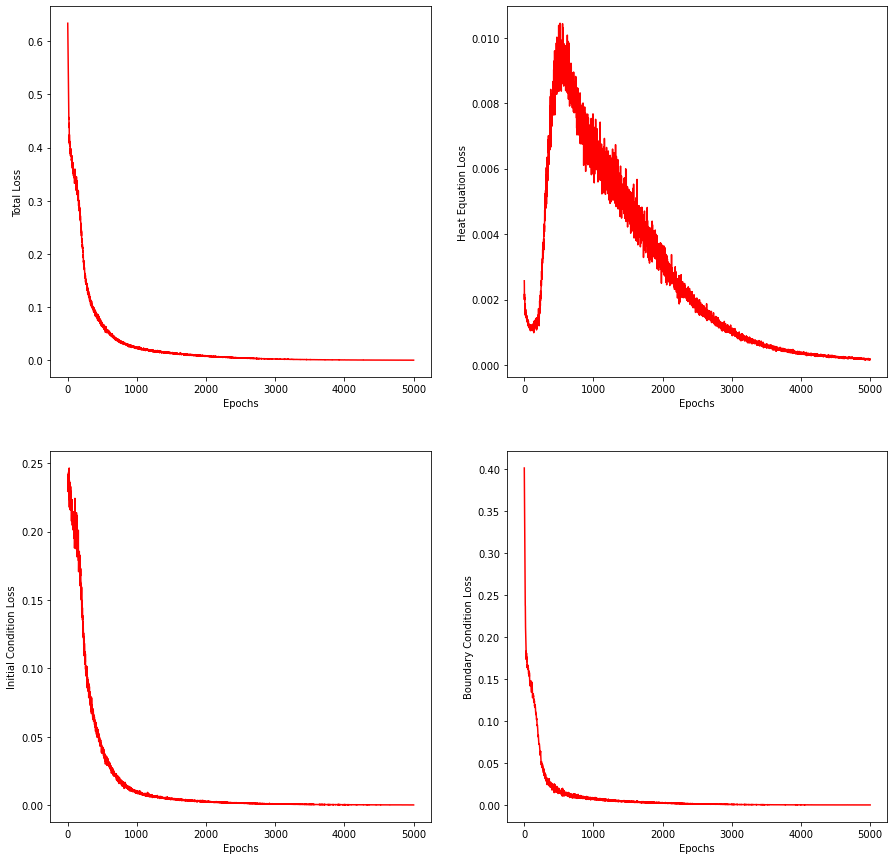

In [9]:
training(model,lr=0.0001,epochs=5000,batchsize=500)

In [31]:
model_new.load_weights('myModel_20_20_20_2000.h5')

(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)


16026

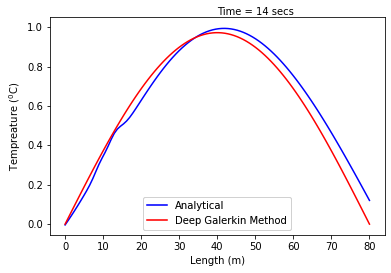

In [32]:
prediction(model_new)


gc.collect()